In [2]:
from typing import Tuple
import numpy as np
import deepgp
import matplotlib.pyplot as plt
from datetime import datetime
import os

import GPy
from GPy.models import GPRegression
from emukit.test_functions import forrester_function
from emukit.core.initial_designs import RandomDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement, EntropySearch
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from gpflow.kernels import RBF, White, Linear
from tqdm import tqdm

from simulator import MainSimulator, TinySimulator
from world import DebugInfo
from pprint import pprint

main_simulator = MainSimulator()

In [3]:
def plot_prediction(X,Y,x_plot,mu_plot,var_plot,axis):
    axis.plot(X, Y, "ro", markersize=10, label="Observations")
    axis.plot(x_plot[:, 0], mu_plot[:, 0], "C0", label="Model")
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
    axis.legend(loc=2, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [4]:
def plot_acquisition_functions(x_plot, ac_plot, x_new, axis):
    axis.plot(x_plot, (ac_plot[1] - np.min(ac_plot[1])) / (np.max(ac_plot[1]) - np.min(ac_plot[1])), label=ac_plot[0])
    #axis.plot(x_plot, (ac_plots[0][1] - np.min(ac_plots[0][1])) / (np.max(ac_plots[0][1]) - np.min(ac_plots[0][1])), label=ac_plots[0][0])
    #axis.plot(x_plot, (ac_plots[1][1] - np.min(ac_plots[1][1])) / (np.max(ac_plots[1][1]) - np.min(ac_plots[1][1])), label=ac_plots[1][0])
    #axis.plot(x_plot, (ac_plots[2][1] - np.min(ac_plots[2][1])) / (np.max(ac_plots[2][1]) - np.min(ac_plots[2][1])), label=ac_plots[2][0])
    #axis.plot(x_plot, (ac_plots[3][1] - np.min(ac_plots[3][1])) / (np.max(ac_plots[3][1]) - np.min(ac_plots[3][1])), label=ac_plots[3][0])

    axis.axvline(x_new, color="red", label="x_next", linestyle="--")
    axis.legend(loc=1, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [5]:
import statistics

def target_function_list(X, repetition=1):
    Y = []
    for x in X:
        mutation_rates = {
            "size": x[0],
            "speed": x[1],
            "vision": x[2],
            "aggression": x[3]
        }
        # items = []
        total = 0
        for i in range(repetition):
            days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
                period=10, should_display_day=False, should_display_grid=False, should_display_traits=False), max_days=10000)
            #items.append(days_survived)
            total += days_survived
        #Y.append(statistics.median(items))
        Y.append(total//repetition)
    return np.array(Y)[:,np.newaxis]

In [6]:
# Generate the initial points to start the training process

def experiment_initialisation(space, num_data_points = 5):
    design = RandomDesign(space) # Collect random points
    X = design.get_samples(num_data_points)
    Y = target_function_list(X)
    return X, Y

In [7]:
def model_generation(X, Y, space, kernel = None):
    if kernel is None:
        kernel_rbf_1 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[0])
        kernel_rbf_2 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[1])
        kernel_rbf_3 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[2])
        kernel_rbf_4 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[3])
        kernel = kernel_rbf_1 + kernel_rbf_2 + kernel_rbf_3 + kernel_rbf_4
    model_gpy = GPRegression(X,Y,kernel, noise_var=100) # Train and wrap the model in Emukit
    model_emukit = GPyModelWrapper(model_gpy)
    return model_emukit

In [8]:
iterations = 1000
# The other mutation rates for the projection
projection = 0
# Along which trait is the function plotted: 0-size, 1-speed, 2-vision, 3-aggression
plot = 0

# returns the mean square error history of the iterations
def train(model_emukit, X, Y, space, acquisition, iterations = 1000, plot = 0, projection = 0):

    file_path = 'training_logs/' + acquisition + '_plot_' + str(plot) + '_projection_' + str(projection) + '_' + str(datetime.now())
    os.makedirs(file_path)
    figure, axis = plt.subplots(1, 2, figsize=(20, 6))
    x_plot = np.linspace(0, 2, 1000)[:, None]
    x_paddings = np.linspace(projection, projection, 1000)[:, None]
    x_linear = np.linspace(0, 2, 1000)[:, None]

    history = []
    with open('dataset_test/mutation_rates.npy', 'rb') as f:
      X_test = np.load(f)
    with open('dataset_test/simulated_years_of_survival.npy', 'rb') as f:
      y_test = np.load(f)

    for j in range(plot):
        x_plot = np.append(x_paddings, x_plot, axis = 1)
    for j in range(3-plot):
        x_plot = np.append(x_plot, x_paddings, axis = 1)
    
    for i in tqdm(range(iterations)):
            
        mu_plot, var_plot = model_emukit.predict(x_plot)
        plot_prediction(X[:,plot],Y,x_linear,mu_plot,var_plot,axis[0])

        acquisition = CrossEntropy(model_emukit,space)
        #acquisition = ExpectedImprovement(model_emukit)
        #acquisition = ProbabilityOfImprovement(model_emukit)
        
        predictions, _ = model_emukit.predict(X_test)
        history.append(np.square(y_test - predictions).mean())
        #history.append(np.square(y_test + predictions).mean())
        
        ac_plot = ("AF", acquisition.evaluate(x_plot))
        
        optimizer = GradientAcquisitionOptimizer(space)
        x_new, _ = optimizer.optimize(acquisition)
        acquisition.debug(x_new)
        plot_acquisition_functions(x_linear, ac_plot, x_new[0][plot], axis[1])
        print("Next position to query:", x_new)
        #acquisition.debug(np.array(x_new))
        y_new = target_function_list(x_new)
        #y_new = -target_function_list(x_new)
        X = np.append(X, x_new, axis=0)
        Y = np.append(Y, y_new, axis=0)
        print(x_new, y_new)
        print('Prediction before set_data:', x_new, model_emukit.predict(np.array(x_new)))
        model_emukit.set_data(X, Y)
        model_emukit.optimize()
        print('Prediction after set_data:', x_new, model_emukit.predict(np.array(x_new)))
        plt.savefig(file_path + '/' + str(i) +'.png')
        plt.clf()
        figure, axis = plt.subplots(1, 2, figsize=(20, 6))
        with open(file_path + '/history.npy', 'wb') as f:
            np.save(f, np.array(history))
    return history

In [10]:
def sensitivity_2d(X, sensitivity, x_a=0, y_a=1, projection = 0):
    results = []
    for x in X:
        point = np.array([projection, projection, projection, projection])
        point[x_a] = x[0]
        point[y_a] = x[1]
        results.append(sensitivity.compute_statistics(point)[0])
    return np.array(results)

In [ ]:
sensitivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points = 10000)

In [11]:
def plot_sensitivity_2d(model_emukit, x_a=0, y_a=1, projection = 0):
    space = ParameterSpace([ContinuousParameter('size', 0, 1),
                        ContinuousParameter('speed', 0, 1),
                        ContinuousParameter('vision', 0, 1),
                        ContinuousParameter('aggression', 0, 1)])
    
    sensitivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
    main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points = 10000)
    
    x_axis = np.linspace(0, 1, 100)
    y_axis = np.linspace(0, 1, 100)
    
    X_axis,Y_axis = np.meshgrid(x_axis, y_axis)
    data = np.vstack([X_axis.ravel(), Y_axis.ravel()])
    data = np.swapaxes(data,0,-1)
    
    plt.figure(figsize=(8,6))
    plt.contourf(X_axis, Y_axis, sensitivity_2d(data, sensitivity, x_a, y_a, projection).reshape(X_axis.shape), levels=20)
    plt.colorbar()
    return main_effects, total_effects

In [9]:
space = ParameterSpace([ContinuousParameter('size', 0, 10),
                            ContinuousParameter('speed', 0, 10),
                            ContinuousParameter('vision', 0, 10),
                            ContinuousParameter('aggression', 0, 10)])
kernel = GPy.kern.Matern32(input_dim=4, lengthscale=0.1, variance=300)
X, Y = experiment_initialisation(space,5)

  0%|                                                                                                                                                    | 0/1000 [00:00<?, ?it/s]

[0.] [1213.33376972] 971.4 779.5148747778967
Next position to query: [[9.41520285 7.87024235 3.69567777 8.52106873]]


 /var/folders/8p/rl0cc1cx5h5301dxt0kcg54h0000gn/T/ipykernel_45366/837621339.py:2: RuntimeWarning:invalid value encountered in divide
  0%|▏                                                                                                                                         | 1/1000 [00:11<3:06:11, 11.18s/it]

[[9.41520285 7.87024235 3.69567777 8.52106873]] [[1528]]
Prediction before set_data: [[9.41520285 7.87024235 3.69567777 8.52106873]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[9.41520285 7.87024235 3.69567777 8.52106873]] (array([[1346.30671314]]), array([[329295.54287432]]))
[0.] [1213.33376972] 1272.8 630.9597134524519
Next position to query: [[1.33836244 3.68327043 1.11881663 6.73619981]]
[[1.33836244 3.68327043 1.11881663 6.73619981]] [[1450]]
Prediction before set_data: [[1.33836244 3.68327043 1.11881663 6.73619981]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.33836244 3.68327043 1.11881663 6.73619981]] (array([[1277.58163223]]), array([[329295.54287432]]))


  0%|▎                                                                                                                                         | 2/1000 [00:26<3:46:48, 13.64s/it]

[0.] [1213.33376972] 1558.0 105.59734845155826
Next position to query: [[1.17940642 5.84491116 2.59593494 9.13424488]]
[[1.17940642 5.84491116 2.59593494 9.13424488]] [[1658]]
Prediction before set_data: [[1.17940642 5.84491116 2.59593494 9.13424488]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.17940642 5.84491116 2.59593494 9.13424488]] (array([[1460.84851465]]), array([[329295.54287432]]))


  0%|▍                                                                                                                                         | 3/1000 [00:40<3:49:48, 13.83s/it]

[0.] [1213.33376972] 1544.0 84.70419115958674
Next position to query: [[4.65645949 6.11489765 1.79110952 6.39883845]]
[[4.65645949 6.11489765 1.79110952 6.39883845]] [[106]]
Prediction before set_data: [[4.65645949 6.11489765 1.79110952 6.39883845]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.65645949 6.11489765 1.79110952 6.39883845]] (array([[93.39562277]]), array([[329295.54287432]]))


  0%|▌                                                                                                                                         | 4/1000 [00:43<2:37:18,  9.48s/it]

[0.] [1213.33376972] 1584.0 110.88191917530925
Next position to query: [[0.12978256 4.1375223  3.74858744 5.35124953]]
[[0.12978256 4.1375223  3.74858744 5.35124953]] [[1718]]
Prediction before set_data: [[0.12978256 4.1375223  3.74858744 5.35124953]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.12978256 4.1375223  3.74858744 5.35124953]] (array([[1513.7139615]]), array([[329295.54287432]]))


  0%|▋                                                                                                                                         | 5/1000 [01:10<4:22:12, 15.81s/it]

[0.] [1213.33376972] 1635.8 100.38804709725278
Next position to query: [[1.48950984 0.66244497 4.59831204 8.53885474]]
[[1.48950984 0.66244497 4.59831204 8.53885474]] [[19]]
Prediction before set_data: [[1.48950984 0.66244497 4.59831204 8.53885474]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.48950984 0.66244497 4.59831204 8.53885474]] (array([[16.74072484]]), array([[329295.54287432]]))


  1%|▊                                                                                                                                         | 6/1000 [01:13<3:07:45, 11.33s/it]

[0.] [1213.33376972] 1582.0 108.32728188226552
Next position to query: [[0.50248664 6.13210263 4.60623882 4.91017372]]
[[0.50248664 6.13210263 4.60623882 4.91017372]] [[1447]]
Prediction before set_data: [[0.50248664 6.13210263 4.60623882 4.91017372]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.50248664 6.13210263 4.60623882 4.91017372]] (array([[1274.93835989]]), array([[329295.54287432]]))


  1%|▉                                                                                                                                         | 7/1000 [01:31<3:44:30, 13.57s/it]

[0.] [1213.33376972] 1581.4 109.06255085958546
Next position to query: [[0.92611743 7.31945868 6.57695182 5.40057911]]
[[0.92611743 7.31945868 6.57695182 5.40057911]] [[1434]]
Prediction before set_data: [[0.92611743 7.31945868 6.57695182 5.40057911]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.92611743 7.31945868 6.57695182 5.40057911]] (array([[1263.48417974]]), array([[329295.54287432]]))


  1%|█                                                                                                                                         | 8/1000 [01:44<3:44:22, 13.57s/it]

[0.] [1213.33376972] 1524.6 96.34230638717509
Next position to query: [[0.9207062  9.39187518 5.50408191 6.66963759]]
[[0.9207062  9.39187518 5.50408191 6.66963759]] [[38]]
Prediction before set_data: [[0.9207062  9.39187518 5.50408191 6.66963759]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.9207062  9.39187518 5.50408191 6.66963759]] (array([[33.48144967]]), array([[329295.54287432]]))


  1%|█▏                                                                                                                                        | 9/1000 [01:47<2:47:00, 10.11s/it]

[0.] [1213.33376972] 1579.6 111.12263495796086
Next position to query: [[0.68227445 4.90374671 3.58868592 6.31040814]]
[[0.68227445 4.90374671 3.58868592 6.31040814]] [[1934]]
Prediction before set_data: [[0.68227445 4.90374671 3.58868592 6.31040814]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.68227445 4.90374671 3.58868592 6.31040814]] (array([[1704.02957017]]), array([[329295.54287432]]))


  1%|█▎                                                                                                                                       | 10/1000 [02:05<3:26:54, 12.54s/it]

[0.] [1213.33376972] 1697.6 154.98335394486827
Next position to query: [[0.55382923 2.99724806 0.56973611 7.22738444]]
[[0.55382923 2.99724806 0.56973611 7.22738444]] [[1538]]
Prediction before set_data: [[0.55382923 2.99724806 0.56973611 7.22738444]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.55382923 2.99724806 0.56973611 7.22738444]] (array([[1355.11762095]]), array([[329295.54287432]]))


  1%|█▌                                                                                                                                       | 11/1000 [02:27<4:15:31, 15.50s/it]

[0.] [1213.33376972] 1578.6 121.85499579418398
Next position to query: [[2.03415316 3.33920853 0.20971203 2.15456428]]
[[2.03415316 3.33920853 0.20971203 2.15456428]] [[17]]
Prediction before set_data: [[2.03415316 3.33920853 0.20971203 2.15456428]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.03415316 3.33920853 0.20971203 2.15456428]] (array([[14.97854327]]), array([[329295.54287432]]))


  1%|█▋                                                                                                                                       | 12/1000 [02:30<3:11:24, 11.62s/it]

[0.] [1213.33376972] 37.4 34.37789987768304
Next position to query: [[7.88234795 0.60590488 5.19282328 3.93660078]]
[[7.88234795 0.60590488 5.19282328 3.93660078]] [[2128]]
Prediction before set_data: [[7.88234795 0.60590488 5.19282328 3.93660078]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[7.88234795 0.60590488 5.19282328 3.93660078]] (array([[1874.96118165]]), array([[329295.54287432]]))


  1%|█▊                                                                                                                                       | 13/1000 [02:47<3:37:07, 13.20s/it]

[0.] [1213.33376972] 1659.6 165.78733365369143
Next position to query: [[1.6218408  4.21980781 1.751891   7.23598365]]
[[1.6218408  4.21980781 1.751891   7.23598365]] [[20]]
Prediction before set_data: [[1.6218408  4.21980781 1.751891   7.23598365]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.6218408  4.21980781 1.751891   7.23598365]] (array([[17.62181562]]), array([[329295.54287432]]))


  1%|█▉                                                                                                                                       | 14/1000 [02:49<2:45:00, 10.04s/it]

[0.] [1213.33376972] 1676.4 157.28521863163004
Next position to query: [[0.55573989 5.53142637 5.0588403  8.27077072]]
[[0.55573989 5.53142637 5.0588403  8.27077072]] [[1533]]
Prediction before set_data: [[0.55573989 5.53142637 5.0588403  8.27077072]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.55573989 5.53142637 5.0588403  8.27077072]] (array([[1350.71216704]]), array([[329295.54287432]]))


  2%|██                                                                                                                                       | 15/1000 [03:06<3:19:51, 12.17s/it]

[0.] [1213.33376972] 1551.4 107.8825287059942
Next position to query: [[1.80391838 4.57810183 9.68758199 5.9750412 ]]
[[1.80391838 4.57810183 9.68758199 5.9750412 ]] [[16]]
Prediction before set_data: [[1.80391838 4.57810183 9.68758199 5.9750412 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.80391838 4.57810183 9.68758199 5.9750412 ]] (array([[14.09745249]]), array([[329295.54287432]]))


  2%|██▏                                                                                                                                      | 16/1000 [03:09<2:32:53,  9.32s/it]

[0.] [1213.33376972] 1651.4 167.80536344229188
Next position to query: [[0.49237495 3.11220496 5.46284345 5.27886759]]
[[0.49237495 3.11220496 5.46284345 5.27886759]] [[1546]]
Prediction before set_data: [[0.49237495 3.11220496 5.46284345 5.27886759]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.49237495 3.11220496 5.46284345 5.27886759]] (array([[1362.1663472]]), array([[329295.54287432]]))


  2%|██▎                                                                                                                                      | 17/1000 [03:28<3:20:31, 12.24s/it]

[0.] [1213.33376972] 1596.0 109.07612020969619
Next position to query: [[0.49350725 0.13895972 2.33220273 5.02767016]]
[[0.49350725 0.13895972 2.33220273 5.02767016]] [[1832]]
Prediction before set_data: [[0.49350725 0.13895972 2.33220273 5.02767016]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.49350725 0.13895972 2.33220273 5.02767016]] (array([[1614.15831052]]), array([[329295.54287432]]))


  2%|██▍                                                                                                                                      | 18/1000 [04:06<5:23:49, 19.79s/it]

[0.] [1213.33376972] 1554.0 107.56393447619885
Next position to query: [[2.87371152 4.49388192 6.10928931 3.85687997]]
[[2.87371152 4.49388192 6.10928931 3.85687997]] [[18]]
Prediction before set_data: [[2.87371152 4.49388192 6.10928931 3.85687997]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.87371152 4.49388192 6.10928931 3.85687997]] (array([[15.85963406]]), array([[329295.54287432]]))


  2%|██▌                                                                                                                                      | 19/1000 [04:08<4:00:08, 14.69s/it]

[0.] [1213.33376972] 1554.0 107.56393447619885
Next position to query: [[0.39052058 5.73030992 5.82177777 4.65802519]]
[[0.39052058 5.73030992 5.82177777 4.65802519]] [[1528]]
Prediction before set_data: [[0.39052058 5.73030992 5.82177777 4.65802519]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.39052058 5.73030992 5.82177777 4.65802519]] (array([[1346.30671314]]), array([[329295.54287432]]))


 /var/folders/8p/rl0cc1cx5h5301dxt0kcg54h0000gn/T/ipykernel_45366/414871600.py:60: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  2%|██▋                                                                                                                                      | 20/1000 [04:28<4:22:23, 16.07s/it]

[0.] [1213.33376972] 1513.4 68.94229471086697
Next position to query: [[2.69955627 6.14091966 6.09409416 7.02865759]]
[[2.69955627 6.14091966 6.09409416 7.02865759]] [[17]]
Prediction before set_data: [[2.69955627 6.14091966 6.09409416 7.02865759]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.69955627 6.14091966 6.09409416 7.02865759]] (array([[14.97854327]]), array([[329295.54287432]]))


  2%|██▉                                                                                                                                      | 21/1000 [04:30<3:17:17, 12.09s/it]

[0.] [1213.33376972] 1651.4 167.80536344229188
Next position to query: [[0.22520751 5.79599381 4.44152254 7.14348839]]
[[0.22520751 5.79599381 4.44152254 7.14348839]] [[1722]]
Prediction before set_data: [[0.22520751 5.79599381 4.44152254 7.14348839]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.22520751 5.79599381 4.44152254 7.14348839]] (array([[1517.23832463]]), array([[329295.54287432]]))


  2%|███                                                                                                                                      | 22/1000 [04:53<4:10:26, 15.36s/it]

[0.] [1213.33376972] 36.6 34.72520698282445
Next position to query: [[5.43185165 3.39519578 5.06833374 8.46346507]]
[[5.43185165 3.39519578 5.06833374 8.46346507]] [[1576]]
Prediction before set_data: [[5.43185165 3.39519578 5.06833374 8.46346507]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.43185165 3.39519578 5.06833374 8.46346507]] (array([[1388.59907062]]), array([[329295.54287432]]))


  2%|███▏                                                                                                                                     | 23/1000 [05:05<3:50:46, 14.17s/it]

[0.] [1213.33376972] 1694.4 134.43303165516932
Next position to query: [[0.31664827 4.75903852 4.45084501 9.21522074]]
[[0.31664827 4.75903852 4.45084501 9.21522074]] [[1533]]
Prediction before set_data: [[0.31664827 4.75903852 4.45084501 9.21522074]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.31664827 4.75903852 4.45084501 9.21522074]] (array([[1350.71216704]]), array([[329295.54287432]]))


  2%|███▎                                                                                                                                     | 24/1000 [05:26<4:23:29, 16.20s/it]

[0.] [1213.33376972] 1654.8 137.50112726810661
Next position to query: [[2.09246989 1.49032009 3.14394539 4.53506861]]
[[2.09246989 1.49032009 3.14394539 4.53506861]] [[20]]
Prediction before set_data: [[2.09246989 1.49032009 3.14394539 4.53506861]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.09246989 1.49032009 3.14394539 4.53506861]] (array([[17.62181562]]), array([[329295.54287432]]))


  2%|███▍                                                                                                                                     | 25/1000 [05:28<3:17:30, 12.15s/it]

[0.] [1213.33376972] 19.2 2.925747767665559
Next position to query: [[5.31470594 5.03840871 8.6538375  2.0445247 ]]
[[5.31470594 5.03840871 8.6538375  2.0445247 ]] [[1706]]
Prediction before set_data: [[5.31470594 5.03840871 8.6538375  2.0445247 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.31470594 5.03840871 8.6538375  2.0445247 ]] (array([[1503.14087213]]), array([[329295.54287432]]))


  3%|███▌                                                                                                                                     | 26/1000 [05:41<3:20:56, 12.38s/it]

[0.] [1213.33376972] 1572.8 92.04216425095751
Next position to query: [[0.6121715  3.95486691 6.43284218 5.77100154]]
[[0.6121715  3.95486691 6.43284218 5.77100154]] [[1641]]
Prediction before set_data: [[0.6121715  3.95486691 6.43284218 5.77100154]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.6121715  3.95486691 6.43284218 5.77100154]] (array([[1445.86997138]]), array([[329295.54287432]]))


  3%|███▋                                                                                                                                     | 27/1000 [05:59<3:45:49, 13.93s/it]

[0.] [1213.33376972] 1557.4 70.34372750999025
Next position to query: [[0.07771043 4.68144881 6.44777556 5.41375743]]
[[0.07771043 4.68144881 6.44777556 5.41375743]] [[59]]
Prediction before set_data: [[0.07771043 4.68144881 6.44777556 5.41375743]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.07771043 4.68144881 6.44777556 5.41375743]] (array([[51.98435607]]), array([[329295.54287432]]))


  3%|███▊                                                                                                                                     | 28/1000 [06:02<2:52:04, 10.62s/it]

[0.] [1213.33376972] 1610.8 71.53292948006833
Next position to query: [[0.21987281 5.01622554 6.48612786 7.92600084]]
[[0.21987281 5.01622554 6.48612786 7.92600084]] [[1536]]
Prediction before set_data: [[0.21987281 5.01622554 6.48612786 7.92600084]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.21987281 5.01622554 6.48612786 7.92600084]] (array([[1353.35543939]]), array([[329295.54287432]]))


  3%|███▉                                                                                                                                     | 29/1000 [06:24<3:45:41, 13.95s/it]

[0.] [1213.33376972] 1573.6 48.775403637494406
Next position to query: [[0.55485772 3.82239278 7.60183821 9.93284263]]
[[0.55485772 3.82239278 7.60183821 9.93284263]] [[1535]]
Prediction before set_data: [[0.55485772 3.82239278 7.60183821 9.93284263]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.55485772 3.82239278 7.60183821 9.93284263]] (array([[1352.47434861]]), array([[329295.54287432]]))


  3%|████                                                                                                                                     | 30/1000 [06:40<3:59:06, 14.79s/it]

[0.] [1213.33376972] 1552.4 36.31859028100584
Next position to query: [[0.68613453 3.20278359 5.90753315 9.31167426]]
[[0.68613453 3.20278359 5.90753315 9.31167426]] [[1663]]
Prediction before set_data: [[0.68613453 3.20278359 5.90753315 9.31167426]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.68613453 3.20278359 5.90753315 9.31167426]] (array([[1465.25396855]]), array([[329295.54287432]]))


  3%|████▏                                                                                                                                    | 31/1000 [06:57<4:08:38, 15.40s/it]

[0.] [1213.33376972] 1560.0 51.51310512869607
Next position to query: [[1.33898304 3.38959127 6.05388714 9.10504496]]
[[1.33898304 3.38959127 6.05388714 9.10504496]] [[1357]]
Prediction before set_data: [[1.33898304 3.38959127 6.05388714 9.10504496]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.33898304 3.38959127 6.05388714 9.10504496]] (array([[1195.64018961]]), array([[329295.54287432]]))


  3%|████▍                                                                                                                                    | 32/1000 [07:10<3:57:46, 14.74s/it]

[0.] [1213.33376972] 36.2 34.91933561796387
Next position to query: [[4.21624151 4.49930302 2.31410708 4.05949321]]
[[4.21624151 4.49930302 2.31410708 4.05949321]] [[91]]
Prediction before set_data: [[4.21624151 4.49930302 2.31410708 4.05949321]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.21624151 4.49930302 2.31410708 4.05949321]] (array([[80.17926106]]), array([[329295.54287432]]))


  3%|████▌                                                                                                                                    | 33/1000 [07:14<3:02:18, 11.31s/it]

[0.] [1213.33376972] 34.0 28.600699292150182
Next position to query: [[3.54051873 1.00606092 4.49107715 0.43806623]]
[[3.54051873 1.00606092 4.49107715 0.43806623]] [[1732]]
Prediction before set_data: [[3.54051873 1.00606092 4.49107715 0.43806623]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.54051873 1.00606092 4.49107715 0.43806623]] (array([[1526.04923243]]), array([[329295.54287432]]))


  3%|████▋                                                                                                                                    | 34/1000 [07:35<3:50:22, 14.31s/it]

[0.] [1213.33376972] 1600.0 54.02962150524642
Next position to query: [[0.05825125 3.14470921 7.79161844 7.41552897]]
[[0.05825125 3.14470921 7.79161844 7.41552897]] [[20]]
Prediction before set_data: [[0.05825125 3.14470921 7.79161844 7.41552897]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.05825125 3.14470921 7.79161844 7.41552897]] (array([[17.62181562]]), array([[329295.54287432]]))


  4%|████▊                                                                                                                                    | 35/1000 [07:38<2:54:58, 10.88s/it]

[0.] [1213.33376972] 1589.8 74.91702076297518
Next position to query: [[0.14386339 4.73999185 5.36591964 8.12127472]]
[[0.14386339 4.73999185 5.36591964 8.12127472]] [[1540]]
Prediction before set_data: [[0.14386339 4.73999185 5.36591964 8.12127472]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.14386339 4.73999185 5.36591964 8.12127472]] (array([[1356.87980251]]), array([[329295.54287432]]))


  4%|████▉                                                                                                                                    | 36/1000 [08:02<3:58:00, 14.81s/it]

[0.] [1213.33376972] 1575.0 47.678087209956175
Next position to query: [[1.04806866 4.81825942 6.33580624 7.53404788]]
[[1.04806866 4.81825942 6.33580624 7.53404788]] [[1452]]
Prediction before set_data: [[1.04806866 4.81825942 6.33580624 7.53404788]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.04806866 4.81825942 6.33580624 7.53404788]] (array([[1279.3438138]]), array([[329295.54287432]]))


  4%|█████                                                                                                                                    | 37/1000 [08:15<3:48:06, 14.21s/it]

[0.] [1213.33376972] 1518.8 33.498656689487554
Next position to query: [[1.12187928 5.78125436 5.65881696 9.2034972 ]]
[[1.12187928 5.78125436 5.65881696 9.2034972 ]] [[1537]]
Prediction before set_data: [[1.12187928 5.78125436 5.65881696 9.2034972 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.12187928 5.78125436 5.65881696 9.2034972 ]] (array([[1354.23653017]]), array([[329295.54287432]]))


  4%|█████▏                                                                                                                                   | 38/1000 [08:28<3:45:23, 14.06s/it]

[0.] [1213.33376972] 1537.0 54.72476587432617
Next position to query: [[1.34604009 5.38611564 7.44731009 8.95242131]]
[[1.34604009 5.38611564 7.44731009 8.95242131]] [[1537]]
Prediction before set_data: [[1.34604009 5.38611564 7.44731009 8.95242131]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.34604009 5.38611564 7.44731009 8.95242131]] (array([[1354.23653017]]), array([[329295.54287432]]))


  4%|█████▎                                                                                                                                   | 39/1000 [08:41<3:39:31, 13.71s/it] /var/folders/8p/rl0cc1cx5h5301dxt0kcg54h0000gn/T/ipykernel_45366/1287446881.py:45: RuntimeWarning:invalid value encountered in divide


[0.] [1213.33376972] 1536.0 2.683281573034456
Next position to query: [[0.8603472  5.37995978 5.92670403 9.97954789]]


 /var/folders/8p/rl0cc1cx5h5301dxt0kcg54h0000gn/T/ipykernel_45366/1287446881.py:72: RuntimeWarning:invalid value encountered in divide


[[0.8603472  5.37995978 5.92670403 9.97954789]] [[52]]
Prediction before set_data: [[0.8603472  5.37995978 5.92670403 9.97954789]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.8603472  5.37995978 5.92670403 9.97954789]] (array([[45.8167206]]), array([[329295.54287432]]))


  4%|█████▍                                                                                                                                   | 40/1000 [08:44<2:48:47, 10.55s/it]

[0.] [1213.33376972] 1516.8 68.61311827923464
Next position to query: [[0.50070145 6.6508968  8.01552657 6.99704821]]
[[0.50070145 6.6508968  8.01552657 6.99704821]] [[1624]]
Prediction before set_data: [[0.50070145 6.6508968  8.01552657 6.99704821]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.50070145 6.6508968  8.01552657 6.99704821]] (array([[1430.8914281]]), array([[329295.54287432]]))


  4%|█████▌                                                                                                                                   | 41/1000 [09:02<3:23:29, 12.73s/it]

[0.] [1213.33376972] 1518.8 33.498656689487554
Next position to query: [[0.43867604 4.22932884 5.41534564 8.00605333]]
[[0.43867604 4.22932884 5.41534564 8.00605333]] [[19]]
Prediction before set_data: [[0.43867604 4.22932884 5.41534564 8.00605333]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.43867604 4.22932884 5.41534564 8.00605333]] (array([[16.74072484]]), array([[329295.54287432]]))


  4%|█████▊                                                                                                                                   | 42/1000 [09:05<2:35:57,  9.77s/it]

[0.] [1213.33376972] 1596.6 78.91413054707256
Next position to query: [[0.53164975 5.84494915 3.80878117 9.07107989]]
[[0.53164975 5.84494915 3.80878117 9.07107989]] [[1533]]
Prediction before set_data: [[0.53164975 5.84494915 3.80878117 9.07107989]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.53164975 5.84494915 3.80878117 9.07107989]] (array([[1350.71216704]]), array([[329295.54287432]]))


  4%|█████▉                                                                                                                                   | 43/1000 [09:23<3:14:37, 12.20s/it]

[0.] [1213.33376972] 1567.4 48.11070566931714
Next position to query: [[3.30747085 4.56005795 3.68431808 9.13535935]]
[[3.30747085 4.56005795 3.68431808 9.13535935]] [[18]]
Prediction before set_data: [[3.30747085 4.56005795 3.68431808 9.13535935]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.30747085 4.56005795 3.68431808 9.13535935]] (array([[15.85963406]]), array([[329295.54287432]]))


  4%|██████                                                                                                                                   | 44/1000 [09:26<2:30:48,  9.46s/it]

[0.] [1213.33376972] 1533.6 60.20166110665626
Next position to query: [[0.48890722 7.84091901 8.31856227 8.35782535]]
[[0.48890722 7.84091901 8.31856227 8.35782535]] [[1645]]
Prediction before set_data: [[0.48890722 7.84091901 8.31856227 8.35782535]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.48890722 7.84091901 8.31856227 8.35782535]] (array([[1449.3943345]]), array([[329295.54287432]]))


  4%|██████▏                                                                                                                                  | 45/1000 [09:44<3:10:00, 11.94s/it]

[0.] [1213.33376972] 1554.8 64.7376242999383
Next position to query: [[0.32425874 5.06786239 7.59762233 7.71176965]]
[[0.32425874 5.06786239 7.59762233 7.71176965]] [[1445]]
Prediction before set_data: [[0.32425874 5.06786239 7.59762233 7.71176965]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.32425874 5.06786239 7.59762233 7.71176965]] (array([[1273.17617833]]), array([[329295.54287432]]))


  5%|██████▎                                                                                                                                  | 46/1000 [10:03<3:43:06, 14.03s/it]

[0.] [1213.33376972] 1501.4 43.25089594447339
Next position to query: [[1.92040418 5.49088686 7.16979083 8.53342644]]
[[1.92040418 5.49088686 7.16979083 8.53342644]] [[2448]]
Prediction before set_data: [[1.92040418 5.49088686 7.16979083 8.53342644]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.92040418 5.49088686 7.16979083 8.53342644]] (array([[2156.91023152]]), array([[329295.54287432]]))


  5%|██████▍                                                                                                                                  | 47/1000 [10:17<3:43:56, 14.10s/it]

[0.] [1213.33376972] 1573.6 74.23368507625494
Next position to query: [[0.26442267 5.87196239 5.44148451 8.15620796]]
[[0.26442267 5.87196239 5.44148451 8.15620796]] [[1654]]
Prediction before set_data: [[0.26442267 5.87196239 5.44148451 8.15620796]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.26442267 5.87196239 5.44148451 8.15620796]] (array([[1457.32415153]]), array([[329295.54287432]]))


  5%|██████▌                                                                                                                                  | 48/1000 [10:38<4:15:41, 16.12s/it]

[0.] [1213.33376972] 1501.4 43.25089594447339
Next position to query: [[0.44826077 5.1093916  6.74967556 8.7388129 ]]
[[0.44826077 5.1093916  6.74967556 8.7388129 ]] [[1352]]
Prediction before set_data: [[0.44826077 5.1093916  6.74967556 8.7388129 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.44826077 5.1093916  6.74967556 8.7388129 ]] (array([[1191.23473571]]), array([[329295.54287432]]))


  5%|██████▋                                                                                                                                  | 49/1000 [10:54<4:18:28, 16.31s/it]

[0.] [1213.33376972] 1558.8 49.62418765078231
Next position to query: [[1.72770875 7.33007404 3.40602438 9.42662583]]
[[1.72770875 7.33007404 3.40602438 9.42662583]] [[1393]]
Prediction before set_data: [[1.72770875 7.33007404 3.40602438 9.42662583]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.72770875 7.33007404 3.40602438 9.42662583]] (array([[1227.35945773]]), array([[329295.54287432]]))


  5%|██████▊                                                                                                                                  | 50/1000 [11:07<3:58:23, 15.06s/it]

[0.] [1213.33376972] 1553.4 66.98238574431439
Next position to query: [[0.39834984 5.56945219 8.10116421 7.51558558]]
[[0.39834984 5.56945219 8.10116421 7.51558558]] [[1537]]
Prediction before set_data: [[0.39834984 5.56945219 8.10116421 7.51558558]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.39834984 5.56945219 8.10116421 7.51558558]] (array([[1354.23653017]]), array([[329295.54287432]]))


  5%|██████▉                                                                                                                                  | 51/1000 [11:26<4:18:40, 16.35s/it]

[0.] [1213.33376972] 1557.6 71.51950782828443
Next position to query: [[1.21008627 6.76950207 9.73074326 8.10157123]]
[[1.21008627 6.76950207 9.73074326 8.10157123]] [[20]]
Prediction before set_data: [[1.21008627 6.76950207 9.73074326 8.10157123]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.21008627 6.76950207 9.73074326 8.10157123]] (array([[17.62181562]]), array([[329295.54287432]]))


  5%|███████                                                                                                                                  | 52/1000 [11:29<3:17:01, 12.47s/it]

[0.] [1213.33376972] 50.4 39.57069622839609
Next position to query: [[4.18171194 4.64234123 3.34089615 3.03582453]]
[[4.18171194 4.64234123 3.34089615 3.03582453]] [[1961]]
Prediction before set_data: [[4.18171194 4.64234123 3.34089615 3.03582453]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.18171194 4.64234123 3.34089615 3.03582453]] (array([[1727.81902125]]), array([[329295.54287432]]))


  5%|███████▎                                                                                                                                 | 53/1000 [11:44<3:25:16, 13.01s/it]

[0.] [1213.33376972] 1530.0 82.71880076500086
Next position to query: [[0.73639267 8.09901928 4.74962357 8.96606679]]
[[0.73639267 8.09901928 4.74962357 8.96606679]] [[1443]]
Prediction before set_data: [[0.73639267 8.09901928 4.74962357 8.96606679]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.73639267 8.09901928 4.74962357 8.96606679]] (array([[1271.41399677]]), array([[329295.54287432]]))


  5%|███████▍                                                                                                                                 | 54/1000 [11:59<3:37:01, 13.76s/it]

[0.] [1213.33376972] 1535.8 56.61589882709922
Next position to query: [[0.66122578 5.76966258 7.74618811 7.7793579 ]]
[[0.66122578 5.76966258 7.74618811 7.7793579 ]] [[1733]]
Prediction before set_data: [[0.66122578 5.76966258 7.74618811 7.7793579 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.66122578 5.76966258 7.74618811 7.7793579 ]] (array([[1526.93032321]]), array([[329295.54287432]]))


  6%|███████▌                                                                                                                                 | 55/1000 [12:15<3:48:31, 14.51s/it]

[0.] [1213.33376972] 1597.2 77.22538442765938
Next position to query: [[1.62310259 5.60491445 4.79081398 8.00978471]]
[[1.62310259 5.60491445 4.79081398 8.00978471]] [[53]]
Prediction before set_data: [[1.62310259 5.60491445 4.79081398 8.00978471]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.62310259 5.60491445 4.79081398 8.00978471]] (array([[46.69781139]]), array([[329295.54287432]]))


  6%|███████▋                                                                                                                                 | 56/1000 [12:19<2:54:43, 11.11s/it]

[0.] [1213.33376972] 1561.4 71.68151784107084
Next position to query: [[0.10417057 5.30911561 6.08076477 7.44270593]]
[[0.10417057 5.30911561 6.08076477 7.44270593]] [[1743]]
Prediction before set_data: [[0.10417057 5.30911561 6.08076477 7.44270593]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.10417057 5.30911561 6.08076477 7.44270593]] (array([[1535.74123102]]), array([[329295.54287432]]))


  6%|███████▊                                                                                                                                 | 57/1000 [12:45<4:05:37, 15.63s/it]

[0.] [1213.33376972] 1638.4 88.27819662861023
Next position to query: [[0.33307867 5.87552278 5.11619878 7.16666996]]
[[0.33307867 5.87552278 5.11619878 7.16666996]] [[1748]]
Prediction before set_data: [[0.33307867 5.87552278 5.11619878 7.16666996]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.33307867 5.87552278 5.11619878 7.16666996]] (array([[1540.14668493]]), array([[329295.54287432]]))


  6%|███████▉                                                                                                                                 | 58/1000 [13:05<4:26:47, 16.99s/it]

[0.] [1213.33376972] 1512.0 90.68627239003708
Next position to query: [[0.39809617 8.4082569  1.44839501 9.94088587]]
[[0.39809617 8.4082569  1.44839501 9.94088587]] [[30]]
Prediction before set_data: [[0.39809617 8.4082569  1.44839501 9.94088587]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.39809617 8.4082569  1.44839501 9.94088587]] (array([[26.43272343]]), array([[329295.54287432]]))


  6%|████████                                                                                                                                 | 59/1000 [13:08<3:21:39, 12.86s/it]

[0.] [1213.33376972] 1595.8 79.53213187134075
Next position to query: [[0.5714796  5.46663508 3.20743066 8.44124648]]
[[0.5714796  5.46663508 3.20743066 8.44124648]] [[1448]]
Prediction before set_data: [[0.5714796  5.46663508 3.20743066 8.44124648]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.5714796  5.46663508 3.20743066 8.44124648]] (array([[1275.81945067]]), array([[329295.54287432]]))


  6%|████████▏                                                                                                                                | 60/1000 [13:26<3:43:54, 14.29s/it]

[0.] [1213.33376972] 1516.8 34.43486605172499
Next position to query: [[0.2381858  5.32758979 4.35116897 9.44698696]]
[[0.2381858  5.32758979 4.35116897 9.44698696]] [[1626]]
Prediction before set_data: [[0.2381858  5.32758979 4.35116897 9.44698696]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.2381858  5.32758979 4.35116897 9.44698696]] (array([[1432.65360966]]), array([[329295.54287432]]))


  6%|████████▎                                                                                                                                | 61/1000 [13:48<4:20:59, 16.68s/it]

[0.] [1213.33376972] 1559.6 74.78128108022905
Next position to query: [[0.20168468 5.63306362 2.33743603 8.70934087]]
[[0.20168468 5.63306362 2.33743603 8.70934087]] [[18]]
Prediction before set_data: [[0.20168468 5.63306362 2.33743603 8.70934087]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.20168468 5.63306362 2.33743603 8.70934087]] (array([[15.85963406]]), array([[329295.54287432]]))


  6%|████████▍                                                                                                                                | 62/1000 [13:51<3:17:23, 12.63s/it]

[0.] [1213.33376972] 1534.6 56.322641983488516
Next position to query: [[0.531247   5.31189153 3.84989534 8.43736585]]
[[0.531247   5.31189153 3.84989534 8.43736585]] [[1634]]
Prediction before set_data: [[0.531247   5.31189153 3.84989534 8.43736585]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.531247   5.31189153 3.84989534 8.43736585]] (array([[1439.70233591]]), array([[329295.54287432]]))


  6%|████████▋                                                                                                                                | 63/1000 [14:10<3:46:59, 14.54s/it]

[0.] [1213.33376972] 1615.2 73.58369384585185
Next position to query: [[0.18233676 7.09865987 7.95404149 9.22296441]]
[[0.18233676 7.09865987 7.95404149 9.22296441]] [[17]]
Prediction before set_data: [[0.18233676 7.09865987 7.95404149 9.22296441]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.18233676 7.09865987 7.95404149 9.22296441]] (array([[14.97854327]]), array([[329295.54287432]]))


  6%|████████▊                                                                                                                                | 64/1000 [14:14<2:55:52, 11.27s/it]

[0.] [1213.33376972] 1572.6 46.957853443274395
Next position to query: [[1.39026824 4.69441332 4.16076084 9.81920877]]
[[1.39026824 4.69441332 4.16076084 9.81920877]] [[1443]]
Prediction before set_data: [[1.39026824 4.69441332 4.16076084 9.81920877]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.39026824 4.69441332 4.16076084 9.81920877]] (array([[1271.41399677]]), array([[329295.54287432]]))


  6%|████████▉                                                                                                                                | 65/1000 [14:28<3:09:39, 12.17s/it]

[0.] [1213.33376972] 57.6 35.9477398455035
Next position to query: [[3.64682527 5.67974643 2.90885305 6.63057778]]
[[3.64682527 5.67974643 2.90885305 6.63057778]] [[17]]
Prediction before set_data: [[3.64682527 5.67974643 2.90885305 6.63057778]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.64682527 5.67974643 2.90885305 6.63057778]] (array([[14.97854327]]), array([[329295.54287432]]))


  7%|█████████                                                                                                                                | 66/1000 [14:31<2:28:16,  9.53s/it]

[0.] [1213.33376972] 1596.0 52.24174575949952
Next position to query: [[0.11028061 6.59136228 4.40848906 9.2439144 ]]
[[0.11028061 6.59136228 4.40848906 9.2439144 ]] [[1641]]
Prediction before set_data: [[0.11028061 6.59136228 4.40848906 9.2439144 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.11028061 6.59136228 4.40848906 9.2439144 ]] (array([[1445.86997138]]), array([[329295.54287432]]))


  7%|█████████▏                                                                                                                               | 67/1000 [14:56<3:38:18, 14.04s/it]

[0.] [1213.33376972] 1680.0 80.7985148378354
Next position to query: [[0.66183851 7.04413487 5.34033978 7.10198076]]
[[0.66183851 7.04413487 5.34033978 7.10198076]] [[1464]]
Prediction before set_data: [[0.66183851 7.04413487 5.34033978 7.10198076]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.66183851 7.04413487 5.34033978 7.10198076]] (array([[1289.91690317]]), array([[329295.54287432]]))


  7%|█████████▎                                                                                                                               | 68/1000 [15:11<3:44:16, 14.44s/it]

[0.] [1213.33376972] 42.8 34.34763456193163
Next position to query: [[3.71538899 5.91384533 2.9931028  7.53526244]]
[[3.71538899 5.91384533 2.9931028  7.53526244]] [[1528]]
Prediction before set_data: [[3.71538899 5.91384533 2.9931028  7.53526244]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.71538899 5.91384533 2.9931028  7.53526244]] (array([[1346.30671314]]), array([[329295.54287432]]))


  7%|█████████▍                                                                                                                               | 69/1000 [15:24<3:32:58, 13.73s/it]

[0.] [1213.33376972] 1509.4 85.55138806588454
Next position to query: [[1.93135659 7.99498827 4.88961226 9.72656139]]
[[1.93135659 7.99498827 4.88961226 9.72656139]] [[16]]
Prediction before set_data: [[1.93135659 7.99498827 4.88961226 9.72656139]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.93135659 7.99498827 4.88961226 9.72656139]] (array([[14.09745249]]), array([[329295.54287432]]))


  7%|█████████▌                                                                                                                               | 70/1000 [15:27<2:44:04, 10.59s/it]

[0.] [1213.33376972] 1599.4 98.74532900345041
Next position to query: [[0.35832347 4.69127095 5.84987723 6.69736756]]
[[0.35832347 4.69127095 5.84987723 6.69736756]] [[1643]]
Prediction before set_data: [[0.35832347 4.69127095 5.84987723 6.69736756]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.35832347 4.69127095 5.84987723 6.69736756]] (array([[1447.63215294]]), array([[329295.54287432]]))


  7%|█████████▋                                                                                                                               | 71/1000 [15:47<3:29:03, 13.50s/it]

[0.] [1213.33376972] 1624.2 109.32593470901442
Next position to query: [[0.43516955 6.54730005 4.84467759 7.48228001]]
[[0.43516955 6.54730005 4.84467759 7.48228001]] [[31]]
Prediction before set_data: [[0.43516955 6.54730005 4.84467759 7.48228001]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.43516955 6.54730005 4.84467759 7.48228001]] (array([[27.31381421]]), array([[329295.54287432]]))


  7%|█████████▊                                                                                                                               | 72/1000 [15:50<2:41:45, 10.46s/it]

[0.] [1213.33376972] 1557.4 94.660657086245
Next position to query: [[1.0073188  4.3841906  9.11920589 9.13703427]]
[[1.0073188  4.3841906  9.11920589 9.13703427]] [[1742]]
Prediction before set_data: [[1.0073188  4.3841906  9.11920589 9.13703427]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.0073188  4.3841906  9.11920589 9.13703427]] (array([[1534.86014024]]), array([[329295.54287432]]))


  7%|██████████                                                                                                                               | 73/1000 [16:06<3:06:09, 12.05s/it]

[0.] [1213.33376972] 1464.4 68.64575733430114
Next position to query: [[0.63720888 4.39159121 6.83923605 8.75199529]]
[[0.63720888 4.39159121 6.83923605 8.75199529]] [[1726]]
Prediction before set_data: [[0.63720888 4.39159121 6.83923605 8.75199529]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.63720888 4.39159121 6.83923605 8.75199529]] (array([[1520.76268775]]), array([[329295.54287432]]))


  7%|██████████▏                                                                                                                              | 74/1000 [16:24<3:31:03, 13.68s/it]

[0.] [1213.33376972] 1623.8 116.41546289045995
Next position to query: [[0.84628696 5.22156566 5.47464756 7.16023205]]
[[0.84628696 5.22156566 5.47464756 7.16023205]] [[43]]
Prediction before set_data: [[0.84628696 5.22156566 5.47464756 7.16023205]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.84628696 5.22156566 5.47464756 7.16023205]] (array([[37.88690358]]), array([[329295.54287432]]))


  8%|██████████▎                                                                                                                              | 75/1000 [16:27<2:43:57, 10.63s/it]

[0.] [1213.33376972] 1576.4 75.26114535402553
Next position to query: [[0.59523559 6.22299839 3.75889161 8.70459835]]
[[0.59523559 6.22299839 3.75889161 8.70459835]] [[1440]]
Prediction before set_data: [[0.59523559 6.22299839 3.75889161 8.70459835]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.59523559 6.22299839 3.75889161 8.70459835]] (array([[1268.77072443]]), array([[329295.54287432]]))


  8%|██████████▍                                                                                                                              | 76/1000 [16:45<3:17:17, 12.81s/it]

[0.] [1213.33376972] 1592.8 96.5658324667683
Next position to query: [[0.66886877 5.62909215 7.66023444 6.26237282]]
[[0.66886877 5.62909215 7.66023444 6.26237282]] [[1342]]
Prediction before set_data: [[0.66886877 5.62909215 7.66023444 6.26237282]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.66886877 5.62909215 7.66023444 6.26237282]] (array([[1182.4238279]]), array([[329295.54287432]]))


  8%|██████████▌                                                                                                                              | 77/1000 [17:00<3:28:55, 13.58s/it]

[0.] [1213.33376972] 1579.8 81.11571980818377
Next position to query: [[0.61364956 3.57295403 4.04883473 9.34579276]]
[[0.61364956 3.57295403 4.04883473 9.34579276]] [[1435]]
Prediction before set_data: [[0.61364956 3.57295403 4.04883473 9.34579276]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.61364956 3.57295403 4.04883473 9.34579276]] (array([[1264.36527052]]), array([[329295.54287432]]))


  8%|██████████▋                                                                                                                              | 78/1000 [17:16<3:38:05, 14.19s/it]

[0.] [1213.33376972] 1554.8 68.8459149114875
Next position to query: [[0.24728353 4.98140226 3.7781885  8.83785002]]
[[0.24728353 4.98140226 3.7781885  8.83785002]] [[1542]]
Prediction before set_data: [[0.24728353 4.98140226 3.7781885  8.83785002]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.24728353 4.98140226 3.7781885  8.83785002]] (array([[1358.64198407]]), array([[329295.54287432]]))


  8%|██████████▊                                                                                                                              | 79/1000 [17:40<4:21:18, 17.02s/it]

[0.] [1213.33376972] 1480.2 47.05486159792789
Next position to query: [[0.36390946 3.61769863 2.91831129 9.43798028]]
[[0.36390946 3.61769863 2.91831129 9.43798028]] [[1429]]
Prediction before set_data: [[0.36390946 3.61769863 2.91831129 9.43798028]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.36390946 3.61769863 2.91831129 9.43798028]] (array([[1259.07872584]]), array([[329295.54287432]]))


  8%|██████████▉                                                                                                                              | 80/1000 [18:01<4:38:41, 18.18s/it]

[0.] [1213.33376972] 29.6 15.35708305636197
Next position to query: [[3.42056896 4.11032714 5.24377808 6.09786118]]
[[3.42056896 4.11032714 5.24377808 6.09786118]] [[60]]
Prediction before set_data: [[3.42056896 4.11032714 5.24377808 6.09786118]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.42056896 4.11032714 5.24377808 6.09786118]] (array([[52.86544685]]), array([[329295.54287432]]))


  8%|███████████                                                                                                                              | 81/1000 [18:05<3:32:55, 13.90s/it]

[0.] [1213.33376972] 26.6 16.7642476717567
Next position to query: [[6.2861327  7.21660663 5.94062546 5.03018403]]
[[6.2861327  7.21660663 5.94062546 5.03018403]] [[1653]]
Prediction before set_data: [[6.2861327  7.21660663 5.94062546 5.03018403]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[6.2861327  7.21660663 5.94062546 5.03018403]] (array([[1456.44306075]]), array([[329295.54287432]]))


  8%|███████████▏                                                                                                                             | 82/1000 [18:17<3:24:27, 13.36s/it]

[0.] [1213.33376972] 38.0 17.977764043395386
Next position to query: [[2.66900227 5.29665399 4.82629345 7.00983373]]
[[2.66900227 5.29665399 4.82629345 7.00983373]] [[146]]
Prediction before set_data: [[2.66900227 5.29665399 4.82629345 7.00983373]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.66900227 5.29665399 4.82629345 7.00983373]] (array([[128.639254]]), array([[329295.54287432]]))


  8%|███████████▎                                                                                                                             | 83/1000 [18:20<2:40:33, 10.51s/it]

[0.] [1213.33376972] 1466.4 32.499846153478295
Next position to query: [[1.85736226 7.63051246 3.72955891 4.76162489]]
[[1.85736226 7.63051246 3.72955891 4.76162489]] [[1499]]
Prediction before set_data: [[1.85736226 7.63051246 3.72955891 4.76162489]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.85736226 7.63051246 3.72955891 4.76162489]] (array([[1320.7550805]]), array([[329295.54287432]]))


  8%|███████████▌                                                                                                                             | 84/1000 [18:34<2:54:29, 11.43s/it]

[0.] [1213.33376972] 1598.2 52.373275627937986
Next position to query: [[0.05045279 6.53966125 5.04198689 9.47629345]]
[[0.05045279 6.53966125 5.04198689 9.47629345]] [[50]]
Prediction before set_data: [[0.05045279 6.53966125 5.04198689 9.47629345]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.05045279 6.53966125 5.04198689 9.47629345]] (array([[44.05453904]]), array([[329295.54287432]]))


  8%|███████████▋                                                                                                                             | 85/1000 [18:38<2:19:23,  9.14s/it]

[0.] [1213.33376972] 1474.4 34.55198981245293
Next position to query: [[1.7382562  6.79594447 4.5190445  5.06984845]]
[[1.7382562  6.79594447 4.5190445  5.06984845]] [[1751]]
Prediction before set_data: [[1.7382562  6.79594447 4.5190445  5.06984845]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.7382562  6.79594447 4.5190445  5.06984845]] (array([[1542.78995727]]), array([[329295.54287432]]))


  9%|███████████▊                                                                                                                             | 86/1000 [18:52<2:44:23, 10.79s/it]

[0.] [1213.33376972] 1477.4 49.53624935337607
Next position to query: [[0.11866783 3.84168121 3.08125631 9.33912017]]
[[0.11866783 3.84168121 3.08125631 9.33912017]] [[1632]]
Prediction before set_data: [[0.11866783 3.84168121 3.08125631 9.33912017]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.11866783 3.84168121 3.08125631 9.33912017]] (array([[1437.94015435]]), array([[329295.54287432]]))


  9%|███████████▉                                                                                                                             | 87/1000 [19:18<3:52:16, 15.26s/it]

[0.] [1213.33376972] 1534.8 58.92843116866472
Next position to query: [[0.20603115 5.60173963 3.69738607 9.80884258]]
[[0.20603115 5.60173963 3.69738607 9.80884258]] [[1645]]
Prediction before set_data: [[0.20603115 5.60173963 3.69738607 9.80884258]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.20603115 5.60173963 3.69738607 9.80884258]] (array([[1449.3943345]]), array([[329295.54287432]]))


  9%|████████████                                                                                                                             | 88/1000 [19:40<4:24:12, 17.38s/it]

[0.] [1213.33376972] 1596.0 48.228622207149975
Next position to query: [[0.49569731 5.42994475 3.59503837 9.35673372]]
[[0.49569731 5.42994475 3.59503837 9.35673372]] [[1735]]
Prediction before set_data: [[0.49569731 5.42994475 3.59503837 9.35673372]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.49569731 5.42994475 3.59503837 9.35673372]] (array([[1528.69250478]]), array([[329295.54287432]]))


  9%|████████████▏                                                                                                                            | 89/1000 [20:00<4:32:27, 17.94s/it]

[0.] [1213.33376972] 1553.8 70.40852221144732
Next position to query: [[1.1599004  5.15918119 4.29347178 8.96184352]]
[[1.1599004  5.15918119 4.29347178 8.96184352]] [[28]]
Prediction before set_data: [[1.1599004  5.15918119 4.29347178 8.96184352]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.1599004  5.15918119 4.29347178 8.96184352]] (array([[24.67054186]]), array([[329295.54287432]]))


  9%|████████████▎                                                                                                                            | 90/1000 [20:03<3:25:37, 13.56s/it]

[0.] [1213.33376972] 27.4 16.316862443496916
Next position to query: [[2.55380057 2.23743423 4.02105683 7.23801616]]
[[2.55380057 2.23743423 4.02105683 7.23801616]] [[1439]]
Prediction before set_data: [[2.55380057 2.23743423 4.02105683 7.23801616]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.55380057 2.23743423 4.02105683 7.23801616]] (array([[1267.88963364]]), array([[329295.54287432]]))


  9%|████████████▍                                                                                                                            | 91/1000 [20:17<3:25:46, 13.58s/it]

[0.] [1213.33376972] 26.4 16.88312767232423
Next position to query: [[4.53728621 4.76550364 8.23341399 5.84959667]]
[[4.53728621 4.76550364 8.23341399 5.84959667]] [[64]]
Prediction before set_data: [[4.53728621 4.76550364 8.23341399 5.84959667]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.53728621 4.76550364 8.23341399 5.84959667]] (array([[56.38980997]]), array([[329295.54287432]]))


  9%|████████████▌                                                                                                                            | 92/1000 [20:20<2:39:10, 10.52s/it]

[0.] [1213.33376972] 35.0 22.090722034374522
Next position to query: [[4.02239577 3.99098026 7.63187738 5.97037815]]
[[4.02239577 3.99098026 7.63187738 5.97037815]] [[1631]]
Prediction before set_data: [[4.02239577 3.99098026 7.63187738 5.97037815]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.02239577 3.99098026 7.63187738 5.97037815]] (array([[1437.05906357]]), array([[329295.54287432]]))


  9%|████████████▋                                                                                                                            | 93/1000 [20:33<2:49:29, 11.21s/it]

[0.] [1213.33376972] 1560.0 47.05316142407437
Next position to query: [[0.78331345 5.44741661 5.65482354 8.40423504]]
[[0.78331345 5.44741661 5.65482354 8.40423504]] [[1544]]
Prediction before set_data: [[0.78331345 5.44741661 5.65482354 8.40423504]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.78331345 5.44741661 5.65482354 8.40423504]] (array([[1360.40416563]]), array([[329295.54287432]]))


  9%|████████████▉                                                                                                                            | 94/1000 [20:49<3:10:03, 12.59s/it]

[0.] [1213.33376972] 1536.8 110.90969299389674
Next position to query: [[1.28536245 9.48573749 3.77267617 0.3813329 ]]
[[1.28536245 9.48573749 3.77267617 0.3813329 ]] [[1538]]
Prediction before set_data: [[1.28536245 9.48573749 3.77267617 0.3813329 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.28536245 9.48573749 3.77267617 0.3813329 ]] (array([[1355.11762095]]), array([[329295.54287432]]))


 10%|█████████████                                                                                                                            | 95/1000 [21:08<3:39:31, 14.55s/it]

[0.] [1213.33376972] 1489.2 41.97808952298429
Next position to query: [[0.22313756 9.16877529 5.44273641 0.1002965 ]]
[[0.22313756 9.16877529 5.44273641 0.1002965 ]] [[1740]]
Prediction before set_data: [[0.22313756 9.16877529 5.44273641 0.1002965 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.22313756 9.16877529 5.44273641 0.1002965 ]] (array([[1533.09795868]]), array([[329295.54287432]]))


 10%|█████████████▏                                                                                                                           | 96/1000 [21:42<5:07:32, 20.41s/it]

[0.] [1213.33376972] 1557.8 69.61723924431402
Next position to query: [[0.48302215 4.30045611 3.65034477 7.94605891]]
[[0.48302215 4.30045611 3.65034477 7.94605891]] [[1433]]
Prediction before set_data: [[0.48302215 4.30045611 3.65034477 7.94605891]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.48302215 4.30045611 3.65034477 7.94605891]] (array([[1262.60308896]]), array([[329295.54287432]]))


 10%|█████████████▎                                                                                                                           | 97/1000 [22:00<4:56:09, 19.68s/it]

[0.] [1213.33376972] 1496.8 78.20843944230096
Next position to query: [[0.32092378 1.55386929 1.49944808 8.99395201]]
[[0.32092378 1.55386929 1.49944808 8.99395201]] [[1629]]
Prediction before set_data: [[0.32092378 1.55386929 1.49944808 8.99395201]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.32092378 1.55386929 1.49944808 8.99395201]] (array([[1435.29688201]]), array([[329295.54287432]]))


 10%|█████████████▍                                                                                                                           | 98/1000 [22:26<5:25:04, 21.62s/it]

[0.] [1213.33376972] 1517.0 72.53412989758812
Next position to query: [[0.49515391 4.05202649 4.18080172 9.18641834]]
[[0.49515391 4.05202649 4.18080172 9.18641834]] [[17]]
Prediction before set_data: [[0.49515391 4.05202649 4.18080172 9.18641834]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.49515391 4.05202649 4.18080172 9.18641834]] (array([[14.97854327]]), array([[329295.54287432]]))


 10%|█████████████▌                                                                                                                           | 99/1000 [22:30<4:05:28, 16.35s/it]

[0.] [1213.33376972] 1627.2 93.79850745081013
Next position to query: [[4.34169532 9.42384301 5.66314964 0.1007225 ]]
[[4.34169532 9.42384301 5.66314964 0.1007225 ]] [[1620]]
Prediction before set_data: [[4.34169532 9.42384301 5.66314964 0.1007225 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.34169532 9.42384301 5.66314964 0.1007225 ]] (array([[1427.36706498]]), array([[329295.54287432]]))


 10%|█████████████▌                                                                                                                          | 100/1000 [22:48<4:12:11, 16.81s/it]

[0.] [1213.33376972] 1651.4 70.25553358988448
Next position to query: [[3.95138392 8.81117863 7.22909511 1.13279524]]
[[3.95138392 8.81117863 7.22909511 1.13279524]] [[17]]
Prediction before set_data: [[3.95138392 8.81117863 7.22909511 1.13279524]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.95138392 8.81117863 7.22909511 1.13279524]] (array([[14.97854327]]), array([[329295.54287432]]))


 10%|█████████████▋                                                                                                                          | 101/1000 [22:52<3:13:01, 12.88s/it]

[0.] [1213.33376972] 1532.6 88.83828003738154
Next position to query: [[0.90084087 1.54479705 1.4796915  9.94005037]]
[[0.90084087 1.54479705 1.4796915  9.94005037]] [[1491]]
Prediction before set_data: [[0.90084087 1.54479705 1.4796915  9.94005037]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.90084087 1.54479705 1.4796915  9.94005037]] (array([[1313.70635425]]), array([[329295.54287432]]))


 10%|█████████████▊                                                                                                                          | 102/1000 [23:12<3:44:00, 14.97s/it]

[0.] [1213.33376972] 1509.4 69.20289011305505
Next position to query: [[3.14154213 1.2816972  1.36616645 7.70027225]]
[[3.14154213 1.2816972  1.36616645 7.70027225]] [[1475]]
Prediction before set_data: [[3.14154213 1.2816972  1.36616645 7.70027225]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.14154213 1.2816972  1.36616645 7.70027225]] (array([[1299.60890175]]), array([[329295.54287432]]))


 10%|██████████████                                                                                                                          | 103/1000 [23:27<3:46:15, 15.13s/it]

[0.] [1213.33376972] 1486.2 48.47844882007003
Next position to query: [[5.75119963 0.7031403  0.16506421 8.35217706]]
[[5.75119963 0.7031403  0.16506421 8.35217706]] [[1443]]
Prediction before set_data: [[5.75119963 0.7031403  0.16506421 8.35217706]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.75119963 0.7031403  0.16506421 8.35217706]] (array([[1271.41399677]]), array([[329295.54287432]]))


 10%|██████████████▏                                                                                                                         | 104/1000 [23:49<4:16:47, 17.20s/it]

[0.] [1213.33376972] 1553.4 36.46697135765255
Next position to query: [[2.04229824e-03 5.24162069e+00 4.73336819e+00 9.25655955e+00]]
[[2.04229824e-03 5.24162069e+00 4.73336819e+00 9.25655955e+00]] [[20]]
Prediction before set_data: [[2.04229824e-03 5.24162069e+00 4.73336819e+00 9.25655955e+00]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.04229824e-03 5.24162069e+00 4.73336819e+00 9.25655955e+00]] (array([[17.62181562]]), array([[329295.54287432]]))


 10%|██████████████▎                                                                                                                         | 105/1000 [23:53<3:16:06, 13.15s/it]

[0.] [1213.33376972] 1484.8 49.59193482815396
Next position to query: [[5.72764024 0.83052119 0.33040455 9.41812213]]
[[5.72764024 0.83052119 0.33040455 9.41812213]] [[1538]]
Prediction before set_data: [[5.72764024 0.83052119 0.33040455 9.41812213]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.72764024 0.83052119 0.33040455 9.41812213]] (array([[1355.11762095]]), array([[329295.54287432]]))


 11%|██████████████▍                                                                                                                         | 106/1000 [24:13<3:45:20, 15.12s/it]

[0.] [1213.33376972] 1477.2 36.11315549768094
Next position to query: [[4.10315327 0.17785856 1.94668111 8.92225293]]
[[4.10315327 0.17785856 1.94668111 8.92225293]] [[16]]
Prediction before set_data: [[4.10315327 0.17785856 1.94668111 8.92225293]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.10315327 0.17785856 1.94668111 8.92225293]] (array([[14.09745249]]), array([[329295.54287432]]))


 11%|██████████████▌                                                                                                                         | 107/1000 [24:17<2:55:45, 11.81s/it]

[0.] [1213.33376972] 1512.4 67.91641922245066
Next position to query: [[0.48308633 0.59925191 0.87772443 9.23384543]]
[[0.48308633 0.59925191 0.87772443 9.23384543]] [[1534]]
Prediction before set_data: [[0.48308633 0.59925191 0.87772443 9.23384543]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.48308633 0.59925191 0.87772443 9.23384543]] (array([[1351.59325783]]), array([[329295.54287432]]))


 11%|██████████████▋                                                                                                                         | 108/1000 [24:47<4:16:53, 17.28s/it]

[0.] [1213.33376972] 1533.4 53.608208326709175
Next position to query: [[0.01018249 0.91976568 0.50609789 7.91154741]]
[[0.01018249 0.91976568 0.50609789 7.91154741]] [[19]]
Prediction before set_data: [[0.01018249 0.91976568 0.50609789 7.91154741]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.01018249 0.91976568 0.50609789 7.91154741]] (array([[16.74072484]]), array([[329295.54287432]]))


 11%|██████████████▊                                                                                                                         | 109/1000 [24:51<3:17:06, 13.27s/it]

[0.] [1213.33376972] 1519.4 71.03689182389498
Next position to query: [[0.53277585 5.70864751 4.02490802 8.47159072]]
[[0.53277585 5.70864751 4.02490802 8.47159072]] [[1645]]
Prediction before set_data: [[0.53277585 5.70864751 4.02490802 8.47159072]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.53277585 5.70864751 4.02490802 8.47159072]] (array([[1449.3943345]]), array([[329295.54287432]]))


 11%|██████████████▉                                                                                                                         | 110/1000 [25:10<3:42:45, 15.02s/it]

[0.] [1213.33376972] 63.8 43.613759296809086
Next position to query: [[2.99313824 6.11834892 5.47925162 7.26271028]]
[[2.99313824 6.11834892 5.47925162 7.26271028]] [[17]]
Prediction before set_data: [[2.99313824 6.11834892 5.47925162 7.26271028]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.99313824 6.11834892 5.47925162 7.26271028]] (array([[14.97854327]]), array([[329295.54287432]]))


 11%|███████████████                                                                                                                         | 111/1000 [25:14<2:52:59, 11.68s/it]

[0.] [1213.33376972] 58.6 47.187286423357726
Next position to query: [[3.06069056 5.42965396 5.93275559 6.76430143]]
[[3.06069056 5.42965396 5.93275559 6.76430143]] [[1315]]
Prediction before set_data: [[3.06069056 5.42965396 5.93275559 6.76430143]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.06069056 5.42965396 5.93275559 6.76430143]] (array([[1158.63437682]]), array([[329295.54287432]]))


 11%|███████████████▏                                                                                                                        | 112/1000 [25:26<2:55:47, 11.88s/it]

[0.] [1213.33376972] 1513.6 65.26744977399007
Next position to query: [[1.98968228 1.70574201 2.15883443 8.40575396]]
[[1.98968228 1.70574201 2.15883443 8.40575396]] [[1623]]
Prediction before set_data: [[1.98968228 1.70574201 2.15883443 8.40575396]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.98968228 1.70574201 2.15883443 8.40575396]] (array([[1430.01033732]]), array([[329295.54287432]]))


 11%|███████████████▎                                                                                                                        | 113/1000 [25:43<3:16:56, 13.32s/it]

[0.] [1213.33376972] 1551.2 64.51790449169948
Next position to query: [[1.62567565 2.18317798 1.67268552 8.27123757]]
[[1.62567565 2.18317798 1.67268552 8.27123757]] [[1455]]
Prediction before set_data: [[1.62567565 2.18317798 1.67268552 8.27123757]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.62567565 2.18317798 1.67268552 8.27123757]] (array([[1281.98708614]]), array([[329295.54287432]]))


 11%|███████████████▌                                                                                                                        | 114/1000 [25:58<3:27:42, 14.07s/it]

[0.] [1213.33376972] 1546.4 69.66663476872898
Next position to query: [[0.66482651 1.72890813 1.84363772 9.85957414]]
[[0.66482651 1.72890813 1.84363772 9.85957414]] [[1640]]
Prediction before set_data: [[0.66482651 1.72890813 1.84363772 9.85957414]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.66482651 1.72890813 1.84363772 9.85957414]] (array([[1444.9888806]]), array([[329295.54287432]]))


 12%|███████████████▋                                                                                                                        | 115/1000 [26:19<3:57:28, 16.10s/it]

[0.] [1213.33376972] 1508.2 65.40152903411257
Next position to query: [[1.64459805 2.28297844 1.52641465 7.16771096]]
[[1.64459805 2.28297844 1.52641465 7.16771096]] [[16]]
Prediction before set_data: [[1.64459805 2.28297844 1.52641465 7.16771096]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.64459805 2.28297844 1.52641465 7.16771096]] (array([[14.09745249]]), array([[329295.54287432]]))


 12%|███████████████▊                                                                                                                        | 116/1000 [26:23<3:02:22, 12.38s/it]

[0.] [1213.33376972] 1583.4 59.71465481772336
Next position to query: [[1.09636856 0.51026109 2.25691303 9.19020528]]
[[1.09636856 0.51026109 2.25691303 9.19020528]] [[1348]]
Prediction before set_data: [[1.09636856 0.51026109 2.25691303 9.19020528]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.09636856 0.51026109 2.25691303 9.19020528]] (array([[1187.71037259]]), array([[329295.54287432]]))


 12%|███████████████▉                                                                                                                        | 117/1000 [26:45<3:44:54, 15.28s/it]

[0.] [1213.33376972] 1506.8 66.69452751163433
Next position to query: [[4.29115952 3.13584475 0.31343309 9.08840395]]
[[4.29115952 3.13584475 0.31343309 9.08840395]] [[1717]]
Prediction before set_data: [[4.29115952 3.13584475 0.31343309 9.08840395]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.29115952 3.13584475 0.31343309 9.08840395]] (array([[1512.83287072]]), array([[329295.54287432]]))


 12%|████████████████                                                                                                                        | 118/1000 [27:03<3:55:45, 16.04s/it]

[0.] [1213.33376972] 1578.6 80.82227415756556
Next position to query: [[0.08808321 6.51192056 3.78528534 8.59796354]]
[[0.08808321 6.51192056 3.78528534 8.59796354]] [[1836]]
Prediction before set_data: [[0.08808321 6.51192056 3.78528534 8.59796354]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.08808321 6.51192056 3.78528534 8.59796354]] (array([[1617.68267364]]), array([[329295.54287432]]))


 12%|████████████████▏                                                                                                                       | 119/1000 [27:30<4:44:09, 19.35s/it]

[0.] [1213.33376972] 1602.2 83.58803742162809
Next position to query: [[0.34394192 5.93809297 5.74972781 8.40117494]]
[[0.34394192 5.93809297 5.74972781 8.40117494]] [[1752]]
Prediction before set_data: [[0.34394192 5.93809297 5.74972781 8.40117494]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.34394192 5.93809297 5.74972781 8.40117494]] (array([[1543.67104805]]), array([[329295.54287432]]))


 12%|████████████████▎                                                                                                                       | 120/1000 [27:51<4:51:56, 19.91s/it]

[0.] [1213.33376972] 1510.6 74.33599397331226
Next position to query: [[1.30560056 3.9563428  0.32270267 9.88745594]]
[[1.30560056 3.9563428  0.32270267 9.88745594]] [[1632]]
Prediction before set_data: [[1.30560056 3.9563428  0.32270267 9.88745594]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.30560056 3.9563428  0.32270267 9.88745594]] (array([[1437.94015435]]), array([[329295.54287432]]))


 12%|████████████████▍                                                                                                                       | 121/1000 [28:10<4:46:21, 19.55s/it]

[0.] [1213.33376972] 1569.4 79.61055206440821
Next position to query: [[1.56264147 2.79675388 0.65751639 9.80184668]]
[[1.56264147 2.79675388 0.65751639 9.80184668]] [[22]]
Prediction before set_data: [[1.56264147 2.79675388 0.65751639 9.80184668]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.56264147 2.79675388 0.65751639 9.80184668]] (array([[19.38399718]]), array([[329295.54287432]]))


 12%|████████████████▌                                                                                                                       | 122/1000 [28:14<3:38:14, 14.91s/it]

[0.] [1213.33376972] 1560.4 89.5557926658
Next position to query: [[9.97545901 4.17329592 2.09362657 8.63878347]]
[[9.97545901 4.17329592 2.09362657 8.63878347]] [[2355]]
Prediction before set_data: [[9.97545901 4.17329592 2.09362657 8.63878347]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[9.97545901 4.17329592 2.09362657 8.63878347]] (array([[2074.9687889]]), array([[329295.54287432]]))


 12%|████████████████▋                                                                                                                       | 123/1000 [28:29<3:36:51, 14.84s/it]

[0.] [1213.33376972] 1629.6 102.43554070731751
Next position to query: [[2.37190903 8.58254822 3.62033786 1.91190787]]
[[2.37190903 8.58254822 3.62033786 1.91190787]] [[1940]]
Prediction before set_data: [[2.37190903 8.58254822 3.62033786 1.91190787]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.37190903 8.58254822 3.62033786 1.91190787]] (array([[1709.31611485]]), array([[329295.54287432]]))


 12%|████████████████▊                                                                                                                       | 124/1000 [28:44<3:40:30, 15.10s/it]

[0.] [1213.33376972] 1553.0 98.87972491871216
Next position to query: [[0.17427149 2.77680201 2.48445499 9.16865556]]
[[0.17427149 2.77680201 2.48445499 9.16865556]] [[19]]
Prediction before set_data: [[0.17427149 2.77680201 2.48445499 9.16865556]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.17427149 2.77680201 2.48445499 9.16865556]] (array([[16.74072484]]), array([[329295.54287432]]))


 12%|█████████████████                                                                                                                       | 125/1000 [28:48<2:50:28, 11.69s/it]

[0.] [1213.33376972] 1645.8 92.96536989654008
Next position to query: [[0.08802557 5.82859467 6.27888865 7.7836117 ]]
[[0.08802557 5.82859467 6.27888865 7.7836117 ]] [[1427]]
Prediction before set_data: [[0.08802557 5.82859467 6.27888865 7.7836117 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.08802557 5.82859467 6.27888865 7.7836117 ]] (array([[1257.31654427]]), array([[329295.54287432]]))


 13%|█████████████████▏                                                                                                                      | 126/1000 [29:13<3:46:36, 15.56s/it]

[0.] [1213.33376972] 1604.0 86.64179130188741
Next position to query: [[0.50875162 5.72274937 5.68791409 8.94435178]]
[[0.50875162 5.72274937 5.68791409 8.94435178]] [[1250]]
Prediction before set_data: [[0.50875162 5.72274937 5.68791409 8.94435178]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.50875162 5.72274937 5.68791409 8.94435178]] (array([[1101.36347606]]), array([[329295.54287432]]))


 13%|█████████████████▎                                                                                                                      | 127/1000 [29:29<3:50:13, 15.82s/it]

[0.] [1213.33376972] 1557.4 77.26473969411825
Next position to query: [[0.22040945 4.81609144 4.02184693 8.65081375]]
[[0.22040945 4.81609144 4.02184693 8.65081375]] [[1443]]
Prediction before set_data: [[0.22040945 4.81609144 4.02184693 8.65081375]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.22040945 4.81609144 4.02184693 8.65081375]] (array([[1271.41399677]]), array([[329295.54287432]]))


 13%|█████████████████▍                                                                                                                      | 128/1000 [29:51<4:17:18, 17.70s/it]

[0.] [1213.33376972] 1494.2 89.3608415358756
Next position to query: [[1.98859644 0.04040366 1.44337398 8.98155476]]
[[1.98859644 0.04040366 1.44337398 8.98155476]] [[1649]]
Prediction before set_data: [[1.98859644 0.04040366 1.44337398 8.98155476]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.98859644 0.04040366 1.44337398 8.98155476]] (array([[1452.91869762]]), array([[329295.54287432]]))


 13%|█████████████████▌                                                                                                                      | 129/1000 [30:20<5:06:58, 21.15s/it]

[0.] [1213.33376972] 1530.2 108.28000738825268
Next position to query: [[1.60069596 0.2969585  0.72425045 9.37834694]]
[[1.60069596 0.2969585  0.72425045 9.37834694]] [[1740]]
Prediction before set_data: [[1.60069596 0.2969585  0.72425045 9.37834694]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.60069596 0.2969585  0.72425045 9.37834694]] (array([[1533.09795868]]), array([[329295.54287432]]))


 13%|█████████████████▋                                                                                                                      | 130/1000 [30:47<5:32:30, 22.93s/it]

[0.] [1213.33376972] 1531.8 114.79965156741734
Next position to query: [[1.16754332 7.99613682 5.08333359 3.84356164]]
[[1.16754332 7.99613682 5.08333359 3.84356164]] [[17]]
Prediction before set_data: [[1.16754332 7.99613682 5.08333359 3.84356164]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.16754332 7.99613682 5.08333359 3.84356164]] (array([[14.97854327]]), array([[329295.54287432]]))


 13%|█████████████████▊                                                                                                                      | 131/1000 [30:51<4:10:19, 17.28s/it]

[0.] [1213.33376972] 1565.0 99.12012913631526
Next position to query: [[1.664204   5.8688106  2.91117046 7.72708718]]
[[1.664204   5.8688106  2.91117046 7.72708718]] [[1639]]
Prediction before set_data: [[1.664204   5.8688106  2.91117046 7.72708718]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.664204   5.8688106  2.91117046 7.72708718]] (array([[1444.10778981]]), array([[329295.54287432]]))


 13%|█████████████████▉                                                                                                                      | 132/1000 [31:06<3:59:06, 16.53s/it]

[0.] [1213.33376972] 1540.0 87.60593587194771
Next position to query: [[1.07848068 5.56231005 3.6261707  8.61659162]]
[[1.07848068 5.56231005 3.6261707  8.61659162]] [[24]]
Prediction before set_data: [[1.07848068 5.56231005 3.6261707  8.61659162]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.07848068 5.56231005 3.6261707  8.61659162]] (array([[21.14617874]]), array([[329295.54287432]]))


 13%|██████████████████                                                                                                                      | 133/1000 [31:10<3:03:13, 12.68s/it]

[0.] [1213.33376972] 1596.2 96.20686046223649
Next position to query: [[1.29962789 1.25312925 0.94575354 8.55888238]]
[[1.29962789 1.25312925 0.94575354 8.55888238]] [[1824]]
Prediction before set_data: [[1.29962789 1.25312925 0.94575354 8.55888238]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.29962789 1.25312925 0.94575354 8.55888238]] (array([[1607.10958427]]), array([[329295.54287432]]))


 13%|██████████████████▏                                                                                                                     | 134/1000 [31:32<3:43:08, 15.46s/it]

[0.] [1213.33376972] 1503.6 81.45084407175096
Next position to query: [[2.38035608 8.66738291 1.96283361 6.80813713]]
[[2.38035608 8.66738291 1.96283361 6.80813713]] [[20]]
Prediction before set_data: [[2.38035608 8.66738291 1.96283361 6.80813713]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.38035608 8.66738291 1.96283361 6.80813713]] (array([[17.62181562]]), array([[329295.54287432]]))


 14%|██████████████████▎                                                                                                                     | 135/1000 [31:36<2:53:20, 12.02s/it]

[0.] [1213.33376972] 1518.8 95.51418742783693
Next position to query: [[0.89587551 7.58399654 6.76798481 7.347105  ]]
[[0.89587551 7.58399654 6.76798481 7.347105  ]] [[1738]]
Prediction before set_data: [[0.89587551 7.58399654 6.76798481 7.347105  ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.89587551 7.58399654 6.76798481 7.347105  ]] (array([[1531.33577712]]), array([[329295.54287432]]))


 14%|██████████████████▍                                                                                                                     | 136/1000 [31:53<3:13:59, 13.47s/it]

[0.] [1213.33376972] 52.4 48.565831610299846
Next position to query: [[2.75601447 5.87287877 4.60715101 8.84879041]]
[[2.75601447 5.87287877 4.60715101 8.84879041]] [[15]]
Prediction before set_data: [[2.75601447 5.87287877 4.60715101 8.84879041]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.75601447 5.87287877 4.60715101 8.84879041]] (array([[13.21636171]]), array([[329295.54287432]]))


 14%|██████████████████▋                                                                                                                     | 137/1000 [31:57<2:33:20, 10.66s/it]

[0.] [1213.33376972] 1559.2 98.00897918048007
Next position to query: [[0.38580874 4.5177891  9.12891237 9.34158879]]
[[0.38580874 4.5177891  9.12891237 9.34158879]] [[1735]]
Prediction before set_data: [[0.38580874 4.5177891  9.12891237 9.34158879]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.38580874 4.5177891  9.12891237 9.34158879]] (array([[1528.69250478]]), array([[329295.54287432]]))


 14%|██████████████████▊                                                                                                                     | 138/1000 [32:18<3:16:50, 13.70s/it]

[0.] [1213.33376972] 23.6 14.718695594379279
Next position to query: [[3.12207196 6.95493253 5.49648268 8.58171524]]
[[3.12207196 6.95493253 5.49648268 8.58171524]] [[16]]
Prediction before set_data: [[3.12207196 6.95493253 5.49648268 8.58171524]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.12207196 6.95493253 5.49648268 8.58171524]] (array([[14.09745249]]), array([[329295.54287432]]))


 14%|██████████████████▉                                                                                                                     | 139/1000 [32:22<2:35:21, 10.83s/it]

[0.] [1213.33376972] 16.2 0.7483314773547898
Next position to query: [[3.24654494 7.15865041 5.32693375 9.07374629]]
[[3.24654494 7.15865041 5.32693375 9.07374629]] [[1651]]
Prediction before set_data: [[3.24654494 7.15865041 5.32693375 9.07374629]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.24654494 7.15865041 5.32693375 9.07374629]] (array([[1454.68087918]]), array([[329295.54287432]]))


 14%|███████████████████                                                                                                                     | 140/1000 [32:35<2:43:49, 11.43s/it]

[0.] [1213.33376972] 1570.0 99.44043443187438
Next position to query: [[3.01461906 5.99445886 1.10070269 9.21469832]]
[[3.01461906 5.99445886 1.10070269 9.21469832]] [[1488]]
Prediction before set_data: [[3.01461906 5.99445886 1.10070269 9.21469832]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.01461906 5.99445886 1.10070269 9.21469832]] (array([[1311.06308191]]), array([[329295.54287432]]))


 14%|███████████████████▏                                                                                                                    | 141/1000 [32:49<2:56:54, 12.36s/it]

[0.] [1213.33376972] 1655.0 97.29748198180575
Next position to query: [[0.3174282  4.21804817 8.93702533 9.32054653]]
[[0.3174282  4.21804817 8.93702533 9.32054653]] [[1622]]
Prediction before set_data: [[0.3174282  4.21804817 8.93702533 9.32054653]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.3174282  4.21804817 8.93702533 9.32054653]] (array([[1429.12924654]]), array([[329295.54287432]]))


 14%|███████████████████▎                                                                                                                    | 142/1000 [33:11<3:38:50, 15.30s/it]

[0.] [1213.33376972] 1589.0 67.87046485769717
Next position to query: [[2.71659291 6.50668995 0.50830242 9.10655077]]
[[2.71659291 6.50668995 0.50830242 9.10655077]] [[19]]
Prediction before set_data: [[2.71659291 6.50668995 0.50830242 9.10655077]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.71659291 6.50668995 0.50830242 9.10655077]] (array([[16.74072484]]), array([[329295.54287432]]))


 14%|███████████████████▍                                                                                                                    | 143/1000 [33:16<2:51:32, 12.01s/it]

[0.] [1213.33376972] 1653.0 77.47773873829703
Next position to query: [[3.56435152 2.26155236 9.65921314 9.3321253 ]]
[[3.56435152 2.26155236 9.65921314 9.3321253 ]] [[1661]]
Prediction before set_data: [[3.56435152 2.26155236 9.65921314 9.3321253 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.56435152 2.26155236 9.65921314 9.3321253 ]] (array([[1463.49178699]]), array([[329295.54287432]]))


 14%|███████████████████▌                                                                                                                    | 144/1000 [33:30<2:59:31, 12.58s/it]

[0.] [1213.33376972] 1659.0 76.69941329632069
Next position to query: [[2.93445687 3.43125004 9.3313525  9.4753341 ]]
[[2.93445687 3.43125004 9.3313525  9.4753341 ]] [[1356]]
Prediction before set_data: [[2.93445687 3.43125004 9.3313525  9.4753341 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.93445687 3.43125004 9.3313525  9.4753341 ]] (array([[1194.75909883]]), array([[329295.54287432]]))


 14%|███████████████████▋                                                                                                                    | 145/1000 [33:42<2:56:51, 12.41s/it]

[0.] [1213.33376972] 1673.8 81.6073526099226
Next position to query: [[1.09110269 5.48819185 8.83955995 9.25703532]]
[[1.09110269 5.48819185 8.83955995 9.25703532]] [[1332]]
Prediction before set_data: [[1.09110269 5.48819185 8.83955995 9.25703532]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.09110269 5.48819185 8.83955995 9.25703532]] (array([[1173.61292009]]), array([[329295.54287432]]))


 15%|███████████████████▊                                                                                                                    | 146/1000 [33:56<3:04:02, 12.93s/it]

[0.] [1213.33376972] 1581.4 73.81761307438471
Next position to query: [[1.18155206 3.34480473 6.60507929 6.43573865]]
[[1.18155206 3.34480473 6.60507929 6.43573865]] [[13]]
Prediction before set_data: [[1.18155206 3.34480473 6.60507929 6.43573865]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.18155206 3.34480473 6.60507929 6.43573865]] (array([[11.45418015]]), array([[329295.54287432]]))


 15%|███████████████████▉                                                                                                                    | 147/1000 [34:00<2:26:16, 10.29s/it]

[0.] [1213.33376972] 26.4 14.527215837867905
Next position to query: [[2.01521872 6.61821818 4.92069456 7.98788463]]
[[2.01521872 6.61821818 4.92069456 7.98788463]] [[1548]]
Prediction before set_data: [[2.01521872 6.61821818 4.92069456 7.98788463]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.01521872 6.61821818 4.92069456 7.98788463]] (array([[1363.92852876]]), array([[329295.54287432]]))


 15%|████████████████████▏                                                                                                                   | 148/1000 [34:14<2:41:50, 11.40s/it]

[0.] [1213.33376972] 58.8 44.82588537887457
Next position to query: [[1.94540409 5.06512225 4.39015772 7.56316389]]
[[1.94540409 5.06512225 4.39015772 7.56316389]] [[1663]]
Prediction before set_data: [[1.94540409 5.06512225 4.39015772 7.56316389]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.94540409 5.06512225 4.39015772 7.56316389]] (array([[1465.25396855]]), array([[329295.54287432]]))


 15%|████████████████████▎                                                                                                                   | 149/1000 [34:28<2:54:04, 12.27s/it]

[0.] [1213.33376972] 1528.4 106.34773152258515
Next position to query: [[0.82392193 0.45884241 2.18174992 9.73835987]]
[[0.82392193 0.45884241 2.18174992 9.73835987]] [[1539]]
Prediction before set_data: [[0.82392193 0.45884241 2.18174992 9.73835987]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.82392193 0.45884241 2.18174992 9.73835987]] (array([[1355.99871173]]), array([[329295.54287432]]))


 15%|████████████████████▍                                                                                                                   | 150/1000 [34:52<3:41:16, 15.62s/it]

[0.] [1213.33376972] 1533.8 106.2212784709352
Next position to query: [[0.83830234 6.77600964 3.31204932 9.98690401]]
[[0.83830234 6.77600964 3.31204932 9.98690401]] [[1653]]
Prediction before set_data: [[0.83830234 6.77600964 3.31204932 9.98690401]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.83830234 6.77600964 3.31204932 9.98690401]] (array([[1456.44306075]]), array([[329295.54287432]]))


 15%|████████████████████▌                                                                                                                   | 151/1000 [35:07<3:42:26, 15.72s/it]

[0.] [1213.33376972] 1602.8 83.12737214660493
Next position to query: [[0.18665902 5.21086404 5.58006455 8.06215821]]
[[0.18665902 5.21086404 5.58006455 8.06215821]] [[1622]]
Prediction before set_data: [[0.18665902 5.21086404 5.58006455 8.06215821]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.18665902 5.21086404 5.58006455 8.06215821]] (array([[1429.12924654]]), array([[329295.54287432]]))


 15%|████████████████████▋                                                                                                                   | 152/1000 [35:32<4:18:29, 18.29s/it]

[0.] [1213.33376972] 1606.8 87.23164563391164
Next position to query: [[0.78308751 0.91286484 1.05724224 9.64900127]]
[[0.78308751 0.91286484 1.05724224 9.64900127]] [[1541]]
Prediction before set_data: [[0.78308751 0.91286484 1.05724224 9.64900127]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.78308751 0.91286484 1.05724224 9.64900127]] (array([[1357.76089329]]), array([[329295.54287432]]))


 15%|████████████████████▊                                                                                                                   | 153/1000 [35:56<4:42:34, 20.02s/it]

[0.] [1213.33376972] 1638.4 123.85410772356073
Next position to query: [[0.93868548 4.55593372 8.77883855 7.56883363]]
[[0.93868548 4.55593372 8.77883855 7.56883363]] [[19]]
Prediction before set_data: [[0.93868548 4.55593372 8.77883855 7.56883363]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.93868548 4.55593372 8.77883855 7.56883363]] (array([[16.74072484]]), array([[329295.54287432]]))


 15%|████████████████████▉                                                                                                                   | 154/1000 [36:00<3:34:16, 15.20s/it]

[0.] [1213.33376972] 1551.2 73.37683558181116
Next position to query: [[1.13731456 1.87610833 1.85571776 9.60867279]]
[[1.13731456 1.87610833 1.85571776 9.60867279]] [[1641]]
Prediction before set_data: [[1.13731456 1.87610833 1.85571776 9.60867279]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.13731456 1.87610833 1.85571776 9.60867279]] (array([[1445.86997138]]), array([[329295.54287432]]))


 16%|█████████████████████                                                                                                                   | 155/1000 [36:19<3:50:41, 16.38s/it]

[0.] [1213.33376972] 1555.6 69.96742099005753
Next position to query: [[0.25283844 4.83516131 4.17688968 8.6708085 ]]
[[0.25283844 4.83516131 4.17688968 8.6708085 ]] [[15]]
Prediction before set_data: [[0.25283844 4.83516131 4.17688968 8.6708085 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.25283844 4.83516131 4.17688968 8.6708085 ]] (array([[13.21636171]]), array([[329295.54287432]]))


 16%|█████████████████████▏                                                                                                                  | 156/1000 [36:24<3:00:39, 12.84s/it]

[0.] [1213.33376972] 1518.2 92.13772300203576
Next position to query: [[0.49163763 0.72764849 1.88289497 9.41289322]]
[[0.49163763 0.72764849 1.88289497 9.41289322]] [[1728]]
Prediction before set_data: [[0.49163763 0.72764849 1.88289497 9.41289322]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.49163763 0.72764849 1.88289497 9.41289322]] (array([[1522.52486931]]), array([[329295.54287432]]))


 16%|█████████████████████▎                                                                                                                  | 157/1000 [36:52<4:06:25, 17.54s/it]

[0.] [1213.33376972] 1528.4 105.53028001479069
Next position to query: [[2.42597727 1.42535431 2.81799664 9.95484512]]
[[2.42597727 1.42535431 2.81799664 9.95484512]] [[29]]
Prediction before set_data: [[2.42597727 1.42535431 2.81799664 9.95484512]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.42597727 1.42535431 2.81799664 9.95484512]] (array([[25.55163264]]), array([[329295.54287432]]))


 16%|█████████████████████▍                                                                                                                  | 158/1000 [36:56<3:10:36, 13.58s/it]

[0.] [1213.33376972] 1616.2 74.11720448047045
Next position to query: [[0.11883919 5.00645654 3.61536021 9.72674734]]
[[0.11883919 5.00645654 3.61536021 9.72674734]] [[1641]]
Prediction before set_data: [[0.11883919 5.00645654 3.61536021 9.72674734]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.11883919 5.00645654 3.61536021 9.72674734]] (array([[1445.86997138]]), array([[329295.54287432]]))


 16%|█████████████████████▌                                                                                                                  | 159/1000 [37:23<4:07:20, 17.65s/it]

[0.] [1213.33376972] 1634.4 116.90611617875076
Next position to query: [[1.02932581 1.80093924 1.77838579 8.43117304]]
[[1.02932581 1.80093924 1.77838579 8.43117304]] [[1844]]
Prediction before set_data: [[1.02932581 1.80093924 1.77838579 8.43117304]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.02932581 1.80093924 1.77838579 8.43117304]] (array([[1624.73139989]]), array([[329295.54287432]]))


 16%|█████████████████████▊                                                                                                                  | 160/1000 [37:43<4:14:14, 18.16s/it]

[0.] [1213.33376972] 1655.4 74.77593195674625
Next position to query: [[0.43711675 7.45956463 8.18955642 6.87220473]]
[[0.43711675 7.45956463 8.18955642 6.87220473]] [[72]]
Prediction before set_data: [[0.43711675 7.45956463 8.18955642 6.87220473]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.43711675 7.45956463 8.18955642 6.87220473]] (array([[63.43853622]]), array([[329295.54287432]]))


 16%|█████████████████████▉                                                                                                                  | 161/1000 [37:47<3:15:20, 13.97s/it]

[0.] [1213.33376972] 1575.6 78.70095298025505
Next position to query: [[0.37677198 5.79275223 4.19558536 8.83105836]]
[[0.37677198 5.79275223 4.19558536 8.83105836]] [[1540]]
Prediction before set_data: [[0.37677198 5.79275223 4.19558536 8.83105836]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.37677198 5.79275223 4.19558536 8.83105836]] (array([[1356.87980251]]), array([[329295.54287432]]))


 16%|██████████████████████                                                                                                                  | 162/1000 [38:08<3:46:09, 16.19s/it]

[0.] [1213.33376972] 37.8 24.822570374560332
Next position to query: [[4.08801556 7.69709677 9.4987438  6.03806689]]
[[4.08801556 7.69709677 9.4987438  6.03806689]] [[24]]
Prediction before set_data: [[4.08801556 7.69709677 9.4987438  6.03806689]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.08801556 7.69709677 9.4987438  6.03806689]] (array([[21.14617874]]), array([[329295.54287432]]))


 16%|██████████████████████▏                                                                                                                 | 163/1000 [38:13<2:56:47, 12.67s/it]

[0.] [1213.33376972] 1588.4 61.33710133352645
Next position to query: [[0.8131495  1.66799209 1.04818898 9.36533906]]
[[0.8131495  1.66799209 1.04818898 9.36533906]] [[1637]]
Prediction before set_data: [[0.8131495  1.66799209 1.04818898 9.36533906]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.8131495  1.66799209 1.04818898 9.36533906]] (array([[1442.34560825]]), array([[329295.54287432]]))


 16%|██████████████████████▎                                                                                                                 | 164/1000 [38:36<3:39:18, 15.74s/it]

[0.] [1213.33376972] 1655.8 76.30045871421903
Next position to query: [[0.31977373 5.41597467 5.0076701  7.59805639]]
[[0.31977373 5.41597467 5.0076701  7.59805639]] [[1540]]
Prediction before set_data: [[0.31977373 5.41597467 5.0076701  7.59805639]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.31977373 5.41597467 5.0076701  7.59805639]] (array([[1356.87980251]]), array([[329295.54287432]]))


 16%|██████████████████████▍                                                                                                                 | 165/1000 [38:57<4:03:24, 17.49s/it]

[0.] [1213.33376972] 1607.6 58.45203161567723
Next position to query: [[0.75356666 2.1015449  1.17289237 9.29414192]]
[[0.75356666 2.1015449  1.17289237 9.29414192]] [[29]]
Prediction before set_data: [[0.75356666 2.1015449  1.17289237 9.29414192]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.75356666 2.1015449  1.17289237 9.29414192]] (array([[25.55163264]]), array([[329295.54287432]]))


 17%|██████████████████████▌                                                                                                                 | 166/1000 [39:02<3:08:19, 13.55s/it]

[0.] [1213.33376972] 1672.0 81.30682628168323
Next position to query: [[0.51015315 2.98529537 7.90942377 9.64832167]]
[[0.51015315 2.98529537 7.90942377 9.64832167]] [[1432]]
Prediction before set_data: [[0.51015315 2.98529537 7.90942377 9.64832167]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.51015315 2.98529537 7.90942377 9.64832167]] (array([[1261.72199818]]), array([[329295.54287432]]))


 17%|██████████████████████▋                                                                                                                 | 167/1000 [39:21<3:32:54, 15.34s/it]

[0.] [1213.33376972] 39.2 23.785709995709603
Next position to query: [[3.61000811 7.27288782 9.55389842 5.74693106]]
[[3.61000811 7.27288782 9.55389842 5.74693106]] [[1842]]
Prediction before set_data: [[3.61000811 7.27288782 9.55389842 5.74693106]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.61000811 7.27288782 9.55389842 5.74693106]] (array([[1622.96921833]]), array([[329295.54287432]]))


 17%|██████████████████████▊                                                                                                                 | 168/1000 [39:35<3:25:49, 14.84s/it]

[0.] [1213.33376972] 1619.4 79.38664875153603
Next position to query: [[0.01410156 5.66983169 5.09464988 7.71159956]]
[[0.01410156 5.66983169 5.09464988 7.71159956]] [[22]]
Prediction before set_data: [[0.01410156 5.66983169 5.09464988 7.71159956]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.01410156 5.66983169 5.09464988 7.71159956]] (array([[19.38399718]]), array([[329295.54287432]]))


 17%|██████████████████████▉                                                                                                                 | 169/1000 [39:39<2:41:08, 11.64s/it]

[0.] [1213.33376972] 1616.4 96.12200580511977
Next position to query: [[1.09478788 0.43360624 1.31311636 9.95599076]]
[[1.09478788 0.43360624 1.31311636 9.95599076]] [[1398]]
Prediction before set_data: [[1.09478788 0.43360624 1.31311636 9.95599076]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.09478788 0.43360624 1.31311636 9.95599076]] (array([[1231.76491163]]), array([[329295.54287432]]))


 17%|███████████████████████                                                                                                                 | 170/1000 [40:04<3:37:03, 15.69s/it]

[0.] [1213.33376972] 1541.8 87.53604971667419
Next position to query: [[0.01625552 5.6836825  3.2806497  8.40537539]]
[[0.01625552 5.6836825  3.2806497  8.40537539]] [[35]]
Prediction before set_data: [[0.01625552 5.6836825  3.2806497  8.40537539]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.01625552 5.6836825  3.2806497  8.40537539]] (array([[30.83817733]]), array([[329295.54287432]]))


 17%|███████████████████████▎                                                                                                                | 171/1000 [40:09<2:50:37, 12.35s/it]

[0.] [1213.33376972] 1638.4 64.57739542594832
Next position to query: [[0.31510057 6.04263805 3.6653158  9.77995997]]
[[0.31510057 6.04263805 3.6653158  9.77995997]] [[1437]]
Prediction before set_data: [[0.31510057 6.04263805 3.6653158  9.77995997]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.31510057 6.04263805 3.6653158  9.77995997]] (array([[1266.12745208]]), array([[329295.54287432]]))


 17%|███████████████████████▍                                                                                                                | 172/1000 [40:31<3:29:55, 15.21s/it]

[0.] [1213.33376972] 1587.2 55.74011123059854
Next position to query: [[7.46258554 7.23777245 4.53043905 8.52568302]]
[[7.46258554 7.23777245 4.53043905 8.52568302]] [[29]]
Prediction before set_data: [[7.46258554 7.23777245 4.53043905 8.52568302]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[7.46258554 7.23777245 4.53043905 8.52568302]] (array([[25.55163264]]), array([[329295.54287432]]))


 17%|███████████████████████▌                                                                                                                | 173/1000 [40:35<2:45:28, 12.01s/it]

[0.] [1213.33376972] 1576.4 80.81485012050429
Next position to query: [[0.07875096 6.0754924  4.16540297 9.80120529]]
[[0.07875096 6.0754924  4.16540297 9.80120529]] [[1434]]
Prediction before set_data: [[0.07875096 6.0754924  4.16540297 9.80120529]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.07875096 6.0754924  4.16540297 9.80120529]] (array([[1263.48417974]]), array([[329295.54287432]]))


 17%|███████████████████████▋                                                                                                                | 174/1000 [41:02<3:47:58, 16.56s/it]

[0.] [1213.33376972] 1491.2 92.87496971735841
Next position to query: [[1.65395428 6.54982302 3.92898188 9.69192614]]
[[1.65395428 6.54982302 3.92898188 9.69192614]] [[13]]
Prediction before set_data: [[1.65395428 6.54982302 3.92898188 9.69192614]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.65395428 6.54982302 3.92898188 9.69192614]] (array([[11.45418015]]), array([[329295.54287432]]))


 18%|███████████████████████▊                                                                                                                | 175/1000 [41:07<2:57:09, 12.88s/it]

[0.] [1213.33376972] 1613.2 118.70197976444909
Next position to query: [[1.49365191 3.60977365 8.41894663 9.021082  ]]
[[1.49365191 3.60977365 8.41894663 9.021082  ]] [[1946]]
Prediction before set_data: [[1.49365191 3.60977365 8.41894663 9.021082  ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.49365191 3.60977365 8.41894663 9.021082  ]] (array([[1714.60265954]]), array([[329295.54287432]]))


 18%|███████████████████████▉                                                                                                                | 176/1000 [41:24<3:14:20, 14.15s/it]

[0.] [1213.33376972] 1615.4 73.82303163647407
Next position to query: [[0.54182368 4.88155958 4.1560756  9.53842341]]
[[0.54182368 4.88155958 4.1560756  9.53842341]] [[1460]]
Prediction before set_data: [[0.54182368 4.88155958 4.1560756  9.53842341]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.54182368 4.88155958 4.1560756  9.53842341]] (array([[1286.39254004]]), array([[329295.54287432]]))


 18%|████████████████████████                                                                                                                | 177/1000 [41:43<3:33:07, 15.54s/it]

[0.] [1213.33376972] 1477.0 73.40844638050729
Next position to query: [[2.07938528 2.83214723 3.45841754 7.98868683]]
[[2.07938528 2.83214723 3.45841754 7.98868683]] [[1498]]
Prediction before set_data: [[2.07938528 2.83214723 3.45841754 7.98868683]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.07938528 2.83214723 3.45841754 7.98868683]] (array([[1319.87398971]]), array([[329295.54287432]]))


 18%|████████████████████████▏                                                                                                               | 178/1000 [41:57<3:30:16, 15.35s/it]

[0.] [1213.33376972] 1590.0 62.46919240713703
Next position to query: [[1.13724424 1.59484041 1.66978026 9.94984351]]
[[1.13724424 1.59484041 1.66978026 9.94984351]] [[1533]]
Prediction before set_data: [[1.13724424 1.59484041 1.66978026 9.94984351]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.13724424 1.59484041 1.66978026 9.94984351]] (array([[1350.71216704]]), array([[329295.54287432]]))


 18%|████████████████████████▎                                                                                                               | 179/1000 [42:17<3:45:48, 16.50s/it]

[0.] [1213.33376972] 1662.2 117.46216412104738
Next position to query: [[2.47194777 0.91880145 0.9551759  8.54067965]]
[[2.47194777 0.91880145 0.9551759  8.54067965]] [[1730]]
Prediction before set_data: [[2.47194777 0.91880145 0.9551759  8.54067965]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.47194777 0.91880145 0.9551759  8.54067965]] (array([[1524.28705087]]), array([[329295.54287432]]))


 18%|████████████████████████▍                                                                                                               | 180/1000 [42:37<4:00:33, 17.60s/it]

[0.] [1213.33376972] 1549.8 95.68991587414034
Next position to query: [[5.68426882 2.83212215 2.31954712 7.93018352]]
[[5.68426882 2.83212215 2.31954712 7.93018352]] [[16]]
Prediction before set_data: [[5.68426882 2.83212215 2.31954712 7.93018352]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.68426882 2.83212215 2.31954712 7.93018352]] (array([[14.09745249]]), array([[329295.54287432]]))


 18%|████████████████████████▌                                                                                                               | 181/1000 [42:42<3:07:34, 13.74s/it]

[0.] [1213.33376972] 1510.8 132.7484839838111
Next position to query: [[1.27856013e-01 6.21647207e-03 2.52815211e+00 9.94858770e+00]]
[[1.27856013e-01 6.21647207e-03 2.52815211e+00 9.94858770e+00]] [[1436]]
Prediction before set_data: [[1.27856013e-01 6.21647207e-03 2.52815211e+00 9.94858770e+00]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.27856013e-01 6.21647207e-03 2.52815211e+00 9.94858770e+00]] (array([[1265.2463613]]), array([[329295.54287432]]))


 18%|████████████████████████▊                                                                                                               | 182/1000 [43:17<4:34:58, 20.17s/it]

[0.] [1213.33376972] 1683.6 118.11621395896674
Next position to query: [[2.18844954 0.93534166 0.47671783 7.93036427]]
[[2.18844954 0.93534166 0.47671783 7.93036427]] [[1640]]
Prediction before set_data: [[2.18844954 0.93534166 0.47671783 7.93036427]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.18844954 0.93534166 0.47671783 7.93036427]] (array([[1444.9888806]]), array([[329295.54287432]]))


 18%|████████████████████████▉                                                                                                               | 183/1000 [43:39<4:41:46, 20.69s/it]

[0.] [1213.33376972] 26.6 14.319217855734998
Next position to query: [[1.79513179 5.95646422 4.34540735 8.84284998]]
[[1.79513179 5.95646422 4.34540735 8.84284998]] [[1740]]
Prediction before set_data: [[1.79513179 5.95646422 4.34540735 8.84284998]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.79513179 5.95646422 4.34540735 8.84284998]] (array([[1533.09795868]]), array([[329295.54287432]]))


 18%|█████████████████████████                                                                                                               | 184/1000 [43:53<4:17:23, 18.93s/it]

[0.] [1213.33376972] 1603.8 92.49086441373578
Next position to query: [[1.43750099 7.32141669 6.71532676 7.97400591]]
[[1.43750099 7.32141669 6.71532676 7.97400591]] [[50]]
Prediction before set_data: [[1.43750099 7.32141669 6.71532676 7.97400591]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.43750099 7.32141669 6.71532676 7.97400591]] (array([[44.05453904]]), array([[329295.54287432]]))


 18%|█████████████████████████▏                                                                                                              | 185/1000 [43:58<3:19:48, 14.71s/it]

[0.] [1213.33376972] 1602.4 93.80533033895219
Next position to query: [[0.55067183 5.09681391 3.56459342 9.12196521]]
[[0.55067183 5.09681391 3.56459342 9.12196521]] [[1728]]
Prediction before set_data: [[0.55067183 5.09681391 3.56459342 9.12196521]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.55067183 5.09681391 3.56459342 9.12196521]] (array([[1522.52486931]]), array([[329295.54287432]]))


 19%|█████████████████████████▎                                                                                                              | 186/1000 [44:19<3:45:13, 16.60s/it]

[0.] [1213.33376972] 1600.0 116.41992956534587
Next position to query: [[3.6324648  2.35741623 1.85544679 8.73377186]]
[[3.6324648  2.35741623 1.85544679 8.73377186]] [[56]]
Prediction before set_data: [[3.6324648  2.35741623 1.85544679 8.73377186]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.6324648  2.35741623 1.85544679 8.73377186]] (array([[49.34108373]]), array([[329295.54287432]]))


 19%|█████████████████████████▍                                                                                                              | 187/1000 [44:24<2:56:21, 13.02s/it]

[0.] [1213.33376972] 1716.6 67.378334796879
Next position to query: [[2.13689185 0.40093089 0.03875722 8.90112257]]
[[2.13689185 0.40093089 0.03875722 8.90112257]] [[1833]]
Prediction before set_data: [[2.13689185 0.40093089 0.03875722 8.90112257]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.13689185 0.40093089 0.03875722 8.90112257]] (array([[1615.0394013]]), array([[329295.54287432]]))


 19%|█████████████████████████▌                                                                                                              | 188/1000 [44:56<4:13:28, 18.73s/it]

[0.] [1213.33376972] 1568.6 59.95198078463037
Next position to query: [[1.79489094 1.44040204 1.13838318 9.91893691]]
[[1.79489094 1.44040204 1.13838318 9.91893691]] [[1572]]
Prediction before set_data: [[1.79489094 1.44040204 1.13838318 9.91893691]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.79489094 1.44040204 1.13838318 9.91893691]] (array([[1385.0747075]]), array([[329295.54287432]]))


 19%|█████████████████████████▋                                                                                                              | 189/1000 [45:13<4:07:09, 18.29s/it]

[0.] [1213.33376972] 1653.0 121.36061964245201
Next position to query: [[0.05442543 6.49466568 6.85383935 7.66500085]]
[[0.05442543 6.49466568 6.85383935 7.66500085]] [[86]]
Prediction before set_data: [[0.05442543 6.49466568 6.85383935 7.66500085]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.05442543 6.49466568 6.85383935 7.66500085]] (array([[75.77380715]]), array([[329295.54287432]]))


 19%|█████████████████████████▊                                                                                                              | 190/1000 [45:18<3:12:04, 14.23s/it]

[0.] [1213.33376972] 1479.2 102.30620704532085
Next position to query: [[2.27297478 3.24610231 5.24259201 8.95492844]]
[[2.27297478 3.24610231 5.24259201 8.95492844]] [[1701]]
Prediction before set_data: [[2.27297478 3.24610231 5.24259201 8.95492844]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.27297478 3.24610231 5.24259201 8.95492844]] (array([[1498.73541823]]), array([[329295.54287432]]))


 19%|█████████████████████████▉                                                                                                              | 191/1000 [45:34<3:16:53, 14.60s/it]

[0.] [1213.33376972] 1485.4 77.61082398737913
Next position to query: [[1.71723651 3.35408755 3.1551855  8.59257105]]
[[1.71723651 3.35408755 3.1551855  8.59257105]] [[1656]]
Prediction before set_data: [[1.71723651 3.35408755 3.1551855  8.59257105]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.71723651 3.35408755 3.1551855  8.59257105]] (array([[1459.08633309]]), array([[329295.54287432]]))


 19%|██████████████████████████                                                                                                              | 192/1000 [45:50<3:25:54, 15.29s/it]

[0.] [1213.33376972] 27.6 13.922643427165687
Next position to query: [[3.28470468 9.02049189 5.7778355  6.50170811]]
[[3.28470468 9.02049189 5.7778355  6.50170811]] [[1334]]
Prediction before set_data: [[3.28470468 9.02049189 5.7778355  6.50170811]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.28470468 9.02049189 5.7778355  6.50170811]] (array([[1175.37510165]]), array([[329295.54287432]]))


 19%|██████████████████████████▏                                                                                                             | 193/1000 [46:02<3:11:27, 14.23s/it]

[0.] [1213.33376972] 1585.0 121.54834429147935
Next position to query: [[4.38350638 0.74603087 7.37060905 8.15192855]]
[[4.38350638 0.74603087 7.37060905 8.15192855]] [[1646]]
Prediction before set_data: [[4.38350638 0.74603087 7.37060905 8.15192855]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.38350638 0.74603087 7.37060905 8.15192855]] (array([[1450.27542528]]), array([[329295.54287432]]))


 19%|██████████████████████████▍                                                                                                             | 194/1000 [46:19<3:22:55, 15.11s/it]

[0.] [1213.33376972] 1643.0 40.8166632639171
Next position to query: [[5.35335249 2.1670931  6.58797765 8.54016787]]
[[5.35335249 2.1670931  6.58797765 8.54016787]] [[18]]
Prediction before set_data: [[5.35335249 2.1670931  6.58797765 8.54016787]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.35335249 2.1670931  6.58797765 8.54016787]] (array([[15.85963406]]), array([[329295.54287432]]))


 20%|██████████████████████████▌                                                                                                             | 195/1000 [46:24<2:39:50, 11.91s/it]

[0.] [1213.33376972] 1601.4 86.92433491260883
Next position to query: [[1.80490093 4.08010694 2.26894367 9.44034524]]
[[1.80490093 4.08010694 2.26894367 9.44034524]] [[1534]]
Prediction before set_data: [[1.80490093 4.08010694 2.26894367 9.44034524]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.80490093 4.08010694 2.26894367 9.44034524]] (array([[1351.59325783]]), array([[329295.54287432]]))


 20%|██████████████████████████▋                                                                                                             | 196/1000 [46:39<2:53:48, 12.97s/it]

[0.] [1213.33376972] 1753.4 70.57931708368592
Next position to query: [[1.6881016  0.85402768 0.81347739 8.68389698]]
[[1.6881016  0.85402768 0.81347739 8.68389698]] [[1556]]
Prediction before set_data: [[1.6881016  0.85402768 0.81347739 8.68389698]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.6881016  0.85402768 0.81347739 8.68389698]] (array([[1370.977255]]), array([[329295.54287432]]))


 20%|██████████████████████████▊                                                                                                             | 197/1000 [47:00<3:25:25, 15.35s/it]

[0.] [1213.33376972] 31.2 16.79761887887685
Next position to query: [[7.81932727 6.03956323 9.14733535 9.56092349]]
[[7.81932727 6.03956323 9.14733535 9.56092349]] [[59]]
Prediction before set_data: [[7.81932727 6.03956323 9.14733535 9.56092349]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[7.81932727 6.03956323 9.14733535 9.56092349]] (array([[51.98435607]]), array([[329295.54287432]]))


 20%|██████████████████████████▉                                                                                                             | 198/1000 [47:05<2:42:16, 12.14s/it]

[0.] [1213.33376972] 1544.2 97.22427680368754
Next position to query: [[0.51498663 6.26550123 2.96771193 9.27591486]]
[[0.51498663 6.26550123 2.96771193 9.27591486]] [[1632]]
Prediction before set_data: [[0.51498663 6.26550123 2.96771193 9.27591486]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.51498663 6.26550123 2.96771193 9.27591486]] (array([[1437.94015435]]), array([[329295.54287432]]))


 20%|███████████████████████████                                                                                                             | 199/1000 [47:25<3:13:37, 14.50s/it]

[0.] [1213.33376972] 39.4 18.293168123646602
Next position to query: [[8.38057527 6.80858049 9.2661877  8.31359111]]
[[8.38057527 6.80858049 9.2661877  8.31359111]] [[19]]
Prediction before set_data: [[8.38057527 6.80858049 9.2661877  8.31359111]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[8.38057527 6.80858049 9.2661877  8.31359111]] (array([[16.74072484]]), array([[329295.54287432]]))


 20%|███████████████████████████▏                                                                                                            | 200/1000 [47:29<2:33:39, 11.52s/it]

[0.] [1213.33376972] 36.2 20.74029893709345
Next position to query: [[7.18540828 4.75336539 8.52687826 8.60381901]]
[[7.18540828 4.75336539 8.52687826 8.60381901]] [[1262]]
Prediction before set_data: [[7.18540828 4.75336539 8.52687826 8.60381901]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[7.18540828 4.75336539 8.52687826 8.60381901]] (array([[1111.93656543]]), array([[329295.54287432]]))


 20%|███████████████████████████▎                                                                                                            | 201/1000 [47:41<2:32:33, 11.46s/it]

[0.] [1213.33376972] 1610.0 87.13437897867814
Next position to query: [[2.78248402 0.84313581 1.06089369 8.32018911]]
[[2.78248402 0.84313581 1.06089369 8.32018911]] [[1634]]
Prediction before set_data: [[2.78248402 0.84313581 1.06089369 8.32018911]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.78248402 0.84313581 1.06089369 8.32018911]] (array([[1439.70233591]]), array([[329295.54287432]]))


 20%|███████████████████████████▍                                                                                                            | 202/1000 [48:01<3:09:28, 14.25s/it]

[0.] [1213.33376972] 1678.6 94.8590533370468
Next position to query: [[2.05829519 0.49841594 0.84848885 8.15421627]]
[[2.05829519 0.49841594 0.84848885 8.15421627]] [[1647]]
Prediction before set_data: [[2.05829519 0.49841594 0.84848885 8.15421627]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.05829519 0.49841594 0.84848885 8.15421627]] (array([[1451.15651606]]), array([[329295.54287432]]))


 20%|███████████████████████████▌                                                                                                            | 203/1000 [48:23<3:39:50, 16.55s/it]

[0.] [1213.33376972] 1621.8 82.51399881232308
Next position to query: [[2.74486047 0.25364635 2.38762791 7.29187201]]
[[2.74486047 0.25364635 2.38762791 7.29187201]] [[1543]]
Prediction before set_data: [[2.74486047 0.25364635 2.38762791 7.29187201]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.74486047 0.25364635 2.38762791 7.29187201]] (array([[1359.52307485]]), array([[329295.54287432]]))


 20%|███████████████████████████▋                                                                                                            | 204/1000 [48:45<4:01:13, 18.18s/it]

[0.] [1213.33376972] 1607.0 85.99069717126328
Next position to query: [[2.7081247  1.70929331 0.97862759 8.75595247]]
[[2.7081247  1.70929331 0.97862759 8.75595247]] [[1563]]
Prediction before set_data: [[2.7081247  1.70929331 0.97862759 8.75595247]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.7081247  1.70929331 0.97862759 8.75595247]] (array([[1377.14489047]]), array([[329295.54287432]]))


 20%|███████████████████████████▉                                                                                                            | 205/1000 [49:02<3:56:06, 17.82s/it]

[0.] [1213.33376972] 1643.2 55.26445512261641
Next position to query: [[1.91599453 0.37276809 1.57945781 8.55823895]]
[[1.91599453 0.37276809 1.57945781 8.55823895]] [[1735]]
Prediction before set_data: [[1.91599453 0.37276809 1.57945781 8.55823895]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.91599453 0.37276809 1.57945781 8.55823895]] (array([[1528.69250478]]), array([[329295.54287432]]))


 21%|████████████████████████████                                                                                                            | 206/1000 [49:27<4:22:57, 19.87s/it]

[0.] [1213.33376972] 1639.8 60.858524464529836
Next position to query: [[1.67694976 0.20948068 1.47777273 7.17529025]]
[[1.67694976 0.20948068 1.47777273 7.17529025]] [[14]]
Prediction before set_data: [[1.67694976 0.20948068 1.47777273 7.17529025]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.67694976 0.20948068 1.47777273 7.17529025]] (array([[12.33527093]]), array([[329295.54287432]]))


 21%|████████████████████████████▏                                                                                                           | 207/1000 [49:31<3:21:31, 15.25s/it]

[0.] [1213.33376972] 1547.0 80.29196721964043
Next position to query: [[4.32994989 0.94436636 1.30752256 6.29184886]]
[[4.32994989 0.94436636 1.30752256 6.29184886]] [[1739]]
Prediction before set_data: [[4.32994989 0.94436636 1.30752256 6.29184886]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.32994989 0.94436636 1.30752256 6.29184886]] (array([[1532.2168679]]), array([[329295.54287432]]))


 21%|████████████████████████████▎                                                                                                           | 208/1000 [49:50<3:34:31, 16.25s/it]

[0.] [1213.33376972] 1679.0 44.013634251220225
Next position to query: [[2.41736733 0.22241225 1.58502376 8.88347259]]
[[2.41736733 0.22241225 1.58502376 8.88347259]] [[1649]]
Prediction before set_data: [[2.41736733 0.22241225 1.58502376 8.88347259]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.41736733 0.22241225 1.58502376 8.88347259]] (array([[1452.91869762]]), array([[329295.54287432]]))


 21%|████████████████████████████▍                                                                                                           | 209/1000 [50:15<4:08:01, 18.81s/it]

[0.] [1213.33376972] 1679.4 43.72916646815667
Next position to query: [[2.89637389 0.52973145 1.2858376  8.95778038]]
[[2.89637389 0.52973145 1.2858376  8.95778038]] [[20]]
Prediction before set_data: [[2.89637389 0.52973145 1.2858376  8.95778038]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.89637389 0.52973145 1.2858376  8.95778038]] (array([[17.62181562]]), array([[329295.54287432]]))


 21%|████████████████████████████▌                                                                                                           | 210/1000 [50:19<3:10:02, 14.43s/it]

[0.] [1213.33376972] 1625.2 82.8429840119244
Next position to query: [[3.00379668 0.75803288 0.76001816 8.01043386]]
[[3.00379668 0.75803288 0.76001816 8.01043386]] [[1724]]
Prediction before set_data: [[3.00379668 0.75803288 0.76001816 8.01043386]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.00379668 0.75803288 0.76001816 8.01043386]] (array([[1519.00050619]]), array([[329295.54287432]]))


 21%|████████████████████████████▋                                                                                                           | 211/1000 [50:41<3:40:54, 16.80s/it]

[0.] [1213.33376972] 1603.2 85.97069268070348
Next position to query: [[3.05316705 0.5696812  1.14421733 7.10355455]]
[[3.05316705 0.5696812  1.14421733 7.10355455]] [[21]]
Prediction before set_data: [[3.05316705 0.5696812  1.14421733 7.10355455]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.05316705 0.5696812  1.14421733 7.10355455]] (array([[18.5029064]]), array([[329295.54287432]]))


 21%|████████████████████████████▊                                                                                                           | 212/1000 [50:46<2:51:43, 13.08s/it]

[0.] [1213.33376972] 1492.2 85.40585460025375
Next position to query: [[0.93607762 2.87484361 4.09661354 7.7079656 ]]
[[0.93607762 2.87484361 4.09661354 7.7079656 ]] [[1632]]
Prediction before set_data: [[0.93607762 2.87484361 4.09661354 7.7079656 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.93607762 2.87484361 4.09661354 7.7079656 ]] (array([[1437.94015435]]), array([[329295.54287432]]))


 21%|████████████████████████████▉                                                                                                           | 213/1000 [51:04<3:13:28, 14.75s/it]

[0.] [1213.33376972] 1553.2 75.49675489714625
Next position to query: [[1.9582133  3.08918381 2.14862401 8.34009574]]
[[1.9582133  3.08918381 2.14862401 8.34009574]] [[15]]
Prediction before set_data: [[1.9582133  3.08918381 2.14862401 8.34009574]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.9582133  3.08918381 2.14862401 8.34009574]] (array([[13.21636171]]), array([[329295.54287432]]))


 21%|█████████████████████████████                                                                                                           | 214/1000 [51:09<2:34:41, 11.81s/it]

[0.] [1213.33376972] 1658.2 70.34600201859087
Next position to query: [[0.20026221 5.16778668 3.5283717  9.39463329]]
[[0.20026221 5.16778668 3.5283717  9.39463329]] [[1651]]
Prediction before set_data: [[0.20026221 5.16778668 3.5283717  9.39463329]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.20026221 5.16778668 3.5283717  9.39463329]] (array([[1454.68087918]]), array([[329295.54287432]]))


 22%|█████████████████████████████▏                                                                                                          | 215/1000 [51:35<3:30:40, 16.10s/it]

[0.] [1213.33376972] 1658.2 62.39358941429771
Next position to query: [[2.39455147 1.78544008 0.3158004  7.75534888]]
[[2.39455147 1.78544008 0.3158004  7.75534888]] [[1526]]
Prediction before set_data: [[2.39455147 1.78544008 0.3158004  7.75534888]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.39455147 1.78544008 0.3158004  7.75534888]] (array([[1344.54453158]]), array([[329295.54287432]]))


 22%|█████████████████████████████▍                                                                                                          | 216/1000 [51:56<3:46:14, 17.31s/it]

[0.] [1213.33376972] 1653.4 73.89614333643986
Next position to query: [[2.19235767 1.40977766 0.31340449 7.59114278]]
[[2.19235767 1.40977766 0.31340449 7.59114278]] [[1437]]
Prediction before set_data: [[2.19235767 1.40977766 0.31340449 7.59114278]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.19235767 1.40977766 0.31340449 7.59114278]] (array([[1266.12745208]]), array([[329295.54287432]]))


 22%|█████████████████████████████▌                                                                                                          | 217/1000 [52:17<4:02:20, 18.57s/it]

[0.] [1213.33376972] 1594.8 101.08887179111241
Next position to query: [[2.13576719 1.24843345 0.49764975 7.27503819]]
[[2.13576719 1.24843345 0.49764975 7.27503819]] [[1445]]
Prediction before set_data: [[2.13576719 1.24843345 0.49764975 7.27503819]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.13576719 1.24843345 0.49764975 7.27503819]] (array([[1273.17617833]]), array([[329295.54287432]]))


 22%|█████████████████████████████▋                                                                                                          | 218/1000 [52:36<4:03:40, 18.70s/it]

[0.] [1213.33376972] 1578.0 97.94896630388705
Next position to query: [[3.09521783 1.63779803 0.17830749 8.13232013]]
[[3.09521783 1.63779803 0.17830749 8.13232013]] [[23]]
Prediction before set_data: [[3.09521783 1.63779803 0.17830749 8.13232013]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.09521783 1.63779803 0.17830749 8.13232013]] (array([[20.26508796]]), array([[329295.54287432]]))


 22%|█████████████████████████████▊                                                                                                          | 219/1000 [52:41<3:08:35, 14.49s/it]

[0.] [1213.33376972] 1680.0 42.22795282748367
Next position to query: [[0.8216358  5.07863961 3.34273667 9.68307625]]
[[0.8216358  5.07863961 3.34273667 9.68307625]] [[1630]]
Prediction before set_data: [[0.8216358  5.07863961 3.34273667 9.68307625]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.8216358  5.07863961 3.34273667 9.68307625]] (array([[1436.17797279]]), array([[329295.54287432]]))


 22%|█████████████████████████████▉                                                                                                          | 220/1000 [52:59<3:22:14, 15.56s/it]

[0.] [1213.33376972] 1675.0 42.69894612282821
Next position to query: [[2.29274634 0.24163464 0.86642159 7.95073279]]
[[2.29274634 0.24163464 0.86642159 7.95073279]] [[1543]]
Prediction before set_data: [[2.29274634 0.24163464 0.86642159 7.95073279]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.29274634 0.24163464 0.86642159 7.95073279]] (array([[1359.52307485]]), array([[329295.54287432]]))


 22%|██████████████████████████████                                                                                                          | 221/1000 [53:24<3:59:28, 18.44s/it]

[0.] [1213.33376972] 1630.0 69.61896293395797
Next position to query: [[2.38094799 3.83640331 4.35489159 7.92844604]]
[[2.38094799 3.83640331 4.35489159 7.92844604]] [[1361]]
Prediction before set_data: [[2.38094799 3.83640331 4.35489159 7.92844604]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.38094799 3.83640331 4.35489159 7.92844604]] (array([[1199.16455274]]), array([[329295.54287432]]))


 22%|██████████████████████████████▏                                                                                                         | 222/1000 [53:36<3:34:31, 16.54s/it]

[0.] [1213.33376972] 1574.8 58.358889639880715
Next position to query: [[1.48244283 1.68943042 1.4007504  9.62237686]]
[[1.48244283 1.68943042 1.4007504  9.62237686]] [[1638]]
Prediction before set_data: [[1.48244283 1.68943042 1.4007504  9.62237686]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.48244283 1.68943042 1.4007504  9.62237686]] (array([[1443.22669903]]), array([[329295.54287432]]))


 22%|██████████████████████████████▎                                                                                                         | 223/1000 [53:55<3:44:01, 17.30s/it]

[0.] [1213.33376972] 1589.4 42.9073420290697
Next position to query: [[1.94069603 1.87729289 1.43306634 9.30233079]]
[[1.94069603 1.87729289 1.43306634 9.30233079]] [[1540]]
Prediction before set_data: [[1.94069603 1.87729289 1.43306634 9.30233079]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.94069603 1.87729289 1.43306634 9.30233079]] (array([[1356.87980251]]), array([[329295.54287432]]))


 22%|██████████████████████████████▍                                                                                                         | 224/1000 [54:12<3:40:41, 17.06s/it]

[0.] [1213.33376972] 58.0 36.99189100329962
Next position to query: [[5.53282408 3.89883379 3.08944747 5.90033684]]
[[5.53282408 3.89883379 3.08944747 5.90033684]] [[17]]
Prediction before set_data: [[5.53282408 3.89883379 3.08944747 5.90033684]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.53282408 3.89883379 3.08944747 5.90033684]] (array([[14.97854327]]), array([[329295.54287432]]))


 22%|██████████████████████████████▌                                                                                                         | 225/1000 [54:17<2:54:20, 13.50s/it]

[0.] [1213.33376972] 1637.6 64.704250246797
Next position to query: [[0.76756164 5.76420825 3.19858397 9.39132122]]
[[0.76756164 5.76420825 3.19858397 9.39132122]] [[1732]]
Prediction before set_data: [[0.76756164 5.76420825 3.19858397 9.39132122]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.76756164 5.76420825 3.19858397 9.39132122]] (array([[1526.04923243]]), array([[329295.54287432]]))


 23%|██████████████████████████████▋                                                                                                         | 226/1000 [54:36<3:14:42, 15.09s/it]

[0.] [1213.33376972] 1656.4 36.565557564456356
Next position to query: [[0.04640241 4.77992607 2.88608201 9.3725788 ]]
[[0.04640241 4.77992607 2.88608201 9.3725788 ]] [[37]]
Prediction before set_data: [[0.04640241 4.77992607 2.88608201 9.3725788 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.04640241 4.77992607 2.88608201 9.3725788 ]] (array([[32.60035889]]), array([[329295.54287432]]))


 23%|██████████████████████████████▊                                                                                                         | 227/1000 [54:41<2:36:11, 12.12s/it]

[0.] [1213.33376972] 1623.4 72.93174891636407
Next position to query: [[2.45535835 0.0497113  1.81364742 7.98064203]]
[[2.45535835 0.0497113  1.81364742 7.98064203]] [[1728]]
Prediction before set_data: [[2.45535835 0.0497113  1.81364742 7.98064203]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.45535835 0.0497113  1.81364742 7.98064203]] (array([[1522.52486931]]), array([[329295.54287432]]))


 23%|███████████████████████████████                                                                                                         | 228/1000 [55:11<3:44:19, 17.43s/it]

[0.] [1213.33376972] 37.0 34.83102065687998
Next position to query: [[6.90640305 5.50960831 3.21905563 6.72668802]]
[[6.90640305 5.50960831 3.21905563 6.72668802]] [[16]]
Prediction before set_data: [[6.90640305 5.50960831 3.21905563 6.72668802]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[6.90640305 5.50960831 3.21905563 6.72668802]] (array([[14.09745249]]), array([[329295.54287432]]))


 23%|███████████████████████████████▏                                                                                                        | 229/1000 [55:16<2:55:50, 13.68s/it]

[0.] [1213.33376972] 1655.6 71.17752454251429
Next position to query: [[2.76036883 0.80270764 2.77922702 8.41530284]]
[[2.76036883 0.80270764 2.77922702 8.41530284]] [[1732]]
Prediction before set_data: [[2.76036883 0.80270764 2.77922702 8.41530284]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.76036883 0.80270764 2.77922702 8.41530284]] (array([[1526.04923243]]), array([[329295.54287432]]))


 23%|███████████████████████████████▎                                                                                                        | 230/1000 [55:35<3:17:33, 15.39s/it]

[0.] [1213.33376972] 36.8 34.94796131393075
Next position to query: [[7.54545804 5.30976003 3.42791709 6.75553734]]
[[7.54545804 5.30976003 3.42791709 6.75553734]] [[61]]
Prediction before set_data: [[7.54545804 5.30976003 3.42791709 6.75553734]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[7.54545804 5.30976003 3.42791709 6.75553734]] (array([[53.74653763]]), array([[329295.54287432]]))


 23%|███████████████████████████████▍                                                                                                        | 231/1000 [55:40<2:37:01, 12.25s/it]

[0.] [1213.33376972] 33.2 20.721003836687057
Next position to query: [[6.1050802  2.94398839 2.34747497 7.22248724]]
[[6.1050802  2.94398839 2.34747497 7.22248724]] [[2242]]
Prediction before set_data: [[6.1050802  2.94398839 2.34747497 7.22248724]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[6.1050802  2.94398839 2.34747497 7.22248724]] (array([[1975.40553067]]), array([[329295.54287432]]))


 23%|███████████████████████████████▌                                                                                                        | 232/1000 [55:57<2:56:19, 13.78s/it]

[0.] [1213.33376972] 45.8 34.219292803913994
Next position to query: [[7.03615039 5.81219983 3.00562928 6.96705815]]
[[7.03615039 5.81219983 3.00562928 6.96705815]] [[2258]]
Prediction before set_data: [[7.03615039 5.81219983 3.00562928 6.96705815]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[7.03615039 5.81219983 3.00562928 6.96705815]] (array([[1989.50298316]]), array([[329295.54287432]]))


 23%|███████████████████████████████▋                                                                                                        | 233/1000 [56:13<3:05:03, 14.48s/it]

[0.] [1213.33376972] 1627.4 103.55597520181948
Next position to query: [[1.97646773 1.86540717 1.09679445 9.12414307]]
[[1.97646773 1.86540717 1.09679445 9.12414307]] [[1581]]
Prediction before set_data: [[1.97646773 1.86540717 1.09679445 9.12414307]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.97646773 1.86540717 1.09679445 9.12414307]] (array([[1393.00452453]]), array([[329295.54287432]]))


 23%|███████████████████████████████▊                                                                                                        | 234/1000 [56:32<3:20:58, 15.74s/it]

[0.] [1213.33376972] 1671.6 79.73606461319945
Next position to query: [[0.93108497 5.59853849 3.28423101 9.56877918]]
[[0.93108497 5.59853849 3.28423101 9.56877918]] [[1739]]
Prediction before set_data: [[0.93108497 5.59853849 3.28423101 9.56877918]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.93108497 5.59853849 3.28423101 9.56877918]] (array([[1532.2168679]]), array([[329295.54287432]]))


 24%|███████████████████████████████▉                                                                                                        | 235/1000 [56:51<3:31:45, 16.61s/it]

[0.] [1213.33376972] 1520.2 77.52522170236051
Next position to query: [[0.25500742 0.91009929 0.52484481 9.7927498 ]]
[[0.25500742 0.91009929 0.52484481 9.7927498 ]] [[1542]]
Prediction before set_data: [[0.25500742 0.91009929 0.52484481 9.7927498 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.25500742 0.91009929 0.52484481 9.7927498 ]] (array([[1358.64198407]]), array([[329295.54287432]]))


 24%|████████████████████████████████                                                                                                        | 236/1000 [57:26<4:41:51, 22.14s/it]

[0.] [1213.33376972] 1577.8 100.01679858903871
Next position to query: [[2.05661732 1.29402553 0.55894251 8.29449749]]
[[2.05661732 1.29402553 0.55894251 8.29449749]] [[24]]
Prediction before set_data: [[2.05661732 1.29402553 0.55894251 8.29449749]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.05661732 1.29402553 0.55894251 8.29449749]] (array([[21.14617874]]), array([[329295.54287432]]))


 24%|████████████████████████████████▏                                                                                                       | 237/1000 [57:31<3:37:37, 17.11s/it]

[0.] [1213.33376972] 1655.0 70.51524657831033
Next position to query: [[2.73667878 0.64697705 2.88534142 8.17337827]]
[[2.73667878 0.64697705 2.88534142 8.17337827]] [[1413]]
Prediction before set_data: [[2.73667878 0.64697705 2.88534142 8.17337827]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.73667878 0.64697705 2.88534142 8.17337827]] (array([[1244.98127334]]), array([[329295.54287432]]))


 24%|████████████████████████████████▎                                                                                                       | 238/1000 [57:50<3:42:41, 17.53s/it]

[0.] [1213.33376972] 30.4 14.691494137765567
Next position to query: [[8.2718728  9.93326143 8.75999798 8.14387047]]
[[8.2718728  9.93326143 8.75999798 8.14387047]] [[1378]]
Prediction before set_data: [[8.2718728  9.93326143 8.75999798 8.14387047]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[8.2718728  9.93326143 8.75999798 8.14387047]] (array([[1214.14309601]]), array([[329295.54287432]]))


 24%|████████████████████████████████▌                                                                                                       | 239/1000 [58:02<3:21:54, 15.92s/it]

[0.] [1213.33376972] 1687.6 104.47315444648989
Next position to query: [[2.67012422 1.09900743 0.12192972 9.85302323]]
[[2.67012422 1.09900743 0.12192972 9.85302323]] [[1646]]
Prediction before set_data: [[2.67012422 1.09900743 0.12192972 9.85302323]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.67012422 1.09900743 0.12192972 9.85302323]] (array([[1450.27542528]]), array([[329295.54287432]]))


 24%|████████████████████████████████▋                                                                                                       | 240/1000 [58:27<3:57:18, 18.74s/it]

[0.] [1213.33376972] 49.4 40.37127691812584
Next position to query: [[4.97212968 5.58036749 3.00398877 5.63574493]]
[[4.97212968 5.58036749 3.00398877 5.63574493]] [[28]]
Prediction before set_data: [[4.97212968 5.58036749 3.00398877 5.63574493]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.97212968 5.58036749 3.00398877 5.63574493]] (array([[24.67054186]]), array([[329295.54287432]]))


 24%|████████████████████████████████▊                                                                                                       | 241/1000 [58:32<3:05:22, 14.65s/it]

[0.] [1213.33376972] 1709.6 43.36173428266245
Next position to query: [[2.06358946 1.06300316 1.9830295  8.25184484]]
[[2.06358946 1.06300316 1.9830295  8.25184484]] [[1729]]
Prediction before set_data: [[2.06358946 1.06300316 1.9830295  8.25184484]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.06358946 1.06300316 1.9830295  8.25184484]] (array([[1523.40596009]]), array([[329295.54287432]]))


 24%|████████████████████████████████▉                                                                                                       | 242/1000 [58:52<3:24:13, 16.17s/it]

[0.] [1213.33376972] 1682.0 41.269843711845894
Next position to query: [[2.10674461 0.38327417 1.18386027 8.67366038]]
[[2.10674461 0.38327417 1.18386027 8.67366038]] [[1743]]
Prediction before set_data: [[2.10674461 0.38327417 1.18386027 8.67366038]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.10674461 0.38327417 1.18386027 8.67366038]] (array([[1535.74123102]]), array([[329295.54287432]]))


 24%|█████████████████████████████████                                                                                                       | 243/1000 [59:15<3:50:57, 18.31s/it]

[0.] [1213.33376972] 1638.8 59.307335128126184
Next position to query: [[2.30570252 0.872584   1.17616221 7.80041005]]
[[2.30570252 0.872584   1.17616221 7.80041005]] [[18]]
Prediction before set_data: [[2.30570252 0.872584   1.17616221 7.80041005]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.30570252 0.872584   1.17616221 7.80041005]] (array([[15.85963406]]), array([[329295.54287432]]))


 24%|█████████████████████████████████▏                                                                                                      | 244/1000 [59:20<2:58:44, 14.19s/it]

[0.] [1213.33376972] 1695.8 49.712775018101084
Next position to query: [[1.96356976 1.05945121 1.71988771 8.84821155]]
[[1.96356976 1.05945121 1.71988771 8.84821155]] [[1537]]
Prediction before set_data: [[1.96356976 1.05945121 1.71988771 8.84821155]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.96356976 1.05945121 1.71988771 8.84821155]] (array([[1354.23653017]]), array([[329295.54287432]]))


 24%|█████████████████████████████████▎                                                                                                      | 245/1000 [59:40<3:19:24, 15.85s/it]

[0.] [1213.33376972] 36.4 20.125605580950854
Next position to query: [[6.50862762 3.77426905 5.07666579 4.87875276]]
[[6.50862762 3.77426905 5.07666579 4.87875276]] [[17]]
Prediction before set_data: [[6.50862762 3.77426905 5.07666579 4.87875276]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[6.50862762 3.77426905 5.07666579 4.87875276]] (array([[14.97854327]]), array([[329295.54287432]]))


 25%|█████████████████████████████████▍                                                                                                      | 246/1000 [59:45<2:39:53, 12.72s/it]

[0.] [1213.33376972] 27.8 17.1743995528228
Next position to query: [[6.76815697 3.82290286 3.57020689 4.95251934]]
[[6.76815697 3.82290286 3.57020689 4.95251934]] [[1376]]
Prediction before set_data: [[6.76815697 3.82290286 3.57020689 4.95251934]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[6.76815697 3.82290286 3.57020689 4.95251934]] (array([[1212.38091445]]), array([[329295.54287432]]))


 25%|█████████████████████████████████                                                                                                     | 247/1000 [1:00:01<2:52:29, 13.74s/it]

[0.] [1213.33376972] 51.6 38.81546083714581
Next position to query: [[5.39550799 5.95324499 3.25480955 4.86197469]]
[[5.39550799 5.95324499 3.25480955 4.86197469]] [[1669]]
Prediction before set_data: [[5.39550799 5.95324499 3.25480955 4.86197469]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.39550799 5.95324499 3.25480955 4.86197469]] (array([[1470.54051324]]), array([[329295.54287432]]))


 25%|█████████████████████████████████▏                                                                                                    | 248/1000 [1:00:16<2:55:40, 14.02s/it]

[0.] [1213.33376972] 27.6 16.788091017146645
Next position to query: [[5.26071801 4.81926584 4.8894698  6.3824199 ]]
[[5.26071801 4.81926584 4.8894698  6.3824199 ]] [[1762]]
Prediction before set_data: [[5.26071801 4.81926584 4.8894698  6.3824199 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.26071801 4.81926584 4.8894698  6.3824199 ]] (array([[1552.48195586]]), array([[329295.54287432]]))


 25%|█████████████████████████████████▎                                                                                                    | 249/1000 [1:00:30<2:54:43, 13.96s/it]

[0.] [1213.33376972] 1678.2 47.86815225178292
Next position to query: [[1.44260259 5.62787515 2.61509228 9.96781414]]
[[1.44260259 5.62787515 2.61509228 9.96781414]] [[1347]]
Prediction before set_data: [[1.44260259 5.62787515 2.61509228 9.96781414]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.44260259 5.62787515 2.61509228 9.96781414]] (array([[1186.82928181]]), array([[329295.54287432]]))


 25%|█████████████████████████████████▌                                                                                                    | 250/1000 [1:00:46<3:02:42, 14.62s/it]

[0.] [1213.33376972] 1505.0 125.826865175923
Next position to query: [[2.51219393 6.00948164 2.59793042 8.9034496 ]]
[[2.51219393 6.00948164 2.59793042 8.9034496 ]] [[16]]
Prediction before set_data: [[2.51219393 6.00948164 2.59793042 8.9034496 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.51219393 6.00948164 2.59793042 8.9034496 ]] (array([[14.09745249]]), array([[329295.54287432]]))


 25%|█████████████████████████████████▋                                                                                                    | 251/1000 [1:00:51<2:27:23, 11.81s/it]

[0.] [1213.33376972] 1468.6 92.85386367836209
Next position to query: [[2.56825625 2.09761303 4.10275552 7.54302301]]
[[2.56825625 2.09761303 4.10275552 7.54302301]] [[1734]]
Prediction before set_data: [[2.56825625 2.09761303 4.10275552 7.54302301]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.56825625 2.09761303 4.10275552 7.54302301]] (array([[1527.811414]]), array([[329295.54287432]]))


 25%|█████████████████████████████████▊                                                                                                    | 252/1000 [1:01:08<2:45:42, 13.29s/it]

[0.] [1213.33376972] 1580.4 35.52238730715956
Next position to query: [[2.44021526 1.56010215 0.39773445 9.95307889]]
[[2.44021526 1.56010215 0.39773445 9.95307889]] [[27]]
Prediction before set_data: [[2.44021526 1.56010215 0.39773445 9.95307889]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.44021526 1.56010215 0.39773445 9.95307889]] (array([[23.78945108]]), array([[329295.54287432]]))


 25%|█████████████████████████████████▉                                                                                                    | 253/1000 [1:01:12<2:13:22, 10.71s/it]

[0.] [1213.33376972] 1735.2 104.3635951852933
Next position to query: [[1.30724231 4.9618598  3.55112738 6.39455878]]
[[1.30724231 4.9618598  3.55112738 6.39455878]] [[1407]]
Prediction before set_data: [[1.30724231 4.9618598  3.55112738 6.39455878]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.30724231 4.9618598  3.55112738 6.39455878]] (array([[1239.69472866]]), array([[329295.54287432]]))


 25%|██████████████████████████████████                                                                                                    | 254/1000 [1:01:29<2:33:49, 12.37s/it]

[0.] [1213.33376972] 51.8 38.6336640768126
Next position to query: [[3.88669231 4.67476426 2.6112577  5.95474438]]
[[3.88669231 4.67476426 2.6112577  5.95474438]] [[1339]]
Prediction before set_data: [[3.88669231 4.67476426 2.6112577  5.95474438]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.88669231 4.67476426 2.6112577  5.95474438]] (array([[1179.78055556]]), array([[329295.54287432]]))


 26%|██████████████████████████████████▏                                                                                                   | 255/1000 [1:01:43<2:41:31, 13.01s/it]

[0.] [1213.33376972] 1658.0 70.58328414008518
Next position to query: [[0.51625781 5.00162909 3.44708331 8.99233199]]
[[0.51625781 5.00162909 3.44708331 8.99233199]] [[1446]]
Prediction before set_data: [[0.51625781 5.00162909 3.44708331 8.99233199]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.51625781 5.00162909 3.44708331 8.99233199]] (array([[1274.05726911]]), array([[329295.54287432]]))


 26%|██████████████████████████████████▎                                                                                                   | 256/1000 [1:02:10<3:33:29, 17.22s/it]

[0.] [1213.33376972] 1591.8 107.800556584836
Next position to query: [[0.98628633 2.68294216 4.02018214 7.49099688]]
[[0.98628633 2.68294216 4.02018214 7.49099688]] [[1723]]
Prediction before set_data: [[0.98628633 2.68294216 4.02018214 7.49099688]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.98628633 2.68294216 4.02018214 7.49099688]] (array([[1518.11941541]]), array([[329295.54287432]]))


 26%|██████████████████████████████████▍                                                                                                   | 257/1000 [1:02:37<4:08:59, 20.11s/it]

[0.] [1213.33376972] 1549.8 112.45870353156292
Next position to query: [[2.14410952 2.07743692 2.78360982 7.57012069]]
[[2.14410952 2.07743692 2.78360982 7.57012069]] [[1646]]
Prediction before set_data: [[2.14410952 2.07743692 2.78360982 7.57012069]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.14410952 2.07743692 2.78360982 7.57012069]] (array([[1450.27542528]]), array([[329295.54287432]]))


 26%|██████████████████████████████████▌                                                                                                   | 258/1000 [1:02:59<4:17:01, 20.78s/it]

[0.] [1213.33376972] 1568.8 31.498571396178416
Next position to query: [[2.64941925 1.57507231 1.90541499 9.02436339]]
[[2.64941925 1.57507231 1.90541499 9.02436339]] [[43]]
Prediction before set_data: [[2.64941925 1.57507231 1.90541499 9.02436339]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.64941925 1.57507231 1.90541499 9.02436339]] (array([[37.88690358]]), array([[329295.54287432]]))


 26%|██████████████████████████████████▋                                                                                                   | 259/1000 [1:03:08<3:30:52, 17.08s/it]

[0.] [1213.33376972] 1588.4 106.68570663401628
Next position to query: [[0.75874126 3.19474132 3.90549861 7.35112267]]
[[0.75874126 3.19474132 3.90549861 7.35112267]] [[1625]]
Prediction before set_data: [[0.75874126 3.19474132 3.90549861 7.35112267]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.75874126 3.19474132 3.90549861 7.35112267]] (array([[1431.77251888]]), array([[329295.54287432]]))


 26%|██████████████████████████████████▊                                                                                                   | 260/1000 [1:03:34<4:03:59, 19.78s/it]

[0.] [1213.33376972] 1555.0 48.89580759124256
Next position to query: [[1.47751119 1.25670774 1.18019256 9.79562623]]
[[1.47751119 1.25670774 1.18019256 9.79562623]] [[1637]]
Prediction before set_data: [[1.47751119 1.25670774 1.18019256 9.79562623]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.47751119 1.25670774 1.18019256 9.79562623]] (array([[1442.34560825]]), array([[329295.54287432]]))


 26%|██████████████████████████████████▉                                                                                                   | 261/1000 [1:03:59<4:22:48, 21.34s/it]

[0.] [1213.33376972] 1693.6 83.10138386332875
Next position to query: [[0.78437735 1.41983762 3.13155845 7.85223752]]
[[0.78437735 1.41983762 3.13155845 7.85223752]] [[1645]]
Prediction before set_data: [[0.78437735 1.41983762 3.13155845 7.85223752]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.78437735 1.41983762 3.13155845 7.85223752]] (array([[1449.3943345]]), array([[329295.54287432]]))


 26%|███████████████████████████████████                                                                                                   | 262/1000 [1:04:26<4:44:29, 23.13s/it]

[0.] [1213.33376972] 1577.2 50.93289703128699
Next position to query: [[1.68154408 2.83019844 2.31390938 9.9865768 ]]
[[1.68154408 2.83019844 2.31390938 9.9865768 ]] [[1468]]
Prediction before set_data: [[1.68154408 2.83019844 2.31390938 9.9865768 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.68154408 2.83019844 2.31390938 9.9865768 ]] (array([[1293.44126629]]), array([[329295.54287432]]))


 26%|███████████████████████████████████▏                                                                                                  | 263/1000 [1:04:46<4:30:46, 22.04s/it]

[0.] [1213.33376972] 1650.6 65.53350288211466
Next position to query: [[0.15675632 3.04420047 4.92627495 5.92593931]]
[[0.15675632 3.04420047 4.92627495 5.92593931]] [[1544]]
Prediction before set_data: [[0.15675632 3.04420047 4.92627495 5.92593931]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.15675632 3.04420047 4.92627495 5.92593931]] (array([[1360.40416563]]), array([[329295.54287432]]))


 26%|███████████████████████████████████▍                                                                                                  | 264/1000 [1:05:18<5:08:52, 25.18s/it]

[0.] [1213.33376972] 1625.8 76.23490014422687
Next position to query: [[0.0579927  1.57065841 1.90390933 9.70145564]]
[[0.0579927  1.57065841 1.90390933 9.70145564]] [[20]]
Prediction before set_data: [[0.0579927  1.57065841 1.90390933 9.70145564]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.0579927  1.57065841 1.90390933 9.70145564]] (array([[17.62181562]]), array([[329295.54287432]]))


 26%|███████████████████████████████████▌                                                                                                  | 265/1000 [1:05:26<4:04:35, 19.97s/it]

[0.] [1213.33376972] 32.0 15.607690412101334
Next position to query: [[4.58423747 1.92851525 2.99976785 9.86357869]]
[[4.58423747 1.92851525 2.99976785 9.86357869]] [[1549]]
Prediction before set_data: [[4.58423747 1.92851525 2.99976785 9.86357869]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.58423747 1.92851525 2.99976785 9.86357869]] (array([[1364.80961954]]), array([[329295.54287432]]))


 27%|███████████████████████████████████▋                                                                                                  | 266/1000 [1:05:46<4:02:36, 19.83s/it]

[0.] [1213.33376972] 1631.2 78.56564134531109
Next position to query: [[0.62072848 3.24875645 4.52809975 6.0632856 ]]
[[0.62072848 3.24875645 4.52809975 6.0632856 ]] [[1538]]
Prediction before set_data: [[0.62072848 3.24875645 4.52809975 6.0632856 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.62072848 3.24875645 4.52809975 6.0632856 ]] (array([[1355.11762095]]), array([[329295.54287432]]))


 27%|███████████████████████████████████▊                                                                                                  | 267/1000 [1:06:10<4:19:44, 21.26s/it]

[0.] [1213.33376972] 1624.8 72.41933443494256
Next position to query: [[1.22556853 2.93662768 3.02674786 6.60307383]]
[[1.22556853 2.93662768 3.02674786 6.60307383]] [[1503]]
Prediction before set_data: [[1.22556853 2.93662768 3.02674786 6.60307383]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.22556853 2.93662768 3.02674786 6.60307383]] (array([[1324.27944362]]), array([[329295.54287432]]))


 27%|███████████████████████████████████▉                                                                                                  | 268/1000 [1:06:31<4:17:58, 21.15s/it]

[0.] [1213.33376972] 1597.4 71.36834031978006
Next position to query: [[0.23601323 3.43555054 5.02398632 5.02072206]]
[[0.23601323 3.43555054 5.02398632 5.02072206]] [[1620]]
Prediction before set_data: [[0.23601323 3.43555054 5.02398632 5.02072206]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.23601323 3.43555054 5.02398632 5.02072206]] (array([[1427.36706498]]), array([[329295.54287432]]))


 27%|████████████████████████████████████                                                                                                  | 269/1000 [1:07:03<4:56:54, 24.37s/it]

[0.] [1213.33376972] 1612.4 67.80737423024026
Next position to query: [[0.49188766 2.32131877 4.91702837 6.77839092]]
[[0.49188766 2.32131877 4.91702837 6.77839092]] [[21]]
Prediction before set_data: [[0.49188766 2.32131877 4.91702837 6.77839092]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.49188766 2.32131877 4.91702837 6.77839092]] (array([[18.5029064]]), array([[329295.54287432]]))


 27%|████████████████████████████████████▏                                                                                                 | 270/1000 [1:07:12<4:00:25, 19.76s/it]

[0.] [1213.33376972] 1593.6 38.348924365627205
Next position to query: [[1.99160357 1.24667818 1.24533755 9.57953219]]
[[1.99160357 1.24667818 1.24533755 9.57953219]] [[1730]]
Prediction before set_data: [[1.99160357 1.24667818 1.24533755 9.57953219]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.99160357 1.24667818 1.24533755 9.57953219]] (array([[1524.28705087]]), array([[329295.54287432]]))


 27%|████████████████████████████████████▎                                                                                                 | 271/1000 [1:07:36<4:17:20, 21.18s/it]

[0.] [1213.33376972] 1593.2 69.26586460876509
Next position to query: [[0.61762832 3.31348186 5.05017977 4.50202764]]
[[0.61762832 3.31348186 5.05017977 4.50202764]] [[16]]
Prediction before set_data: [[0.61762832 3.31348186 5.05017977 4.50202764]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.61762832 3.31348186 5.05017977 4.50202764]] (array([[14.09745249]]), array([[329295.54287432]]))


 27%|████████████████████████████████████▍                                                                                                 | 272/1000 [1:07:44<3:27:54, 17.14s/it]

[0.] [1213.33376972] 1603.4 72.99205436209742
Next position to query: [[2.12995266 1.44001809 1.60071489 9.4641369 ]]
[[2.12995266 1.44001809 1.60071489 9.4641369 ]] [[1729]]
Prediction before set_data: [[2.12995266 1.44001809 1.60071489 9.4641369 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.12995266 1.44001809 1.60071489 9.4641369 ]] (array([[1523.40596009]]), array([[329295.54287432]]))


 27%|████████████████████████████████████▌                                                                                                 | 273/1000 [1:08:07<3:50:10, 19.00s/it]

[0.] [1213.33376972] 1647.0 76.86871925562318
Next position to query: [[1.79754008 1.05656223 0.83486278 9.52261816]]
[[1.79754008 1.05656223 0.83486278 9.52261816]] [[1450]]
Prediction before set_data: [[1.79754008 1.05656223 0.83486278 9.52261816]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.79754008 1.05656223 0.83486278 9.52261816]] (array([[1277.58163223]]), array([[329295.54287432]]))


 27%|████████████████████████████████████▋                                                                                                 | 274/1000 [1:08:31<4:06:15, 20.35s/it]

[0.] [1213.33376972] 1625.6 70.61897761933429
Next position to query: [[1.0204662  2.3113677  3.26799953 7.37873394]]
[[1.0204662  2.3113677  3.26799953 7.37873394]] [[1545]]
Prediction before set_data: [[1.0204662  2.3113677  3.26799953 7.37873394]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.0204662  2.3113677  3.26799953 7.37873394]] (array([[1361.28525641]]), array([[329295.54287432]]))


 28%|████████████████████████████████████▊                                                                                                 | 275/1000 [1:08:53<4:11:17, 20.80s/it]

[0.] [1213.33376972] 1659.4 72.55508252355419
Next position to query: [[2.4223557  0.44369085 0.99810656 8.24420551]]
[[2.4223557  0.44369085 0.99810656 8.24420551]] [[1725]]
Prediction before set_data: [[2.4223557  0.44369085 0.99810656 8.24420551]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.4223557  0.44369085 0.99810656 8.24420551]] (array([[1519.88159697]]), array([[329295.54287432]]))


 28%|████████████████████████████████████▉                                                                                                 | 276/1000 [1:09:21<4:38:09, 23.05s/it]

[0.] [1213.33376972] 1578.2 44.20135744521628
Next position to query: [[0.28239437 4.07453447 4.94293697 6.29491422]]
[[0.28239437 4.07453447 4.94293697 6.29491422]] [[1550]]
Prediction before set_data: [[0.28239437 4.07453447 4.94293697 6.29491422]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.28239437 4.07453447 4.94293697 6.29491422]] (array([[1365.69071032]]), array([[329295.54287432]]))


 28%|█████████████████████████████████████                                                                                                 | 277/1000 [1:09:49<4:55:46, 24.55s/it]

[0.] [1213.33376972] 1605.6 76.2301777513344
Next position to query: [[1.39618498 2.5006393  3.76285837 7.09084421]]
[[1.39618498 2.5006393  3.76285837 7.09084421]] [[1932]]
Prediction before set_data: [[1.39618498 2.5006393  3.76285837 7.09084421]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.39618498 2.5006393  3.76285837 7.09084421]] (array([[1702.2673886]]), array([[329295.54287432]]))


 28%|█████████████████████████████████████▎                                                                                                | 278/1000 [1:10:12<4:48:29, 23.97s/it]

[0.] [1213.33376972] 1613.0 111.11615544105102
Next position to query: [[0.42146796 4.81227699 8.03724256 8.76850103]]
[[0.42146796 4.81227699 8.03724256 8.76850103]] [[21]]
Prediction before set_data: [[0.42146796 4.81227699 8.03724256 8.76850103]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.42146796 4.81227699 8.03724256 8.76850103]] (array([[18.5029064]]), array([[329295.54287432]]))


 28%|█████████████████████████████████████▍                                                                                                | 279/1000 [1:10:20<3:51:09, 19.24s/it]

[0.] [1213.33376972] 1637.0 111.77656283854859
Next position to query: [[1.40371128 1.5713024  2.05802229 8.94432067]]
[[1.40371128 1.5713024  2.05802229 8.94432067]] [[1441]]
Prediction before set_data: [[1.40371128 1.5713024  2.05802229 8.94432067]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.40371128 1.5713024  2.05802229 8.94432067]] (array([[1269.65181521]]), array([[329295.54287432]]))


 28%|█████████████████████████████████████▌                                                                                                | 280/1000 [1:10:42<4:01:57, 20.16s/it]

[0.] [1213.33376972] 1576.6 46.20216445146911
Next position to query: [[0.04253805 1.00484239 0.41460991 9.42437372]]
[[0.04253805 1.00484239 0.41460991 9.42437372]] [[1829]]
Prediction before set_data: [[0.04253805 1.00484239 0.41460991 9.42437372]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.04253805 1.00484239 0.41460991 9.42437372]] (array([[1611.51503818]]), array([[329295.54287432]]))


 28%|█████████████████████████████████████▋                                                                                                | 281/1000 [1:11:33<5:52:17, 29.40s/it]

[0.] [1213.33376972] 1577.8 43.618344764560426
Next position to query: [[0.45810702 3.23514543 5.5293544  5.65622451]]
[[0.45810702 3.23514543 5.5293544  5.65622451]] [[1643]]
Prediction before set_data: [[0.45810702 3.23514543 5.5293544  5.65622451]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.45810702 3.23514543 5.5293544  5.65622451]] (array([[1447.63215294]]), array([[329295.54287432]]))


 28%|█████████████████████████████████████▊                                                                                                | 282/1000 [1:12:07<6:07:03, 30.67s/it]

[0.] [1213.33376972] 1588.4 63.792162528005576
Next position to query: [[1.0162953  1.25884249 1.64093273 9.67882164]]
[[1.0162953  1.25884249 1.64093273 9.67882164]] [[1541]]
Prediction before set_data: [[1.0162953  1.25884249 1.64093273 9.67882164]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.0162953  1.25884249 1.64093273 9.67882164]] (array([[1357.76089329]]), array([[329295.54287432]]))


 28%|█████████████████████████████████████▉                                                                                                | 283/1000 [1:12:32<5:45:45, 28.93s/it]

[0.] [1213.33376972] 1569.2 60.644538088765884
Next position to query: [[0.94554553 1.55342373 1.52344442 9.6077906 ]]
[[0.94554553 1.55342373 1.52344442 9.6077906 ]] [[1731]]
Prediction before set_data: [[0.94554553 1.55342373 1.52344442 9.6077906 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.94554553 1.55342373 1.52344442 9.6077906 ]] (array([[1525.16814165]]), array([[329295.54287432]]))


 28%|██████████████████████████████████████                                                                                                | 284/1000 [1:12:58<5:34:30, 28.03s/it]

[0.] [1213.33376972] 1641.8 78.27234505238779
Next position to query: [[2.13054148 1.79249853 1.8697733  9.82788783]]
[[2.13054148 1.79249853 1.8697733  9.82788783]] [[17]]
Prediction before set_data: [[2.13054148 1.79249853 1.8697733  9.82788783]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.13054148 1.79249853 1.8697733  9.82788783]] (array([[14.97854327]]), array([[329295.54287432]]))


 28%|██████████████████████████████████████▏                                                                                               | 285/1000 [1:13:06<4:23:39, 22.13s/it]

[0.] [1213.33376972] 26.6 16.46329250180534
Next position to query: [[0.05372144 3.23727186 9.32609822 0.95703468]]
[[0.05372144 3.23727186 9.32609822 0.95703468]] [[1443]]
Prediction before set_data: [[0.05372144 3.23727186 9.32609822 0.95703468]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.05372144 3.23727186 9.32609822 0.95703468]] (array([[1271.41399677]]), array([[329295.54287432]]))


 29%|██████████████████████████████████████▎                                                                                               | 286/1000 [1:13:48<5:33:21, 28.01s/it]

[0.] [1213.33376972] 1615.8 74.52086956014627
Next position to query: [[0.53137761 5.74690532 4.19966733 9.06432747]]
[[0.53137761 5.74690532 4.19966733 9.06432747]] [[1631]]
Prediction before set_data: [[0.53137761 5.74690532 4.19966733 9.06432747]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.53137761 5.74690532 4.19966733 9.06432747]] (array([[1437.05906357]]), array([[329295.54287432]]))


 29%|██████████████████████████████████████▍                                                                                               | 287/1000 [1:14:13<5:22:28, 27.14s/it]

[0.] [1213.33376972] 1570.6 75.48668756807537
Next position to query: [[0.43214317 3.19272352 3.97296692 5.98126842]]
[[0.43214317 3.19272352 3.97296692 5.98126842]] [[23]]
Prediction before set_data: [[0.43214317 3.19272352 3.97296692 5.98126842]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.43214317 3.19272352 3.97296692 5.98126842]] (array([[20.26508796]]), array([[329295.54287432]]))


 29%|██████████████████████████████████████▌                                                                                               | 288/1000 [1:14:22<4:16:52, 21.65s/it]

[0.] [1213.33376972] 1519.4 111.33301397159592
Next position to query: [[0.58614643 4.54715642 3.15270139 8.51511707]]
[[0.58614643 4.54715642 3.15270139 8.51511707]] [[1547]]
Prediction before set_data: [[0.58614643 4.54715642 3.15270139 8.51511707]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.58614643 4.54715642 3.15270139 8.51511707]] (array([[1363.04743798]]), array([[329295.54287432]]))


 29%|██████████████████████████████████████▋                                                                                               | 289/1000 [1:14:47<4:30:06, 22.79s/it]

[0.] [1213.33376972] 1613.8 96.79958677597828
Next position to query: [[1.00563238 3.56070981 3.57064871 8.07281483]]
[[1.00563238 3.56070981 3.57064871 8.07281483]] [[1367]]
Prediction before set_data: [[1.00563238 3.56070981 3.57064871 8.07281483]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.00563238 3.56070981 3.57064871 8.07281483]] (array([[1204.45109742]]), array([[329295.54287432]]))


 29%|██████████████████████████████████████▊                                                                                               | 290/1000 [1:15:08<4:22:22, 22.17s/it]

[0.] [1213.33376972] 1483.2 50.34044099925708
Next position to query: [[0.0846078  4.73867266 3.01635207 8.33676048]]
[[0.0846078  4.73867266 3.01635207 8.33676048]] [[1540]]
Prediction before set_data: [[0.0846078  4.73867266 3.01635207 8.33676048]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.0846078  4.73867266 3.01635207 8.33676048]] (array([[1356.87980251]]), array([[329295.54287432]]))


 29%|██████████████████████████████████████▉                                                                                               | 291/1000 [1:15:43<5:07:51, 26.05s/it]

[0.] [1213.33376972] 1578.2 44.20135744521628
Next position to query: [[0.39582841 3.35335359 5.29548305 5.69492451]]
[[0.39582841 3.35335359 5.29548305 5.69492451]] [[1656]]
Prediction before set_data: [[0.39582841 3.35335359 5.29548305 5.69492451]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.39582841 3.35335359 5.29548305 5.69492451]] (array([[1459.08633309]]), array([[329295.54287432]]))


 29%|███████████████████████████████████████▏                                                                                              | 292/1000 [1:16:10<5:11:51, 26.43s/it]

[0.] [1213.33376972] 1596.0 98.36259451641251
Next position to query: [[2.41289299 1.64419136 2.69128401 7.1329935 ]]
[[2.41289299 1.64419136 2.69128401 7.1329935 ]] [[1538]]
Prediction before set_data: [[2.41289299 1.64419136 2.69128401 7.1329935 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.41289299 1.64419136 2.69128401 7.1329935 ]] (array([[1355.11762095]]), array([[329295.54287432]]))


 29%|███████████████████████████████████████▎                                                                                              | 293/1000 [1:16:32<4:54:24, 24.99s/it]

[0.] [1213.33376972] 1578.8 113.9182162781698
Next position to query: [[0.8541439  6.28341104 3.60942173 7.56294451]]
[[0.8541439  6.28341104 3.60942173 7.56294451]] [[1638]]
Prediction before set_data: [[0.8541439  6.28341104 3.60942173 7.56294451]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.8541439  6.28341104 3.60942173 7.56294451]] (array([[1443.22669903]]), array([[329295.54287432]]))


 29%|███████████████████████████████████████▍                                                                                              | 294/1000 [1:16:53<4:38:50, 23.70s/it]

[0.] [1213.33376972] 1626.6 38.670919306378146
Next position to query: [[0.63618735 4.09579267 5.58893444 6.01904321]]
[[0.63618735 4.09579267 5.58893444 6.01904321]] [[1661]]
Prediction before set_data: [[0.63618735 4.09579267 5.58893444 6.01904321]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.63618735 4.09579267 5.58893444 6.01904321]] (array([[1463.49178699]]), array([[329295.54287432]]))


 30%|███████████████████████████████████████▌                                                                                              | 295/1000 [1:17:19<4:48:09, 24.52s/it]

[0.] [1213.33376972] 1711.2 72.41381083743792
Next position to query: [[2.94051234 0.4928239  0.09777392 8.25016719]]
[[2.94051234 0.4928239  0.09777392 8.25016719]] [[1732]]
Prediction before set_data: [[2.94051234 0.4928239  0.09777392 8.25016719]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.94051234 0.4928239  0.09777392 8.25016719]] (array([[1526.04923243]]), array([[329295.54287432]]))


 30%|███████████████████████████████████████▋                                                                                              | 296/1000 [1:17:54<5:25:03, 27.70s/it]

[0.] [1213.33376972] 1684.6 73.2464333602702
Next position to query: [[1.28756212 0.10141761 1.04861984 8.94304826]]
[[1.28756212 0.10141761 1.04861984 8.94304826]] [[1643]]
Prediction before set_data: [[1.28756212 0.10141761 1.04861984 8.94304826]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.28756212 0.10141761 1.04861984 8.94304826]] (array([[1447.63215294]]), array([[329295.54287432]]))


 30%|███████████████████████████████████████▊                                                                                              | 297/1000 [1:18:33<6:03:24, 31.02s/it]

[0.] [1213.33376972] 1629.4 42.38207168131069
Next position to query: [[1.05637794 3.61095683 5.72699953 5.32098758]]
[[1.05637794 3.61095683 5.72699953 5.32098758]] [[19]]
Prediction before set_data: [[1.05637794 3.61095683 5.72699953 5.32098758]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.05637794 3.61095683 5.72699953 5.32098758]] (array([[16.74072484]]), array([[329295.54287432]]))


 30%|███████████████████████████████████████▉                                                                                              | 298/1000 [1:18:43<4:48:09, 24.63s/it]

[0.] [1213.33376972] 1681.2 71.3817903950291
Next position to query: [[1.79678715 0.50598878 0.90106354 8.49352578]]
[[1.79678715 0.50598878 0.90106354 8.49352578]] [[1542]]
Prediction before set_data: [[1.79678715 0.50598878 0.90106354 8.49352578]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.79678715 0.50598878 0.90106354 8.49352578]] (array([[1358.64198407]]), array([[329295.54287432]]))


 30%|████████████████████████████████████████                                                                                              | 299/1000 [1:19:13<5:07:25, 26.31s/it]

[0.] [1213.33376972] 1571.0 105.86406377992574
Next position to query: [[3.890224   2.13042559 3.30023481 6.89992642]]
[[3.890224   2.13042559 3.30023481 6.89992642]] [[23]]
Prediction before set_data: [[3.890224   2.13042559 3.30023481 6.89992642]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.890224   2.13042559 3.30023481 6.89992642]] (array([[20.26508796]]), array([[329295.54287432]]))


 30%|████████████████████████████████████████▏                                                                                             | 300/1000 [1:19:22<4:05:14, 21.02s/it]

[0.] [1213.33376972] 1613.6 115.3648126596689
Next position to query: [[1.16348405 6.72358306 2.73437139 9.10631843]]
[[1.16348405 6.72358306 2.73437139 9.10631843]] [[1459]]
Prediction before set_data: [[1.16348405 6.72358306 2.73437139 9.10631843]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.16348405 6.72358306 2.73437139 9.10631843]] (array([[1285.51144926]]), array([[329295.54287432]]))


 30%|████████████████████████████████████████▎                                                                                             | 301/1000 [1:19:43<4:07:10, 21.22s/it]

[0.] [1213.33376972] 1623.6 105.27031870380328
Next position to query: [[2.26684863 1.00331659 1.43949622 9.87050032]]
[[2.26684863 1.00331659 1.43949622 9.87050032]] [[1723]]
Prediction before set_data: [[2.26684863 1.00331659 1.43949622 9.87050032]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.26684863 1.00331659 1.43949622 9.87050032]] (array([[1518.11941541]]), array([[329295.54287432]]))


 30%|████████████████████████████████████████▍                                                                                             | 302/1000 [1:20:08<4:18:09, 22.19s/it]

[0.] [1213.33376972] 26.6 16.75231327309754
Next position to query: [[2.81026781 2.89465398 4.46671475 4.52799007]]
[[2.81026781 2.89465398 4.46671475 4.52799007]] [[18]]
Prediction before set_data: [[2.81026781 2.89465398 4.46671475 4.52799007]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.81026781 2.89465398 4.46671475 4.52799007]] (array([[15.85963406]]), array([[329295.54287432]]))


 30%|████████████████████████████████████████▌                                                                                             | 303/1000 [1:20:17<3:32:38, 18.31s/it]

[0.] [1213.33376972] 26.2 16.928083175599063
Next position to query: [[2.89683352 4.01208061 6.23609463 3.44727117]]
[[2.89683352 4.01208061 6.23609463 3.44727117]] [[1834]]
Prediction before set_data: [[2.89683352 4.01208061 6.23609463 3.44727117]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.89683352 4.01208061 6.23609463 3.44727117]] (array([[1615.92049208]]), array([[329295.54287432]]))


 30%|████████████████████████████████████████▋                                                                                             | 304/1000 [1:20:39<3:43:51, 19.30s/it]

[0.] [1213.33376972] 1671.6 73.75255927763057
Next position to query: [[3.53841557 0.18091367 0.1141091  8.25987062]]
[[3.53841557 0.18091367 0.1141091  8.25987062]] [[1631]]
Prediction before set_data: [[3.53841557 0.18091367 0.1141091  8.25987062]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.53841557 0.18091367 0.1141091  8.25987062]] (array([[1437.05906357]]), array([[329295.54287432]]))


 30%|████████████████████████████████████████▊                                                                                             | 305/1000 [1:21:18<4:55:00, 25.47s/it]

[0.] [1213.33376972] 27.4 16.463292501805345
Next position to query: [[3.01160768 2.46309613 3.87865793 4.4363027 ]]
[[3.01160768 2.46309613 3.87865793 4.4363027 ]] [[31]]
Prediction before set_data: [[3.01160768 2.46309613 3.87865793 4.4363027 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.01160768 2.46309613 3.87865793 4.4363027 ]] (array([[27.31381421]]), array([[329295.54287432]]))


 31%|█████████████████████████████████████████                                                                                             | 306/1000 [1:21:28<4:00:32, 20.80s/it]

[0.] [1213.33376972] 20.4 5.462600113499068
Next position to query: [[0.97447347 2.88779486 2.7061645  2.90266578]]
[[0.97447347 2.88779486 2.7061645  2.90266578]] [[1412]]
Prediction before set_data: [[0.97447347 2.88779486 2.7061645  2.90266578]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.97447347 2.88779486 2.7061645  2.90266578]] (array([[1244.10018256]]), array([[329295.54287432]]))


 31%|█████████████████████████████████████████▏                                                                                            | 307/1000 [1:21:54<4:17:34, 22.30s/it]

[0.] [1213.33376972] 1601.8 47.79288649998187
Next position to query: [[0.0954606  2.09138808 5.24921875 5.13587843]]
[[0.0954606  2.09138808 5.24921875 5.13587843]] [[1443]]
Prediction before set_data: [[0.0954606  2.09138808 5.24921875 5.13587843]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.0954606  2.09138808 5.24921875 5.13587843]] (array([[1271.41399677]]), array([[329295.54287432]]))


 31%|█████████████████████████████████████████▎                                                                                            | 308/1000 [1:22:30<5:03:51, 26.35s/it]

[0.] [1213.33376972] 28.6 16.572265988693275
Next position to query: [[4.98201993 2.64346424 4.83291523 5.03660019]]
[[4.98201993 2.64346424 4.83291523 5.03660019]] [[18]]
Prediction before set_data: [[4.98201993 2.64346424 4.83291523 5.03660019]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.98201993 2.64346424 4.83291523 5.03660019]] (array([[15.85963406]]), array([[329295.54287432]]))


 31%|█████████████████████████████████████████▍                                                                                            | 309/1000 [1:22:39<4:05:02, 21.28s/it]

[0.] [1213.33376972] 21.4 5.238320341483523
Next position to query: [[4.37319122 2.13024305 3.70524824 5.02633482]]
[[4.37319122 2.13024305 3.70524824 5.02633482]] [[2030]]
Prediction before set_data: [[4.37319122 2.13024305 3.70524824 5.02633482]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.37319122 2.13024305 3.70524824 5.02633482]] (array([[1788.61428513]]), array([[329295.54287432]]))


 31%|█████████████████████████████████████████▌                                                                                            | 310/1000 [1:23:02<4:08:55, 21.65s/it]

[0.] [1213.33376972] 1552.8 72.3087823158436
Next position to query: [[0.3115958  5.80527553 4.22670977 9.32796081]]
[[0.3115958  5.80527553 4.22670977 9.32796081]] [[1633]]
Prediction before set_data: [[0.3115958  5.80527553 4.22670977 9.32796081]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.3115958  5.80527553 4.22670977 9.32796081]] (array([[1438.82124513]]), array([[329295.54287432]]))


 31%|█████████████████████████████████████████▋                                                                                            | 311/1000 [1:23:30<4:29:41, 23.49s/it]

[0.] [1213.33376972] 1566.4 77.51283764641673
Next position to query: [[0.03943285 2.26815679 6.30702747 5.97489436]]
[[0.03943285 2.26815679 6.30702747 5.97489436]] [[16]]
Prediction before set_data: [[0.03943285 2.26815679 6.30702747 5.97489436]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.03943285 2.26815679 6.30702747 5.97489436]] (array([[14.09745249]]), array([[329295.54287432]]))


 31%|█████████████████████████████████████████▊                                                                                            | 312/1000 [1:23:39<3:40:54, 19.27s/it]

[0.] [1213.33376972] 1524.8 117.61870599526314
Next position to query: [[0.83682223 6.84382427 5.92620059 5.40648512]]
[[0.83682223 6.84382427 5.92620059 5.40648512]] [[1528]]
Prediction before set_data: [[0.83682223 6.84382427 5.92620059 5.40648512]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.83682223 6.84382427 5.92620059 5.40648512]] (array([[1346.30671314]]), array([[329295.54287432]]))


 31%|█████████████████████████████████████████▉                                                                                            | 313/1000 [1:24:02<3:53:28, 20.39s/it]

[0.] [1213.33376972] 1589.8 56.2437552089107
Next position to query: [[0.55720089 3.60021686 4.83825239 6.62767477]]
[[0.55720089 3.60021686 4.83825239 6.62767477]] [[1347]]
Prediction before set_data: [[0.55720089 3.60021686 4.83825239 6.62767477]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.55720089 3.60021686 4.83825239 6.62767477]] (array([[1186.82928181]]), array([[329295.54287432]]))


 31%|██████████████████████████████████████████                                                                                            | 314/1000 [1:24:26<4:05:58, 21.51s/it]

[0.] [1213.33376972] 16.8 2.481934729198165
Next position to query: [[0.49083868 2.27013512 9.65126233 6.02172198]]
[[0.49083868 2.27013512 9.65126233 6.02172198]] [[1633]]
Prediction before set_data: [[0.49083868 2.27013512 9.65126233 6.02172198]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.49083868 2.27013512 9.65126233 6.02172198]] (array([[1438.82124513]]), array([[329295.54287432]]))


 32%|██████████████████████████████████████████▏                                                                                           | 315/1000 [1:24:53<4:23:22, 23.07s/it]

[0.] [1213.33376972] 1559.2 70.18090908502019
Next position to query: [[0.24180242 1.91114467 4.77387177 5.16128832]]
[[0.24180242 1.91114467 4.77387177 5.16128832]] [[1732]]
Prediction before set_data: [[0.24180242 1.91114467 4.77387177 5.16128832]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.24180242 1.91114467 4.77387177 5.16128832]] (array([[1526.04923243]]), array([[329295.54287432]]))


 32%|██████████████████████████████████████████▎                                                                                           | 316/1000 [1:25:25<4:52:30, 25.66s/it]

[0.] [1213.33376972] 29.2 16.166632302368974
Next position to query: [[2.55951105 3.93584735 4.77799608 5.1452625 ]]
[[2.55951105 3.93584735 4.77799608 5.1452625 ]] [[1599]]
Prediction before set_data: [[2.55951105 3.93584735 4.77799608 5.1452625 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.55951105 3.93584735 4.77799608 5.1452625 ]] (array([[1408.86415858]]), array([[329295.54287432]]))


 32%|██████████████████████████████████████████▍                                                                                           | 317/1000 [1:25:44<4:31:51, 23.88s/it]

[0.] [1213.33376972] 1672.4 111.2305713371992
Next position to query: [[2.44318038 1.14592007 0.9907898  9.37694702]]
[[2.44318038 1.14592007 0.9907898  9.37694702]] [[1448]]
Prediction before set_data: [[2.44318038 1.14592007 0.9907898  9.37694702]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.44318038 1.14592007 0.9907898  9.37694702]] (array([[1275.81945067]]), array([[329295.54287432]]))


 32%|██████████████████████████████████████████▌                                                                                           | 318/1000 [1:26:09<4:33:47, 24.09s/it]

[0.] [1213.33376972] 1601.8 47.79288649998187
Next position to query: [[0.64349441 3.27557113 5.12239533 5.48246956]]
[[0.64349441 3.27557113 5.12239533 5.48246956]] [[1632]]
Prediction before set_data: [[0.64349441 3.27557113 5.12239533 5.48246956]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.64349441 3.27557113 5.12239533 5.48246956]] (array([[1437.94015435]]), array([[329295.54287432]]))


 32%|██████████████████████████████████████████▋                                                                                           | 319/1000 [1:26:34<4:35:26, 24.27s/it]

[0.] [1213.33376972] 1559.2 75.11165022817549
Next position to query: [[1.02974872 1.6167039  2.57629508 9.67429779]]
[[1.02974872 1.6167039  2.57629508 9.67429779]] [[62]]
Prediction before set_data: [[1.02974872 1.6167039  2.57629508 9.67429779]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.02974872 1.6167039  2.57629508 9.67429779]] (array([[54.62762841]]), array([[329295.54287432]]))


 32%|██████████████████████████████████████████▉                                                                                           | 320/1000 [1:26:44<3:46:33, 19.99s/it]

[0.] [1213.33376972] 1626.2 72.62891985979113
Next position to query: [[1.42407903 0.48485008 0.94165934 8.33384093]]
[[1.42407903 0.48485008 0.94165934 8.33384093]] [[1739]]
Prediction before set_data: [[1.42407903 0.48485008 0.94165934 8.33384093]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.42407903 0.48485008 0.94165934 8.33384093]] (array([[1532.2168679]]), array([[329295.54287432]]))


 32%|███████████████████████████████████████████                                                                                           | 321/1000 [1:27:16<4:27:10, 23.61s/it]

[0.] [1213.33376972] 17.8 2.9257477676655492
Next position to query: [[1.68520054 1.02630916 6.86645532 7.29584617]]
[[1.68520054 1.02630916 6.86645532 7.29584617]] [[1639]]
Prediction before set_data: [[1.68520054 1.02630916 6.86645532 7.29584617]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.68520054 1.02630916 6.86645532 7.29584617]] (array([[1444.10778981]]), array([[329295.54287432]]))


 32%|███████████████████████████████████████████▏                                                                                          | 322/1000 [1:27:39<4:25:31, 23.50s/it]

[0.] [1213.33376972] 1480.2 40.17163178164134
Next position to query: [[0.19072761 6.88825694 5.32318851 5.53967642]]
[[0.19072761 6.88825694 5.32318851 5.53967642]] [[19]]
Prediction before set_data: [[0.19072761 6.88825694 5.32318851 5.53967642]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.19072761 6.88825694 5.32318851 5.53967642]] (array([[16.74072484]]), array([[329295.54287432]]))


 32%|███████████████████████████████████████████▎                                                                                          | 323/1000 [1:27:49<3:38:58, 19.41s/it]

[0.] [1213.33376972] 1533.4 112.92581635746433
Next position to query: [[2.67481936 0.34917292 3.99216897 6.21602851]]
[[2.67481936 0.34917292 3.99216897 6.21602851]] [[1853]]
Prediction before set_data: [[2.67481936 0.34917292 3.99216897 6.21602851]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.67481936 0.34917292 3.99216897 6.21602851]] (array([[1632.66121692]]), array([[329295.54287432]]))


 32%|███████████████████████████████████████████▍                                                                                          | 324/1000 [1:28:18<4:10:28, 22.23s/it]

[0.] [1213.33376972] 1697.4 46.983401324296906
Next position to query: [[0.52956104 5.30137388 3.17661001 9.520393  ]]
[[0.52956104 5.30137388 3.17661001 9.520393  ]] [[74]]
Prediction before set_data: [[0.52956104 5.30137388 3.17661001 9.520393  ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.52956104 5.30137388 3.17661001 9.520393  ]] (array([[65.20071778]]), array([[329295.54287432]]))


 32%|███████████████████████████████████████████▌                                                                                          | 325/1000 [1:28:28<3:28:32, 18.54s/it]

[0.] [1213.33376972] 1594.6 96.19480235439131
Next position to query: [[0.35612645 2.32682565 5.05081444 5.08512446]]
[[0.35612645 2.32682565 5.05081444 5.08512446]] [[1731]]
Prediction before set_data: [[0.35612645 2.32682565 5.05081444 5.08512446]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.35612645 2.32682565 5.05081444 5.08512446]] (array([[1525.16814165]]), array([[329295.54287432]]))


 33%|███████████████████████████████████████████▋                                                                                          | 326/1000 [1:28:59<4:11:51, 22.42s/it]

[0.] [1213.33376972] 1642.0 10.844353369385061
Next position to query: [[3.19097435 1.2773526  8.40440862 6.77610208]]
[[3.19097435 1.2773526  8.40440862 6.77610208]] [[18]]
Prediction before set_data: [[3.19097435 1.2773526  8.40440862 6.77610208]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.19097435 1.2773526  8.40440862 6.77610208]] (array([[15.85963406]]), array([[329295.54287432]]))


 33%|███████████████████████████████████████████▊                                                                                          | 327/1000 [1:29:09<3:30:51, 18.80s/it]

[0.] [1213.33376972] 1690.6 43.852479975481856
Next position to query: [[2.60696841 0.86628315 0.78715367 8.085355  ]]
[[2.60696841 0.86628315 0.78715367 8.085355  ]] [[1444]]
Prediction before set_data: [[2.60696841 0.86628315 0.78715367 8.085355  ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.60696841 0.86628315 0.78715367 8.085355  ]] (array([[1272.29508755]]), array([[329295.54287432]]))


 33%|███████████████████████████████████████████▉                                                                                          | 328/1000 [1:29:37<4:00:38, 21.49s/it]

[0.] [1213.33376972] 1680.4 78.59669204234962
Next position to query: [[1.50529091 0.20805232 1.27024725 8.57174209]]
[[1.50529091 0.20805232 1.27024725 8.57174209]] [[1543]]
Prediction before set_data: [[1.50529091 0.20805232 1.27024725 8.57174209]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.50529091 0.20805232 1.27024725 8.57174209]] (array([[1359.52307485]]), array([[329295.54287432]]))


 33%|████████████████████████████████████████████                                                                                          | 329/1000 [1:30:12<4:46:47, 25.64s/it]

[0.] [1213.33376972] 1538.0 93.05052391039992
Next position to query: [[0.74499386 6.29293261 3.93382674 9.65719779]]
[[0.74499386 6.29293261 3.93382674 9.65719779]] [[1736]]
Prediction before set_data: [[0.74499386 6.29293261 3.93382674 9.65719779]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.74499386 6.29293261 3.93382674 9.65719779]] (array([[1529.57359556]]), array([[329295.54287432]]))


 33%|████████████████████████████████████████████▏                                                                                         | 330/1000 [1:30:36<4:39:03, 24.99s/it]

[0.] [1213.33376972] 1671.2 75.71102957958074
Next position to query: [[1.75200764 0.76318883 1.62912867 9.52672408]]
[[1.75200764 0.76318883 1.62912867 9.52672408]] [[1737]]
Prediction before set_data: [[1.75200764 0.76318883 1.62912867 9.52672408]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.75200764 0.76318883 1.62912867 9.52672408]] (array([[1530.45468634]]), array([[329295.54287432]]))


 33%|████████████████████████████████████████████▎                                                                                         | 331/1000 [1:31:02<4:42:20, 25.32s/it]

[0.] [1213.33376972] 1568.4 94.15009293675581
Next position to query: [[0.99752534 6.40408673 2.57701414 8.06634251]]
[[0.99752534 6.40408673 2.57701414 8.06634251]] [[1637]]
Prediction before set_data: [[0.99752534 6.40408673 2.57701414 8.06634251]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.99752534 6.40408673 2.57701414 8.06634251]] (array([[1442.34560825]]), array([[329295.54287432]]))


 33%|████████████████████████████████████████████▍                                                                                         | 332/1000 [1:31:25<4:35:07, 24.71s/it]

[0.] [1213.33376972] 1615.6 96.70077559151238
Next position to query: [[0.12864433 2.49412726 4.75348395 8.55855214]]
[[0.12864433 2.49412726 4.75348395 8.55855214]] [[23]]
Prediction before set_data: [[0.12864433 2.49412726 4.75348395 8.55855214]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.12864433 2.49412726 4.75348395 8.55855214]] (array([[20.26508796]]), array([[329295.54287432]]))


 33%|████████████████████████████████████████████▌                                                                                         | 333/1000 [1:31:35<3:43:17, 20.09s/it]

[0.] [1213.33376972] 1604.2 48.93424159011822
Next position to query: [[0.48482621 3.02649722 5.39555335 5.77203812]]
[[0.48482621 3.02649722 5.39555335 5.77203812]] [[1537]]
Prediction before set_data: [[0.48482621 3.02649722 5.39555335 5.77203812]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.48482621 3.02649722 5.39555335 5.77203812]] (array([[1354.23653017]]), array([[329295.54287432]]))


 33%|████████████████████████████████████████████▊                                                                                         | 334/1000 [1:32:03<4:09:18, 22.46s/it]

[0.] [1213.33376972] 1581.4 51.72852211304113
Next position to query: [[1.1604894  2.91208253 4.73125633 5.66859127]]
[[1.1604894  2.91208253 4.73125633 5.66859127]] [[1824]]
Prediction before set_data: [[1.1604894  2.91208253 4.73125633 5.66859127]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.1604894  2.91208253 4.73125633 5.66859127]] (array([[1607.10958427]]), array([[329295.54287432]]))


 34%|████████████████████████████████████████████▉                                                                                         | 335/1000 [1:32:27<4:14:52, 23.00s/it]

[0.] [1213.33376972] 1602.8 50.70463489662422
Next position to query: [[0.79738595 2.74977181 5.88140946 5.80637887]]
[[0.79738595 2.74977181 5.88140946 5.80637887]] [[1739]]
Prediction before set_data: [[0.79738595 2.74977181 5.88140946 5.80637887]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.79738595 2.74977181 5.88140946 5.80637887]] (array([[1532.2168679]]), array([[329295.54287432]]))


 34%|█████████████████████████████████████████████                                                                                         | 336/1000 [1:32:51<4:19:03, 23.41s/it]

[0.] [1213.33376972] 1564.2 90.45529282468596
Next position to query: [[0.96048512 6.62258684 2.52087724 7.50623102]]
[[0.96048512 6.62258684 2.52087724 7.50623102]] [[1369]]
Prediction before set_data: [[0.96048512 6.62258684 2.52087724 7.50623102]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.96048512 6.62258684 2.52087724 7.50623102]] (array([[1206.21327898]]), array([[329295.54287432]]))


 34%|█████████████████████████████████████████████▏                                                                                        | 337/1000 [1:33:13<4:13:59, 22.99s/it]

[0.] [1213.33376972] 1584.0 49.71921157862421
Next position to query: [[0.30188018 3.59159816 4.86655944 5.85644289]]
[[0.30188018 3.59159816 4.86655944 5.85644289]] [[1528]]
Prediction before set_data: [[0.30188018 3.59159816 4.86655944 5.85644289]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.30188018 3.59159816 4.86655944 5.85644289]] (array([[1346.30671314]]), array([[329295.54287432]]))


 34%|█████████████████████████████████████████████▎                                                                                        | 338/1000 [1:33:43<4:35:26, 24.96s/it]

[0.] [1213.33376972] 1575.2 97.29213740071587
Next position to query: [[0.32454621 4.77061775 7.55821583 7.2991073 ]]
[[0.32454621 4.77061775 7.55821583 7.2991073 ]] [[1822]]
Prediction before set_data: [[0.32454621 4.77061775 7.55821583 7.2991073 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.32454621 4.77061775 7.55821583 7.2991073 ]] (array([[1605.34740271]]), array([[329295.54287432]]))


 34%|█████████████████████████████████████████████▍                                                                                        | 339/1000 [1:34:11<4:46:04, 25.97s/it]

[0.] [1213.33376972] 1596.8 77.19689112911436
Next position to query: [[0.57264216 1.08971106 1.12878672 9.61635276]]
[[0.57264216 1.08971106 1.12878672 9.61635276]] [[1634]]
Prediction before set_data: [[0.57264216 1.08971106 1.12878672 9.61635276]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.57264216 1.08971106 1.12878672 9.61635276]] (array([[1439.70233591]]), array([[329295.54287432]]))


 34%|█████████████████████████████████████████████▌                                                                                        | 340/1000 [1:34:43<5:06:28, 27.86s/it]

[0.] [1213.33376972] 1630.8 61.522028575140695
Next position to query: [[0.07833835 3.97830907 4.67567763 5.14247187]]
[[0.07833835 3.97830907 4.67567763 5.14247187]] [[24]]
Prediction before set_data: [[0.07833835 3.97830907 4.67567763 5.14247187]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.07833835 3.97830907 4.67567763 5.14247187]] (array([[21.14617874]]), array([[329295.54287432]]))


 34%|█████████████████████████████████████████████▋                                                                                        | 341/1000 [1:34:54<4:07:33, 22.54s/it]

[0.] [1213.33376972] 1462.2 71.58882594371482
Next position to query: [[0.64903997 5.39455939 6.69273379 8.22809738]]
[[0.64903997 5.39455939 6.69273379 8.22809738]] [[1821]]
Prediction before set_data: [[0.64903997 5.39455939 6.69273379 8.22809738]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.64903997 5.39455939 6.69273379 8.22809738]] (array([[1604.46631193]]), array([[329295.54287432]]))


 34%|█████████████████████████████████████████████▊                                                                                        | 342/1000 [1:35:19<4:18:21, 23.56s/it]

[0.] [1213.33376972] 1716.0 34.070515112040994
Next position to query: [[2.25293514 0.06223379 1.57023453 8.28599696]]
[[2.25293514 0.06223379 1.57023453 8.28599696]] [[16]]
Prediction before set_data: [[2.25293514 0.06223379 1.57023453 8.28599696]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.25293514 0.06223379 1.57023453 8.28599696]] (array([[14.09745249]]), array([[329295.54287432]]))


 34%|█████████████████████████████████████████████▉                                                                                        | 343/1000 [1:35:32<3:41:24, 20.22s/it]

[0.] [1213.33376972] 1571.0 105.86406377992574
Next position to query: [[2.77981687 2.23828815 3.6164039  8.27046624]]
[[2.77981687 2.23828815 3.6164039  8.27046624]] [[1943]]
Prediction before set_data: [[2.77981687 2.23828815 3.6164039  8.27046624]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.77981687 2.23828815 3.6164039  8.27046624]] (array([[1711.95938719]]), array([[329295.54287432]]))


 34%|██████████████████████████████████████████████                                                                                        | 344/1000 [1:35:54<3:48:13, 20.87s/it]

[0.] [1213.33376972] 1501.4 77.54121484732919
Next position to query: [[0.19737006 3.44312656 4.93751964 6.68883371]]
[[0.19737006 3.44312656 4.93751964 6.68883371]] [[1632]]
Prediction before set_data: [[0.19737006 3.44312656 4.93751964 6.68883371]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.19737006 3.44312656 4.93751964 6.68883371]] (array([[1437.94015435]]), array([[329295.54287432]]))


 34%|██████████████████████████████████████████████▏                                                                                       | 345/1000 [1:36:25<4:19:41, 23.79s/it]

[0.] [1213.33376972] 1699.6 77.59536068606488
Next position to query: [[0.29832857 7.30138001 3.5024543  9.40129143]]
[[0.29832857 7.30138001 3.5024543  9.40129143]] [[1338]]
Prediction before set_data: [[0.29832857 7.30138001 3.5024543  9.40129143]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.29832857 7.30138001 3.5024543  9.40129143]] (array([[1178.89946478]]), array([[329295.54287432]]))


 35%|██████████████████████████████████████████████▎                                                                                       | 346/1000 [1:36:53<4:32:02, 24.96s/it]

[0.] [1213.33376972] 1529.8 75.52588960085242
Next position to query: [[0.56768803 0.40389074 1.16960449 9.89000615]]
[[0.56768803 0.40389074 1.16960449 9.89000615]] [[1549]]
Prediction before set_data: [[0.56768803 0.40389074 1.16960449 9.89000615]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.56768803 0.40389074 1.16960449 9.89000615]] (array([[1364.80961954]]), array([[329295.54287432]]))


 35%|██████████████████████████████████████████████▍                                                                                       | 347/1000 [1:37:30<5:12:56, 28.75s/it]

[0.] [1213.33376972] 1597.8 114.9737361313442
Next position to query: [[0.42611427 2.44908066 5.03889105 5.25799215]]
[[0.42611427 2.44908066 5.03889105 5.25799215]] [[1539]]
Prediction before set_data: [[0.42611427 2.44908066 5.03889105 5.25799215]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.42611427 2.44908066 5.03889105 5.25799215]] (array([[1355.99871173]]), array([[329295.54287432]]))


 35%|██████████████████████████████████████████████▋                                                                                       | 348/1000 [1:38:00<5:16:24, 29.12s/it]

[0.] [1213.33376972] 1657.4 95.97833088775742
Next position to query: [[1.73528058 0.83519843 1.57529828 8.41809573]]
[[1.73528058 0.83519843 1.57529828 8.41809573]] [[1552]]
Prediction before set_data: [[1.73528058 0.83519843 1.57529828 8.41809573]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.73528058 0.83519843 1.57529828 8.41809573]] (array([[1367.45289188]]), array([[329295.54287432]]))


 35%|██████████████████████████████████████████████▊                                                                                       | 349/1000 [1:38:26<5:06:19, 28.23s/it]

[0.] [1213.33376972] 1548.4 113.3694844303357
Next position to query: [[1.64453649 6.87649827 3.0030221  7.59760192]]
[[1.64453649 6.87649827 3.0030221  7.59760192]] [[1450]]
Prediction before set_data: [[1.64453649 6.87649827 3.0030221  7.59760192]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.64453649 6.87649827 3.0030221  7.59760192]] (array([[1277.58163223]]), array([[329295.54287432]]))


 35%|██████████████████████████████████████████████▉                                                                                       | 350/1000 [1:38:47<4:41:45, 26.01s/it]

[0.] [1213.33376972] 1579.8 74.61206336779571
Next position to query: [[1.12489466 1.17012419 0.39556984 9.40131967]]
[[1.12489466 1.17012419 0.39556984 9.40131967]] [[1450]]
Prediction before set_data: [[1.12489466 1.17012419 0.39556984 9.40131967]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.12489466 1.17012419 0.39556984 9.40131967]] (array([[1277.58163223]]), array([[329295.54287432]]))


 35%|███████████████████████████████████████████████                                                                                       | 351/1000 [1:39:19<4:59:11, 27.66s/it]

[0.] [1213.33376972] 1600.4 49.53624935337607
Next position to query: [[1.93291976e-03 3.23299177e+00 5.90442851e+00 5.23206778e+00]]
[[1.93291976e-03 3.23299177e+00 5.90442851e+00 5.23206778e+00]] [[21]]
Prediction before set_data: [[1.93291976e-03 3.23299177e+00 5.90442851e+00 5.23206778e+00]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.93291976e-03 3.23299177e+00 5.90442851e+00 5.23206778e+00]] (array([[18.5029064]]), array([[329295.54287432]]))


 35%|███████████████████████████████████████████████▏                                                                                      | 352/1000 [1:39:29<4:02:42, 22.47s/it]

[0.] [1213.33376972] 1637.4 87.36727075970481
Next position to query: [[0.48901632 0.39413179 1.37349745 8.42476178]]
[[0.48901632 0.39413179 1.37349745 8.42476178]] [[1734]]
Prediction before set_data: [[0.48901632 0.39413179 1.37349745 8.42476178]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.48901632 0.39413179 1.37349745 8.42476178]] (array([[1527.811414]]), array([[329295.54287432]]))


 35%|███████████████████████████████████████████████▎                                                                                      | 353/1000 [1:40:10<5:03:03, 28.10s/it]

[0.] [1213.33376972] 1656.8 72.23960132780397
Next position to query: [[1.38273372 1.17812174 1.52128121 9.35809097]]
[[1.38273372 1.17812174 1.52128121 9.35809097]] [[25]]
Prediction before set_data: [[1.38273372 1.17812174 1.52128121 9.35809097]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.38273372 1.17812174 1.52128121 9.35809097]] (array([[22.02726952]]), array([[329295.54287432]]))


 35%|███████████████████████████████████████████████▍                                                                                      | 354/1000 [1:40:20<4:04:44, 22.73s/it]

[0.] [1213.33376972] 1416.6 45.48670135325566
Next position to query: [[1.57327871 7.90663278 3.27474957 8.44306803]]
[[1.57327871 7.90663278 3.27474957 8.44306803]] [[1625]]
Prediction before set_data: [[1.57327871 7.90663278 3.27474957 8.44306803]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.57327871 7.90663278 3.27474957 8.44306803]] (array([[1431.77251888]]), array([[329295.54287432]]))


 36%|███████████████████████████████████████████████▌                                                                                      | 355/1000 [1:40:42<4:01:03, 22.42s/it]

[0.] [1213.33376972] 1599.4 48.03581996801427
Next position to query: [[1.86198073 1.4284148  3.19577782 7.64112024]]
[[1.86198073 1.4284148  3.19577782 7.64112024]] [[1553]]
Prediction before set_data: [[1.86198073 1.4284148  3.19577782 7.64112024]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.86198073 1.4284148  3.19577782 7.64112024]] (array([[1368.33398266]]), array([[329295.54287432]]))


 36%|███████████████████████████████████████████████▋                                                                                      | 356/1000 [1:41:06<4:04:16, 22.76s/it]

[0.] [1213.33376972] 1622.2 73.86311664152669
Next position to query: [[1.62409255 0.09088409 0.10973127 7.88113308]]
[[1.62409255 0.09088409 0.10973127 7.88113308]] [[1741]]
Prediction before set_data: [[1.62409255 0.09088409 0.10973127 7.88113308]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.62409255 0.09088409 0.10973127 7.88113308]] (array([[1533.97904946]]), array([[329295.54287432]]))


 36%|███████████████████████████████████████████████▊                                                                                      | 357/1000 [1:41:57<5:34:54, 31.25s/it]

[0.] [1213.33376972] 1466.6 68.30109808780898
Next position to query: [[0.92140979 4.45277367 3.40189743 8.38303845]]
[[0.92140979 4.45277367 3.40189743 8.38303845]] [[19]]
Prediction before set_data: [[0.92140979 4.45277367 3.40189743 8.38303845]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.92140979 4.45277367 3.40189743 8.38303845]] (array([[16.74072484]]), array([[329295.54287432]]))


 36%|███████████████████████████████████████████████▉                                                                                      | 358/1000 [1:42:07<4:28:35, 25.10s/it]

[0.] [1213.33376972] 1639.2 56.27930347827583
Next position to query: [[1.67389281 1.36862136 3.03492114 8.32765621]]
[[1.67389281 1.36862136 3.03492114 8.32765621]] [[1634]]
Prediction before set_data: [[1.67389281 1.36862136 3.03492114 8.32765621]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.67389281 1.36862136 3.03492114 8.32765621]] (array([[1439.70233591]]), array([[329295.54287432]]))


 36%|████████████████████████████████████████████████                                                                                      | 359/1000 [1:42:32<4:25:48, 24.88s/it]

[0.] [1213.33376972] 1557.0 47.66130505976618
Next position to query: [[1.31074452 2.01648766 2.68272577 7.10944538]]
[[1.31074452 2.01648766 2.68272577 7.10944538]] [[1646]]
Prediction before set_data: [[1.31074452 2.01648766 2.68272577 7.10944538]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.31074452 2.01648766 2.68272577 7.10944538]] (array([[1450.27542528]]), array([[329295.54287432]]))


 36%|████████████████████████████████████████████████▏                                                                                     | 360/1000 [1:42:56<4:23:16, 24.68s/it]

[0.] [1213.33376972] 1607.0 47.42573141239032
Next position to query: [[1.30402345 2.08365961 2.83825315 7.53501833]]
[[1.30402345 2.08365961 2.83825315 7.53501833]] [[1422]]
Prediction before set_data: [[1.30402345 2.08365961 2.83825315 7.53501833]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.30402345 2.08365961 2.83825315 7.53501833]] (array([[1252.91109037]]), array([[329295.54287432]]))


 36%|████████████████████████████████████████████████▎                                                                                     | 361/1000 [1:43:20<4:20:25, 24.45s/it]

[0.] [1213.33376972] 1659.0 71.08305001897297
Next position to query: [[2.33783403 0.53604611 1.8853427  9.31232251]]
[[2.33783403 0.53604611 1.8853427  9.31232251]] [[1535]]
Prediction before set_data: [[2.33783403 0.53604611 1.8853427  9.31232251]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.33783403 0.53604611 1.8853427  9.31232251]] (array([[1352.47434861]]), array([[329295.54287432]]))


 36%|████████████████████████████████████████████████▌                                                                                     | 362/1000 [1:43:48<4:31:03, 25.49s/it]

[0.] [1213.33376972] 1560.6 47.97332592180726
Next position to query: [[0.11684434 2.91383801 4.85683415 5.95257264]]
[[0.11684434 2.91383801 4.85683415 5.95257264]] [[1725]]
Prediction before set_data: [[0.11684434 2.91383801 4.85683415 5.95257264]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.11684434 2.91383801 4.85683415 5.95257264]] (array([[1519.88159697]]), array([[329295.54287432]]))


 36%|████████████████████████████████████████████████▋                                                                                     | 363/1000 [1:44:23<5:00:44, 28.33s/it]

[0.] [1213.33376972] 1558.0 68.86798966137907
Next position to query: [[2.47521314 6.76794086 3.56275559 7.78120421]]
[[2.47521314 6.76794086 3.56275559 7.78120421]] [[23]]
Prediction before set_data: [[2.47521314 6.76794086 3.56275559 7.78120421]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.47521314 6.76794086 3.56275559 7.78120421]] (array([[20.26508796]]), array([[329295.54287432]]))


 36%|████████████████████████████████████████████████▊                                                                                     | 364/1000 [1:44:34<4:04:36, 23.08s/it]

[0.] [1213.33376972] 1605.0 73.53094586634809
Next position to query: [[1.31286529 6.32617043 2.78702306 8.634702  ]]
[[1.31286529 6.32617043 2.78702306 8.634702  ]] [[1635]]
Prediction before set_data: [[1.31286529 6.32617043 2.78702306 8.634702  ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.31286529 6.32617043 2.78702306 8.634702  ]] (array([[1440.58342669]]), array([[329295.54287432]]))


 36%|████████████████████████████████████████████████▉                                                                                     | 365/1000 [1:44:58<4:06:53, 23.33s/it]

[0.] [1213.33376972] 1654.0 69.32532004974806
Next position to query: [[2.74589827 0.32523325 0.03624308 7.7126888 ]]
[[2.74589827 0.32523325 0.03624308 7.7126888 ]] [[1725]]
Prediction before set_data: [[2.74589827 0.32523325 0.03624308 7.7126888 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.74589827 0.32523325 0.03624308 7.7126888 ]] (array([[1519.88159697]]), array([[329295.54287432]]))


 37%|█████████████████████████████████████████████████                                                                                     | 366/1000 [1:45:37<4:57:40, 28.17s/it]

[0.] [1213.33376972] 1729.0 63.984373092185564
Next position to query: [[2.95864567 0.4166916  0.11346932 8.45196363]]
[[2.95864567 0.4166916  0.11346932 8.45196363]] [[1629]]
Prediction before set_data: [[2.95864567 0.4166916  0.11346932 8.45196363]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.95864567 0.4166916  0.11346932 8.45196363]] (array([[1435.29688201]]), array([[329295.54287432]]))


 37%|█████████████████████████████████████████████████▏                                                                                    | 367/1000 [1:46:13<5:21:44, 30.50s/it]

[0.] [1213.33376972] 1688.2 47.60420149524287
Next position to query: [[3.92902872 0.26692091 0.11090976 7.49593182]]
[[3.92902872 0.26692091 0.11090976 7.49593182]] [[1648]]
Prediction before set_data: [[3.92902872 0.26692091 0.11090976 7.49593182]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.92902872 0.26692091 0.11090976 7.49593182]] (array([[1452.03760684]]), array([[329295.54287432]]))


 37%|█████████████████████████████████████████████████▎                                                                                    | 368/1000 [1:46:52<5:46:54, 32.93s/it]

[0.] [1213.33376972] 1630.4 82.0551034366543
Next position to query: [[2.30883082 1.87025139 1.03443709 9.66821784]]
[[2.30883082 1.87025139 1.03443709 9.66821784]] [[1651]]
Prediction before set_data: [[2.30883082 1.87025139 1.03443709 9.66821784]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.30883082 1.87025139 1.03443709 9.66821784]] (array([[1454.68087918]]), array([[329295.54287432]]))


 37%|█████████████████████████████████████████████████▍                                                                                    | 369/1000 [1:47:16<5:18:57, 30.33s/it]

[0.] [1213.33376972] 1603.2 47.53693301002681
Next position to query: [[1.73703611 0.78498596 3.15399815 7.10321659]]
[[1.73703611 0.78498596 3.15399815 7.10321659]] [[1633]]
Prediction before set_data: [[1.73703611 0.78498596 3.15399815 7.10321659]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.73703611 0.78498596 3.15399815 7.10321659]] (array([[1438.82124513]]), array([[329295.54287432]]))


 37%|█████████████████████████████████████████████████▌                                                                                    | 370/1000 [1:47:42<5:04:55, 29.04s/it]

[0.] [1213.33376972] 1621.0 71.42828571371429
Next position to query: [[0.49364715 2.88083419 5.29209308 5.9390197 ]]
[[0.49364715 2.88083419 5.29209308 5.9390197 ]] [[14]]
Prediction before set_data: [[0.49364715 2.88083419 5.29209308 5.9390197 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.49364715 2.88083419 5.29209308 5.9390197 ]] (array([[12.33527093]]), array([[329295.54287432]]))


 37%|█████████████████████████████████████████████████▋                                                                                    | 371/1000 [1:47:53<4:06:34, 23.52s/it]

[0.] [1213.33376972] 1637.0 105.60871176186265
Next position to query: [[4.4777625  0.58201374 0.38712005 7.44049591]]
[[4.4777625  0.58201374 0.38712005 7.44049591]] [[1730]]
Prediction before set_data: [[4.4777625  0.58201374 0.38712005 7.44049591]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.4777625  0.58201374 0.38712005 7.44049591]] (array([[1524.28705087]]), array([[329295.54287432]]))


 37%|█████████████████████████████████████████████████▊                                                                                    | 372/1000 [1:48:24<4:30:52, 25.88s/it]

[0.] [1213.33376972] 1644.0 85.31119504496465
Next position to query: [[1.38178627 0.6402515  0.59174373 8.83542834]]
[[1.38178627 0.6402515  0.59174373 8.83542834]] [[17]]
Prediction before set_data: [[1.38178627 0.6402515  0.59174373 8.83542834]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.38178627 0.6402515  0.59174373 8.83542834]] (array([[14.97854327]]), array([[329295.54287432]]))


 37%|█████████████████████████████████████████████████▉                                                                                    | 373/1000 [1:48:35<3:42:27, 21.29s/it]

[0.] [1213.33376972] 1536.0 70.54076835419359
Next position to query: [[2.27584535 0.87835737 2.90632105 7.29155829]]
[[2.27584535 0.87835737 2.90632105 7.29155829]] [[1827]]
Prediction before set_data: [[2.27584535 0.87835737 2.90632105 7.29155829]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.27584535 0.87835737 2.90632105 7.29155829]] (array([[1609.75285661]]), array([[329295.54287432]]))


 37%|██████████████████████████████████████████████████                                                                                    | 374/1000 [1:49:01<3:59:32, 22.96s/it]

[0.] [1213.33376972] 1600.6 52.8946122020033
Next position to query: [[0.343226   5.90386493 4.85481787 8.6172346 ]]
[[0.343226   5.90386493 4.85481787 8.6172346 ]] [[1428]]
Prediction before set_data: [[0.343226   5.90386493 4.85481787 8.6172346 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.343226   5.90386493 4.85481787 8.6172346 ]] (array([[1258.19763505]]), array([[329295.54287432]]))


 38%|██████████████████████████████████████████████████▎                                                                                   | 375/1000 [1:49:29<4:12:57, 24.28s/it]

[0.] [1213.33376972] 1539.8 71.56088316950793
Next position to query: [[0.80425152 5.62059534 5.03996607 8.2387614 ]]
[[0.80425152 5.62059534 5.03996607 8.2387614 ]] [[1529]]
Prediction before set_data: [[0.80425152 5.62059534 5.03996607 8.2387614 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.80425152 5.62059534 5.03996607 8.2387614 ]] (array([[1347.18780392]]), array([[329295.54287432]]))


 38%|██████████████████████████████████████████████████▍                                                                                   | 376/1000 [1:49:52<4:08:12, 23.87s/it]

[0.] [1213.33376972] 1514.2 43.38386796955388
Next position to query: [[1.01682287 5.96476039 5.02551622 8.66215364]]
[[1.01682287 5.96476039 5.02551622 8.66215364]] [[1640]]
Prediction before set_data: [[1.01682287 5.96476039 5.02551622 8.66215364]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.01682287 5.96476039 5.02551622 8.66215364]] (array([[1444.9888806]]), array([[329295.54287432]]))


 38%|██████████████████████████████████████████████████▌                                                                                   | 377/1000 [1:50:14<4:04:06, 23.51s/it]

[0.] [1213.33376972] 1604.4 45.53504145160602
Next position to query: [[1.00952839 1.05607658 3.30017734 6.46407117]]
[[1.00952839 1.05607658 3.30017734 6.46407117]] [[1845]]
Prediction before set_data: [[1.00952839 1.05607658 3.30017734 6.46407117]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.00952839 1.05607658 3.30017734 6.46407117]] (array([[1625.61249067]]), array([[329295.54287432]]))


 38%|██████████████████████████████████████████████████▋                                                                                   | 378/1000 [1:50:41<4:14:12, 24.52s/it]

[0.] [1213.33376972] 1518.6 105.58901458011862
Next position to query: [[0.146348   7.30618021 2.23953939 5.80680346]]
[[0.146348   7.30618021 2.23953939 5.80680346]] [[15]]
Prediction before set_data: [[0.146348   7.30618021 2.23953939 5.80680346]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.146348   7.30618021 2.23953939 5.80680346]] (array([[13.21636171]]), array([[329295.54287432]]))


 38%|██████████████████████████████████████████████████▊                                                                                   | 379/1000 [1:50:52<3:31:42, 20.46s/it]

[0.] [1213.33376972] 1569.0 57.35154749438053
Next position to query: [[0.28608858 1.49705376 0.99342334 9.87054036]]
[[0.28608858 1.49705376 0.99342334 9.87054036]] [[1430]]
Prediction before set_data: [[0.28608858 1.49705376 0.99342334 9.87054036]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.28608858 1.49705376 0.99342334 9.87054036]] (array([[1259.95981662]]), array([[329295.54287432]]))


 38%|██████████████████████████████████████████████████▉                                                                                   | 380/1000 [1:51:29<4:22:06, 25.36s/it]

[0.] [1213.33376972] 1491.2 95.78809946960985
Next position to query: [[0.28830788 6.51557292 7.4498487  5.22562746]]
[[0.28830788 6.51557292 7.4498487  5.22562746]] [[32]]
Prediction before set_data: [[0.28830788 6.51557292 7.4498487  5.22562746]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.28830788 6.51557292 7.4498487  5.22562746]] (array([[28.19490499]]), array([[329295.54287432]]))


 38%|███████████████████████████████████████████████████                                                                                   | 381/1000 [1:51:39<3:34:48, 20.82s/it]

[0.] [1213.33376972] 1560.0 37.304155264529086
Next position to query: [[0.35166658 0.67949886 1.02367039 9.47659461]]
[[0.35166658 0.67949886 1.02367039 9.47659461]] [[1732]]
Prediction before set_data: [[0.35166658 0.67949886 1.02367039 9.47659461]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.35166658 0.67949886 1.02367039 9.47659461]] (array([[1526.04923243]]), array([[329295.54287432]]))


 38%|███████████████████████████████████████████████████▏                                                                                  | 382/1000 [1:52:21<4:40:24, 27.22s/it]

[0.] [1213.33376972] 1633.2 62.66546098130902
Next position to query: [[0.44870379 1.29015059 1.36315727 8.90898258]]
[[0.44870379 1.29015059 1.36315727 8.90898258]] [[1544]]
Prediction before set_data: [[0.44870379 1.29015059 1.36315727 8.90898258]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.44870379 1.29015059 1.36315727 8.90898258]] (array([[1360.40416563]]), array([[329295.54287432]]))


 38%|███████████████████████████████████████████████████▎                                                                                  | 383/1000 [1:52:55<4:58:19, 29.01s/it]

[0.] [1213.33376972] 1577.4 84.39099478024804
Next position to query: [[0.7827629  1.15686329 3.17320714 7.60544889]]
[[0.7827629  1.15686329 3.17320714 7.60544889]] [[1834]]
Prediction before set_data: [[0.7827629  1.15686329 3.17320714 7.60544889]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.7827629  1.15686329 3.17320714 7.60544889]] (array([[1615.92049208]]), array([[329295.54287432]]))


 38%|███████████████████████████████████████████████████▍                                                                                  | 384/1000 [1:53:24<4:58:26, 29.07s/it]

[0.] [1213.33376972] 1598.0 98.62859625889487
Next position to query: [[5.04814522 0.05363616 0.57320561 8.44036866]]
[[5.04814522 0.05363616 0.57320561 8.44036866]] [[1729]]
Prediction before set_data: [[5.04814522 0.05363616 0.57320561 8.44036866]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.04814522 0.05363616 0.57320561 8.44036866]] (array([[1523.40596009]]), array([[329295.54287432]]))


 38%|███████████████████████████████████████████████████▌                                                                                  | 385/1000 [1:54:01<5:24:20, 31.64s/it]

[0.] [1213.33376972] 1758.0 96.94328238717729
Next position to query: [[0.93048711 0.66587466 2.89210008 6.09503792]]
[[0.93048711 0.66587466 2.89210008 6.09503792]] [[1482]]
Prediction before set_data: [[0.93048711 0.66587466 2.89210008 6.09503792]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.93048711 0.66587466 2.89210008 6.09503792]] (array([[1305.77653722]]), array([[329295.54287432]]))


 39%|███████████████████████████████████████████████████▋                                                                                  | 386/1000 [1:54:32<5:20:07, 31.28s/it]

[0.] [1213.33376972] 1693.0 44.090815370097204
Next position to query: [[4.00085412 0.52569578 0.1346878  7.78013795]]
[[4.00085412 0.52569578 0.1346878  7.78013795]] [[1638]]
Prediction before set_data: [[4.00085412 0.52569578 0.1346878  7.78013795]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.00085412 0.52569578 0.1346878  7.78013795]] (array([[1443.22669903]]), array([[329295.54287432]]))


 39%|███████████████████████████████████████████████████▊                                                                                  | 387/1000 [1:55:08<5:33:36, 32.65s/it]

[0.] [1213.33376972] 1635.8 56.481501396476254
Next position to query: [[1.17712454 2.17484883 3.65548408 8.51182205]]
[[1.17712454 2.17484883 3.65548408 8.51182205]] [[1769]]
Prediction before set_data: [[1.17712454 2.17484883 3.65548408 8.51182205]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.17712454 2.17484883 3.65548408 8.51182205]] (array([[1558.64959133]]), array([[329295.54287432]]))


 39%|███████████████████████████████████████████████████▉                                                                                  | 388/1000 [1:55:34<5:13:20, 30.72s/it]

[0.] [1213.33376972] 1671.8 48.0308234366269
Next position to query: [[4.15504991 0.80847023 0.21743488 9.14585538]]
[[4.15504991 0.80847023 0.21743488 9.14585538]] [[1646]]
Prediction before set_data: [[4.15504991 0.80847023 0.21743488 9.14585538]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.15504991 0.80847023 0.21743488 9.14585538]] (array([[1450.27542528]]), array([[329295.54287432]]))


 39%|████████████████████████████████████████████████████▏                                                                                 | 389/1000 [1:56:06<5:18:06, 31.24s/it]

[0.] [1213.33376972] 1554.4 81.25170767436123
Next position to query: [[2.56906003 2.57953628 2.73744192 6.69793747]]
[[2.56906003 2.57953628 2.73744192 6.69793747]] [[51]]
Prediction before set_data: [[2.56906003 2.57953628 2.73744192 6.69793747]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.56906003 2.57953628 2.73744192 6.69793747]] (array([[44.93562982]]), array([[329295.54287432]]))


 39%|████████████████████████████████████████████████████▎                                                                                 | 390/1000 [1:56:18<4:16:53, 25.27s/it]

[0.] [1213.33376972] 1602.8 79.18686759810655
Next position to query: [[1.64957953 0.06114407 1.07271718 8.1793676 ]]
[[1.64957953 0.06114407 1.07271718 8.1793676 ]] [[1630]]
Prediction before set_data: [[1.64957953 0.06114407 1.07271718 8.1793676 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.64957953 0.06114407 1.07271718 8.1793676 ]] (array([[1436.17797279]]), array([[329295.54287432]]))


 39%|████████████████████████████████████████████████████▍                                                                                 | 391/1000 [1:57:02<5:13:11, 30.86s/it]

[0.] [1213.33376972] 1696.8 44.178727912879545
Next position to query: [[5.42230301 0.06995965 0.88577461 5.92484922]]
[[5.42230301 0.06995965 0.88577461 5.92484922]] [[1627]]
Prediction before set_data: [[5.42230301 0.06995965 0.88577461 5.92484922]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.42230301 0.06995965 0.88577461 5.92484922]] (array([[1433.53470044]]), array([[329295.54287432]]))


 39%|████████████████████████████████████████████████████▌                                                                                 | 392/1000 [1:57:39<5:32:42, 32.83s/it]

[0.] [1213.33376972] 31.6 18.028865743579097
Next position to query: [[3.17765613 3.30840239 1.64786419 7.42044729]]
[[3.17765613 3.30840239 1.64786419 7.42044729]] [[1465]]
Prediction before set_data: [[3.17765613 3.30840239 1.64786419 7.42044729]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.17765613 3.30840239 1.64786419 7.42044729]] (array([[1290.79799395]]), array([[329295.54287432]]))


 39%|████████████████████████████████████████████████████▋                                                                                 | 393/1000 [1:58:00<4:55:02, 29.16s/it]

[0.] [1213.33376972] 1674.2 43.4897689117782
Next position to query: [[3.94264072 0.97476012 0.33949445 7.97903219]]
[[3.94264072 0.97476012 0.33949445 7.97903219]] [[1643]]
Prediction before set_data: [[3.94264072 0.97476012 0.33949445 7.97903219]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.94264072 0.97476012 0.33949445 7.97903219]] (array([[1447.63215294]]), array([[329295.54287432]]))


 39%|████████████████████████████████████████████████████▊                                                                                 | 394/1000 [1:58:28<4:53:36, 29.07s/it]

[0.] [1213.33376972] 1737.6 103.25618625535381
Next position to query: [[1.28635629 1.00968092 1.59038005 8.10774608]]
[[1.28635629 1.00968092 1.59038005 8.10774608]] [[19]]
Prediction before set_data: [[1.28635629 1.00968092 1.59038005 8.10774608]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.28635629 1.00968092 1.59038005 8.10774608]] (array([[16.74072484]]), array([[329295.54287432]]))


 40%|████████████████████████████████████████████████████▉                                                                                 | 395/1000 [1:58:39<3:57:22, 23.54s/it]

[0.] [1213.33376972] 1572.0 72.91913329161412
Next position to query: [[1.75816637 1.79190761 0.80715584 9.25581395]]
[[1.75816637 1.79190761 0.80715584 9.25581395]] [[1532]]
Prediction before set_data: [[1.75816637 1.79190761 0.80715584 9.25581395]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.75816637 1.79190761 0.80715584 9.25581395]] (array([[1349.83107626]]), array([[329295.54287432]]))


 40%|█████████████████████████████████████████████████████                                                                                 | 396/1000 [1:59:07<4:10:23, 24.87s/it]

[0.] [1213.33376972] 1670.0 47.45102738613879
Next position to query: [[3.2887403  0.20674724 0.55216178 8.4024113 ]]
[[3.2887403  0.20674724 0.55216178 8.4024113 ]] [[1644]]
Prediction before set_data: [[3.2887403  0.20674724 0.55216178 8.4024113 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.2887403  0.20674724 0.55216178 8.4024113 ]] (array([[1448.51324372]]), array([[329295.54287432]]))


 40%|█████████████████████████████████████████████████████▏                                                                                | 397/1000 [1:59:45<4:48:04, 28.66s/it]

[0.] [1213.33376972] 1656.0 34.310348293192625
Next position to query: [[3.79475933 0.48634302 0.63411549 8.24381162]]
[[3.79475933 0.48634302 0.63411549 8.24381162]] [[1834]]
Prediction before set_data: [[3.79475933 0.48634302 0.63411549 8.24381162]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.79475933 0.48634302 0.63411549 8.24381162]] (array([[1615.92049208]]), array([[329295.54287432]]))


 40%|█████████████████████████████████████████████████████▎                                                                                | 398/1000 [2:00:17<4:59:47, 29.88s/it]

[0.] [1213.33376972] 1540.6 81.79633243611923
Next position to query: [[0.55221402 4.80720566 4.164516   9.89712699]]
[[0.55221402 4.80720566 4.164516   9.89712699]] [[1341]]
Prediction before set_data: [[0.55221402 4.80720566 4.164516   9.89712699]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.55221402 4.80720566 4.164516   9.89712699]] (array([[1181.54273712]]), array([[329295.54287432]]))


 40%|█████████████████████████████████████████████████████▍                                                                                | 399/1000 [2:00:42<4:43:20, 28.29s/it]

[0.] [1213.33376972] 1635.8 57.794117347703725
Next position to query: [[0.21257953 5.74491926 4.10381393 7.70454271]]
[[0.21257953 5.74491926 4.10381393 7.70454271]] [[1742]]
Prediction before set_data: [[0.21257953 5.74491926 4.10381393 7.70454271]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.21257953 5.74491926 4.10381393 7.70454271]] (array([[1534.86014024]]), array([[329295.54287432]]))


 40%|█████████████████████████████████████████████████████▌                                                                                | 400/1000 [2:01:12<4:48:43, 28.87s/it]

[0.] [1213.33376972] 1696.2 77.57937870336457
Next position to query: [[4.06769655 0.07174103 0.45425523 7.7171434 ]]
[[4.06769655 0.07174103 0.45425523 7.7171434 ]] [[15]]
Prediction before set_data: [[4.06769655 0.07174103 0.45425523 7.7171434 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.06769655 0.07174103 0.45425523 7.7171434 ]] (array([[13.21636171]]), array([[329295.54287432]]))


 40%|█████████████████████████████████████████████████████▋                                                                                | 401/1000 [2:01:24<3:58:01, 23.84s/it]

[0.] [1213.33376972] 1604.2 73.17759219870494
Next position to query: [[1.010699   6.25103269 2.05252999 8.98029413]]
[[1.010699   6.25103269 2.05252999 8.98029413]] [[1629]]
Prediction before set_data: [[1.010699   6.25103269 2.05252999 8.98029413]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.010699   6.25103269 2.05252999 8.98029413]] (array([[1435.29688201]]), array([[329295.54287432]]))


 40%|█████████████████████████████████████████████████████▊                                                                                | 402/1000 [2:01:50<4:04:38, 24.55s/it]

[0.] [1213.33376972] 1576.0 83.12159767473305
Next position to query: [[0.49112424 6.22443286 4.56087694 8.81387205]]
[[0.49112424 6.22443286 4.56087694 8.81387205]] [[1528]]
Prediction before set_data: [[0.49112424 6.22443286 4.56087694 8.81387205]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.49112424 6.22443286 4.56087694 8.81387205]] (array([[1346.30671314]]), array([[329295.54287432]]))


 40%|██████████████████████████████████████████████████████                                                                                | 403/1000 [2:02:17<4:09:13, 25.05s/it]

[0.] [1213.33376972] 1697.0 44.03180668562004
Next position to query: [[2.22174127 0.41786596 0.09746987 7.9927413 ]]
[[2.22174127 0.41786596 0.09746987 7.9927413 ]] [[1845]]
Prediction before set_data: [[2.22174127 0.41786596 0.09746987 7.9927413 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.22174127 0.41786596 0.09746987 7.9927413 ]] (array([[1625.61249067]]), array([[329295.54287432]]))


 40%|██████████████████████████████████████████████████████▏                                                                               | 404/1000 [2:02:56<4:51:50, 29.38s/it]

[0.] [1213.33376972] 1712.4 73.07147186145866
Next position to query: [[2.93847969 0.78223311 0.13990662 8.72937065]]
[[2.93847969 0.78223311 0.13990662 8.72937065]] [[1831]]
Prediction before set_data: [[2.93847969 0.78223311 0.13990662 8.72937065]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.93847969 0.78223311 0.13990662 8.72937065]] (array([[1613.27721974]]), array([[329295.54287432]]))


 40%|██████████████████████████████████████████████████████▎                                                                               | 405/1000 [2:03:30<5:04:48, 30.74s/it]

[0.] [1213.33376972] 1622.0 89.5700842915748
Next position to query: [[0.52755859 6.31023327 2.59228108 9.20118957]]
[[0.52755859 6.31023327 2.59228108 9.20118957]] [[20]]
Prediction before set_data: [[0.52755859 6.31023327 2.59228108 9.20118957]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.52755859 6.31023327 2.59228108 9.20118957]] (array([[17.62181562]]), array([[329295.54287432]]))


 41%|██████████████████████████████████████████████████████▍                                                                               | 406/1000 [2:03:42<4:07:48, 25.03s/it]

[0.] [1213.33376972] 1667.0 76.76196975065132
Next position to query: [[1.69840618 1.5812182  3.75205369 7.73397572]]
[[1.69840618 1.5812182  3.75205369 7.73397572]] [[1541]]
Prediction before set_data: [[1.69840618 1.5812182  3.75205369 7.73397572]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.69840618 1.5812182  3.75205369 7.73397572]] (array([[1357.76089329]]), array([[329295.54287432]]))


 41%|██████████████████████████████████████████████████████▌                                                                               | 407/1000 [2:04:08<4:11:56, 25.49s/it]

[0.] [1213.33376972] 1676.4 47.98583124214547
Next position to query: [[5.17069004 1.70910166 0.39418865 5.55721369]]
[[5.17069004 1.70910166 0.39418865 5.55721369]] [[1645]]
Prediction before set_data: [[5.17069004 1.70910166 0.39418865 5.55721369]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.17069004 1.70910166 0.39418865 5.55721369]] (array([[1449.3943345]]), array([[329295.54287432]]))


 41%|██████████████████████████████████████████████████████▋                                                                               | 408/1000 [2:04:36<4:17:10, 26.07s/it]

[0.] [1213.33376972] 1558.0 63.460223762607285
Next position to query: [[2.20965413 2.58216755 1.38086951 8.91620934]]
[[2.20965413 2.58216755 1.38086951 8.91620934]] [[1672]]
Prediction before set_data: [[2.20965413 2.58216755 1.38086951 8.91620934]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.20965413 2.58216755 1.38086951 8.91620934]] (array([[1473.18378558]]), array([[329295.54287432]]))


 41%|██████████████████████████████████████████████████████▊                                                                               | 409/1000 [2:05:00<4:10:00, 25.38s/it]

[0.] [1213.33376972] 1677.8 46.93570069786924
Next position to query: [[4.65345444 0.20355605 0.66438452 5.82321574]]
[[4.65345444 0.20355605 0.66438452 5.82321574]] [[1541]]
Prediction before set_data: [[4.65345444 0.20355605 0.66438452 5.82321574]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.65345444 0.20355605 0.66438452 5.82321574]] (array([[1357.76089329]]), array([[329295.54287432]]))


 41%|██████████████████████████████████████████████████████▉                                                                               | 410/1000 [2:05:36<4:41:37, 28.64s/it]

[0.] [1213.33376972] 1656.4 72.87139356427704
Next position to query: [[4.94392538 0.98691046 0.34071211 5.02698089]]
[[4.94392538 0.98691046 0.34071211 5.02698089]] [[51]]
Prediction before set_data: [[4.94392538 0.98691046 0.34071211 5.02698089]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.94392538 0.98691046 0.34071211 5.02698089]] (array([[44.93562982]]), array([[329295.54287432]]))


 41%|███████████████████████████████████████████████████████                                                                               | 411/1000 [2:05:48<3:51:47, 23.61s/it]

[0.] [1213.33376972] 1618.8 77.02830648534258
Next position to query: [[0.14775021 5.43470302 4.36071752 8.13881   ]]
[[0.14775021 5.43470302 4.36071752 8.13881   ]] [[1548]]
Prediction before set_data: [[0.14775021 5.43470302 4.36071752 8.13881   ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.14775021 5.43470302 4.36071752 8.13881   ]] (array([[1363.92852876]]), array([[329295.54287432]]))


 41%|███████████████████████████████████████████████████████▏                                                                              | 412/1000 [2:06:23<4:26:17, 27.17s/it]

[0.] [1213.33376972] 1538.0 6.542170893504215
Next position to query: [[0.63639478 4.94401853 4.79460271 7.97368979]]
[[0.63639478 4.94401853 4.79460271 7.97368979]] [[1729]]
Prediction before set_data: [[0.63639478 4.94401853 4.79460271 7.97368979]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.63639478 4.94401853 4.79460271 7.97368979]] (array([[1523.40596009]]), array([[329295.54287432]]))


 41%|███████████████████████████████████████████████████████▎                                                                              | 413/1000 [2:06:49<4:21:49, 26.76s/it]

[0.] [1213.33376972] 1639.6 9.789790600432505
Next position to query: [[1.64108448 5.58601274 1.56861153 8.2883049 ]]
[[1.64108448 5.58601274 1.56861153 8.2883049 ]] [[1840]]
Prediction before set_data: [[1.64108448 5.58601274 1.56861153 8.2883049 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.64108448 5.58601274 1.56861153 8.2883049 ]] (array([[1621.20703677]]), array([[329295.54287432]]))


 41%|███████████████████████████████████████████████████████▍                                                                              | 414/1000 [2:07:14<4:15:21, 26.15s/it]

[0.] [1213.33376972] 1659.8 93.11798966902133
Next position to query: [[1.00338918 0.86448083 2.65805692 7.74667413]]
[[1.00338918 0.86448083 2.65805692 7.74667413]] [[1639]]
Prediction before set_data: [[1.00338918 0.86448083 2.65805692 7.74667413]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.00338918 0.86448083 2.65805692 7.74667413]] (array([[1444.10778981]]), array([[329295.54287432]]))


 42%|███████████████████████████████████████████████████████▌                                                                              | 415/1000 [2:07:43<4:24:08, 27.09s/it]

[0.] [1213.33376972] 1643.4 110.48004344676637
Next position to query: [[1.90088395 0.46616167 0.48462687 8.25078918]]
[[1.90088395 0.46616167 0.48462687 8.25078918]] [[1736]]
Prediction before set_data: [[1.90088395 0.46616167 0.48462687 8.25078918]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.90088395 0.46616167 0.48462687 8.25078918]] (array([[1529.57359556]]), array([[329295.54287432]]))


 42%|███████████████████████████████████████████████████████▋                                                                              | 416/1000 [2:08:18<4:47:41, 29.56s/it]

[0.] [1213.33376972] 1601.4 51.19609360097284
Next position to query: [[2.74529563 2.41110267 1.29998013 9.34535261]]
[[2.74529563 2.41110267 1.29998013 9.34535261]] [[1533]]
Prediction before set_data: [[2.74529563 2.41110267 1.29998013 9.34535261]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.74529563 2.41110267 1.29998013 9.34535261]] (array([[1350.71216704]]), array([[329295.54287432]]))


 42%|███████████████████████████████████████████████████████▉                                                                              | 417/1000 [2:08:42<4:31:40, 27.96s/it]

[0.] [1213.33376972] 1579.4 47.65962651972294
Next position to query: [[0.65207107 2.98615867 5.4352097  5.09024212]]
[[0.65207107 2.98615867 5.4352097  5.09024212]] [[20]]
Prediction before set_data: [[0.65207107 2.98615867 5.4352097  5.09024212]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.65207107 2.98615867 5.4352097  5.09024212]] (array([[17.62181562]]), array([[329295.54287432]]))


 42%|████████████████████████████████████████████████████████                                                                              | 418/1000 [2:08:55<3:46:45, 23.38s/it]

[0.] [1213.33376972] 1556.0 70.87171509142286
Next position to query: [[1.82527861 2.00930038 1.36064794 8.63804171]]
[[1.82527861 2.00930038 1.36064794 8.63804171]] [[1626]]
Prediction before set_data: [[1.82527861 2.00930038 1.36064794 8.63804171]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.82527861 2.00930038 1.36064794 8.63804171]] (array([[1432.65360966]]), array([[329295.54287432]]))


 42%|████████████████████████████████████████████████████████▏                                                                             | 419/1000 [2:09:21<3:52:58, 24.06s/it]

[0.] [1213.33376972] 1528.6 71.34872108174467
Next position to query: [[1.64320814 1.96553129 1.60303309 8.85260835]]
[[1.64320814 1.96553129 1.60303309 8.85260835]] [[1642]]
Prediction before set_data: [[1.64320814 1.96553129 1.60303309 8.85260835]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.64320814 1.96553129 1.60303309 8.85260835]] (array([[1446.75106216]]), array([[329295.54287432]]))


 42%|████████████████████████████████████████████████████████▎                                                                             | 420/1000 [2:09:46<3:56:52, 24.50s/it]

[0.] [1213.33376972] 1662.8 77.5174818992462
Next position to query: [[0.92685158 2.34457301 3.71441117 8.4139646 ]]
[[0.92685158 2.34457301 3.71441117 8.4139646 ]] [[1364]]
Prediction before set_data: [[0.92685158 2.34457301 3.71441117 8.4139646 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.92685158 2.34457301 3.71441117 8.4139646 ]] (array([[1201.80782508]]), array([[329295.54287432]]))


 42%|████████████████████████████████████████████████████████▍                                                                             | 421/1000 [2:10:12<3:58:40, 24.73s/it]

[0.] [1213.33376972] 1557.8 74.52623699074138
Next position to query: [[0.68591106 6.10552063 3.94252484 8.75091026]]
[[0.68591106 6.10552063 3.94252484 8.75091026]] [[1439]]
Prediction before set_data: [[0.68591106 6.10552063 3.94252484 8.75091026]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.68591106 6.10552063 3.94252484 8.75091026]] (array([[1267.88963364]]), array([[329295.54287432]]))


 42%|████████████████████████████████████████████████████████▌                                                                             | 422/1000 [2:10:37<3:59:32, 24.87s/it]

[0.] [1213.33376972] 1568.4 75.81187242114486
Next position to query: [[2.20279817 2.3319953  1.02500073 8.13532113]]
[[2.20279817 2.3319953  1.02500073 8.13532113]] [[51]]
Prediction before set_data: [[2.20279817 2.3319953  1.02500073 8.13532113]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.20279817 2.3319953  1.02500073 8.13532113]] (array([[44.93562982]]), array([[329295.54287432]]))


 42%|████████████████████████████████████████████████████████▋                                                                             | 423/1000 [2:10:49<3:23:12, 21.13s/it]

[0.] [1213.33376972] 1659.6 70.6104808084488
Next position to query: [[0.64859403 5.35597907 4.35952704 7.91909732]]
[[0.64859403 5.35597907 4.35952704 7.91909732]] [[1540]]
Prediction before set_data: [[0.64859403 5.35597907 4.35952704 7.91909732]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.64859403 5.35597907 4.35952704 7.91909732]] (array([[1356.87980251]]), array([[329295.54287432]]))


 42%|████████████████████████████████████████████████████████▊                                                                             | 424/1000 [2:11:17<3:42:00, 23.13s/it]

[0.] [1213.33376972] 1717.2 94.28764500187542
Next position to query: [[3.99873824 0.02245328 0.13045972 9.61645006]]
[[3.99873824 0.02245328 0.13045972 9.61645006]] [[15]]
Prediction before set_data: [[3.99873824 0.02245328 0.13045972 9.61645006]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.99873824 0.02245328 0.13045972 9.61645006]] (array([[13.21636171]]), array([[329295.54287432]]))


 42%|████████████████████████████████████████████████████████▉                                                                             | 425/1000 [2:11:29<3:11:02, 19.93s/it]

[0.] [1213.33376972] 1580.8 82.7753586521994
Next position to query: [[2.95230943 4.25907649 0.83753366 9.63120787]]
[[2.95230943 4.25907649 0.83753366 9.63120787]] [[1530]]
Prediction before set_data: [[2.95230943 4.25907649 0.83753366 9.63120787]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.95230943 4.25907649 0.83753366 9.63120787]] (array([[1348.0688947]]), array([[329295.54287432]]))


 43%|█████████████████████████████████████████████████████████                                                                             | 426/1000 [2:11:53<3:22:22, 21.15s/it]

[0.] [1213.33376972] 1738.2 68.00999926481303
Next position to query: [[1.34894338 0.09103107 0.3331636  7.42284285]]
[[1.34894338 0.09103107 0.3331636  7.42284285]] [[1538]]
Prediction before set_data: [[1.34894338 0.09103107 0.3331636  7.42284285]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.34894338 0.09103107 0.3331636  7.42284285]] (array([[1355.11762095]]), array([[329295.54287432]]))


 43%|█████████████████████████████████████████████████████████▏                                                                            | 427/1000 [2:12:40<4:33:24, 28.63s/it]

[0.] [1213.33376972] 1656.4 72.87139356427704
Next position to query: [[5.14629643 0.86485994 0.81108067 6.83634234]]
[[5.14629643 0.86485994 0.81108067 6.83634234]] [[20]]
Prediction before set_data: [[5.14629643 0.86485994 0.81108067 6.83634234]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.14629643 0.86485994 0.81108067 6.83634234]] (array([[17.62181562]]), array([[329295.54287432]]))


 43%|█████████████████████████████████████████████████████████▎                                                                            | 428/1000 [2:12:52<3:47:53, 23.90s/it]

[0.] [1213.33376972] 1608.4 77.39664075397131
Next position to query: [[0.39659281 2.44269589 3.20781044 7.05190052]]
[[0.39659281 2.44269589 3.20781044 7.05190052]] [[1531]]
Prediction before set_data: [[0.39659281 2.44269589 3.20781044 7.05190052]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.39659281 2.44269589 3.20781044 7.05190052]] (array([[1348.94998548]]), array([[329295.54287432]]))


 43%|█████████████████████████████████████████████████████████▍                                                                            | 429/1000 [2:13:24<4:10:09, 26.29s/it]

[0.] [1213.33376972] 1599.8 99.09470217927786
Next position to query: [[5.38050207 1.31542064 0.61694013 8.82889527]]
[[5.38050207 1.31542064 0.61694013 8.82889527]] [[20]]
Prediction before set_data: [[5.38050207 1.31542064 0.61694013 8.82889527]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.38050207 1.31542064 0.61694013 8.82889527]] (array([[17.62181562]]), array([[329295.54287432]]))


 43%|█████████████████████████████████████████████████████████▌                                                                            | 430/1000 [2:13:37<3:30:12, 22.13s/it]

[0.] [1213.33376972] 1464.0 107.95369377654477
Next position to query: [[1.59791566 3.33248871 3.96648561 8.85556824]]
[[1.59791566 3.33248871 3.96648561 8.85556824]] [[1196]]
Prediction before set_data: [[1.59791566 3.33248871 3.96648561 8.85556824]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.59791566 3.33248871 3.96648561 8.85556824]] (array([[1053.7845739]]), array([[329295.54287432]]))


 43%|█████████████████████████████████████████████████████████▊                                                                            | 431/1000 [2:13:58<3:27:53, 21.92s/it]

[0.] [1213.33376972] 27.0 16.08726204175216
Next position to query: [[0.94215228 4.06754785 6.27740258 3.76619819]]
[[0.94215228 4.06754785 6.27740258 3.76619819]] [[1735]]
Prediction before set_data: [[0.94215228 4.06754785 6.27740258 3.76619819]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.94215228 4.06754785 6.27740258 3.76619819]] (array([[1528.69250478]]), array([[329295.54287432]]))


 43%|█████████████████████████████████████████████████████████▉                                                                            | 432/1000 [2:14:26<3:44:49, 23.75s/it]

[0.] [1213.33376972] 1621.6 70.12160865240118
Next position to query: [[2.10506809 1.74335739 3.3957911  7.83080675]]
[[2.10506809 1.74335739 3.3957911  7.83080675]] [[17]]
Prediction before set_data: [[2.10506809 1.74335739 3.3957911  7.83080675]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.10506809 1.74335739 3.3957911  7.83080675]] (array([[14.97854327]]), array([[329295.54287432]]))


 43%|██████████████████████████████████████████████████████████                                                                            | 433/1000 [2:14:39<3:12:31, 20.37s/it]

[0.] [1213.33376972] 1570.0 55.5625773340311
Next position to query: [[0.32736079 2.74851541 2.8640999  6.86147534]]
[[0.32736079 2.74851541 2.8640999  6.86147534]] [[1435]]
Prediction before set_data: [[0.32736079 2.74851541 2.8640999  6.86147534]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.32736079 2.74851541 2.8640999  6.86147534]] (array([[1264.36527052]]), array([[329295.54287432]]))


 43%|██████████████████████████████████████████████████████████▏                                                                           | 434/1000 [2:15:12<3:48:12, 24.19s/it]

[0.] [1213.33376972] 28.8 16.73798076232614
Next position to query: [[8.17005472 4.73496327 5.74515403 7.2670479 ]]
[[8.17005472 4.73496327 5.74515403 7.2670479 ]] [[14]]
Prediction before set_data: [[8.17005472 4.73496327 5.74515403 7.2670479 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[8.17005472 4.73496327 5.74515403 7.2670479 ]] (array([[12.33527093]]), array([[329295.54287432]]))


 44%|██████████████████████████████████████████████████████████▎                                                                           | 435/1000 [2:15:24<3:14:19, 20.64s/it]

[0.] [1213.33376972] 1480.6 95.09279678293267
Next position to query: [[0.80607197 4.95171023 4.36305705 9.86861348]]
[[0.80607197 4.95171023 4.36305705 9.86861348]] [[1741]]
Prediction before set_data: [[0.80607197 4.95171023 4.36305705 9.86861348]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.80607197 4.95171023 4.36305705 9.86861348]] (array([[1533.97904946]]), array([[329295.54287432]]))


 44%|██████████████████████████████████████████████████████████▍                                                                           | 436/1000 [2:15:51<3:31:43, 22.52s/it]

[0.] [1213.33376972] 1603.6 72.95916666191098
Next position to query: [[1.36400938 5.9729617  2.75435742 8.81537879]]
[[1.36400938 5.9729617  2.75435742 8.81537879]] [[14]]
Prediction before set_data: [[1.36400938 5.9729617  2.75435742 8.81537879]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.36400938 5.9729617  2.75435742 8.81537879]] (array([[12.33527093]]), array([[329295.54287432]]))


 44%|██████████████████████████████████████████████████████████▌                                                                           | 437/1000 [2:16:03<3:01:05, 19.30s/it]

[0.] [1213.33376972] 28.2 17.19767426136453
Next position to query: [[8.42383797 5.74257888 5.96968406 7.32973979]]
[[8.42383797 5.74257888 5.96968406 7.32973979]] [[1266]]
Prediction before set_data: [[8.42383797 5.74257888 5.96968406 7.32973979]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[8.42383797 5.74257888 5.96968406 7.32973979]] (array([[1115.46092856]]), array([[329295.54287432]]))


 44%|██████████████████████████████████████████████████████████▋                                                                           | 438/1000 [2:16:23<3:02:16, 19.46s/it]

[0.] [1213.33376972] 1596.0 50.59644256269407
Next position to query: [[0.32745263 3.27715085 5.04228597 5.51222302]]
[[0.32745263 3.27715085 5.04228597 5.51222302]] [[1366]]
Prediction before set_data: [[0.32745263 3.27715085 5.04228597 5.51222302]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.32745263 3.27715085 5.04228597 5.51222302]] (array([[1203.57000664]]), array([[329295.54287432]]))


 44%|██████████████████████████████████████████████████████████▊                                                                           | 439/1000 [2:16:53<3:33:46, 22.86s/it]

[0.] [1213.33376972] 1519.4 70.64446192023593
Next position to query: [[0.50467613 2.38158374 1.97780347 5.27367369]]
[[0.50467613 2.38158374 1.97780347 5.27367369]] [[1546]]
Prediction before set_data: [[0.50467613 2.38158374 1.97780347 5.27367369]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.50467613 2.38158374 1.97780347 5.27367369]] (array([[1362.1663472]]), array([[329295.54287432]]))


 44%|██████████████████████████████████████████████████████████▉                                                                           | 440/1000 [2:17:26<4:00:35, 25.78s/it]

[0.] [1213.33376972] 1690.8 44.673929757748446
Next position to query: [[2.86756376 0.16973736 0.66616933 8.20602094]]
[[2.86756376 0.16973736 0.66616933 8.20602094]] [[1732]]
Prediction before set_data: [[2.86756376 0.16973736 0.66616933 8.20602094]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.86756376 0.16973736 0.66616933 8.20602094]] (array([[1526.04923243]]), array([[329295.54287432]]))


 44%|███████████████████████████████████████████████████████████                                                                           | 441/1000 [2:18:04<4:33:02, 29.31s/it]

[0.] [1213.33376972] 1513.2 74.26816276170952
Next position to query: [[0.73547059 6.32446766 4.5141626  8.87607409]]
[[0.73547059 6.32446766 4.5141626  8.87607409]] [[18]]
Prediction before set_data: [[0.73547059 6.32446766 4.5141626  8.87607409]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.73547059 6.32446766 4.5141626  8.87607409]] (array([[15.85963406]]), array([[329295.54287432]]))


 44%|███████████████████████████████████████████████████████████▏                                                                          | 442/1000 [2:18:17<3:48:34, 24.58s/it]

[0.] [1213.33376972] 1713.0 93.76353235666889
Next position to query: [[1.80253662 1.42090683 5.40227698 5.28524111]]
[[1.80253662 1.42090683 5.40227698 5.28524111]] [[2022]]
Prediction before set_data: [[1.80253662 1.42090683 5.40227698 5.28524111]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.80253662 1.42090683 5.40227698 5.28524111]] (array([[1781.56555888]]), array([[329295.54287432]]))


 44%|███████████████████████████████████████████████████████████▎                                                                          | 443/1000 [2:18:45<3:56:52, 25.52s/it]

[0.] [1213.33376972] 42.0 27.247018185482244
Next position to query: [[3.28265323 2.3723416  1.16349512 3.53801055]]
[[3.28265323 2.3723416  1.16349512 3.53801055]] [[17]]
Prediction before set_data: [[3.28265323 2.3723416  1.16349512 3.53801055]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.28265323 2.3723416  1.16349512 3.53801055]] (array([[14.97854327]]), array([[329295.54287432]]))


 44%|███████████████████████████████████████████████████████████▍                                                                          | 444/1000 [2:18:58<3:23:02, 21.91s/it]

[0.] [1213.33376972] 1660.0 73.04245340896064
Next position to query: [[2.22062987 0.24109449 2.38181921 9.09724201]]
[[2.22062987 0.24109449 2.38181921 9.09724201]] [[1472]]
Prediction before set_data: [[2.22062987 0.24109449 2.38181921 9.09724201]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.22062987 0.24109449 2.38181921 9.09724201]] (array([[1296.96562941]]), array([[329295.54287432]]))


 44%|███████████████████████████████████████████████████████████▋                                                                          | 445/1000 [2:19:30<3:50:38, 24.93s/it]

[0.] [1213.33376972] 27.4 12.815615474880639
Next position to query: [[2.45409227 2.43496753 2.76910474 4.59786919]]
[[2.45409227 2.43496753 2.76910474 4.59786919]] [[1987]]
Prediction before set_data: [[2.45409227 2.43496753 2.76910474 4.59786919]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.45409227 2.43496753 2.76910474 4.59786919]] (array([[1750.72738155]]), array([[329295.54287432]]))


 45%|███████████████████████████████████████████████████████████▊                                                                          | 446/1000 [2:19:57<3:54:16, 25.37s/it]

[0.] [1213.33376972] 1561.2 87.26144624059388
Next position to query: [[2.06150762 7.47956939 1.82567952 8.25302184]]
[[2.06150762 7.47956939 1.82567952 8.25302184]] [[1838]]
Prediction before set_data: [[2.06150762 7.47956939 1.82567952 8.25302184]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.06150762 7.47956939 1.82567952 8.25302184]] (array([[1619.4448552]]), array([[329295.54287432]]))


 45%|███████████████████████████████████████████████████████████▉                                                                          | 447/1000 [2:20:23<3:55:46, 25.58s/it]

[0.] [1213.33376972] 1515.8 81.68573926947421
Next position to query: [[0.51818679 2.16824556 3.08521484 7.06110234]]
[[0.51818679 2.16824556 3.08521484 7.06110234]] [[1648]]
Prediction before set_data: [[0.51818679 2.16824556 3.08521484 7.06110234]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.51818679 2.16824556 3.08521484 7.06110234]] (array([[1452.03760684]]), array([[329295.54287432]]))


 45%|████████████████████████████████████████████████████████████                                                                          | 448/1000 [2:20:53<4:08:50, 27.05s/it]

[0.] [1213.33376972] 1614.4 70.43749001774182
Next position to query: [[0.52009955 2.67694822 3.40786662 7.47179592]]
[[0.52009955 2.67694822 3.40786662 7.47179592]] [[1638]]
Prediction before set_data: [[0.52009955 2.67694822 3.40786662 7.47179592]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.52009955 2.67694822 3.40786662 7.47179592]] (array([[1443.22669903]]), array([[329295.54287432]]))


 45%|████████████████████████████████████████████████████████████▏                                                                         | 449/1000 [2:21:25<4:20:11, 28.33s/it]

[0.] [1213.33376972] 1626.0 63.92182725798755
Next position to query: [[1.90685254 1.64342526 1.52871865 9.14643444]]
[[1.90685254 1.64342526 1.52871865 9.14643444]] [[1542]]
Prediction before set_data: [[1.90685254 1.64342526 1.52871865 9.14643444]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.90685254 1.64342526 1.52871865 9.14643444]] (array([[1358.64198407]]), array([[329295.54287432]]))


 45%|████████████████████████████████████████████████████████████▎                                                                         | 450/1000 [2:21:51<4:15:45, 27.90s/it]

[0.] [1213.33376972] 1652.2 94.8523062450223
Next position to query: [[1.30252302 1.61624248 1.12242936 8.8587121 ]]
[[1.30252302 1.61624248 1.12242936 8.8587121 ]] [[16]]
Prediction before set_data: [[1.30252302 1.61624248 1.12242936 8.8587121 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.30252302 1.61624248 1.12242936 8.8587121 ]] (array([[14.09745249]]), array([[329295.54287432]]))


 45%|████████████████████████████████████████████████████████████▍                                                                         | 451/1000 [2:22:04<3:34:01, 23.39s/it]

[0.] [1213.33376972] 1506.0 70.41874750377072
Next position to query: [[1.31620747 8.08796102 4.23763454 7.41594262]]
[[1.31620747 8.08796102 4.23763454 7.41594262]] [[1567]]
Prediction before set_data: [[1.31620747 8.08796102 4.23763454 7.41594262]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.31620747 8.08796102 4.23763454 7.41594262]] (array([[1380.66925359]]), array([[329295.54287432]]))


 45%|████████████████████████████████████████████████████████████▌                                                                         | 452/1000 [2:22:29<3:38:18, 23.90s/it]

[0.] [1213.33376972] 1678.4 77.96563345474507
Next position to query: [[4.05703282 0.92235679 0.21948126 8.62198972]]
[[4.05703282 0.92235679 0.21948126 8.62198972]] [[1544]]
Prediction before set_data: [[4.05703282 0.92235679 0.21948126 8.62198972]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.05703282 0.92235679 0.21948126 8.62198972]] (array([[1360.40416563]]), array([[329295.54287432]]))


 45%|████████████████████████████████████████████████████████████▋                                                                         | 453/1000 [2:23:02<4:01:46, 26.52s/it]

[0.] [1213.33376972] 1532.4 88.42533573586007
Next position to query: [[0.28264705 3.7073356  2.99378885 7.12344797]]
[[0.28264705 3.7073356  2.99378885 7.12344797]] [[1366]]
Prediction before set_data: [[0.28264705 3.7073356  2.99378885 7.12344797]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.28264705 3.7073356  2.99378885 7.12344797]] (array([[1203.57000664]]), array([[329295.54287432]]))


 45%|████████████████████████████████████████████████████████████▊                                                                         | 454/1000 [2:23:34<4:15:05, 28.03s/it]

[0.] [1213.33376972] 1734.0 87.79293821259255
Next position to query: [[3.36521572 0.62352003 0.40689112 8.81657077]]
[[3.36521572 0.62352003 0.40689112 8.81657077]] [[1429]]
Prediction before set_data: [[3.36521572 0.62352003 0.40689112 8.81657077]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.36521572 0.62352003 0.40689112 8.81657077]] (array([[1259.07872584]]), array([[329295.54287432]]))


 46%|████████████████████████████████████████████████████████████▉                                                                         | 455/1000 [2:24:06<4:25:43, 29.25s/it]

[0.] [1213.33376972] 1494.6 91.70517978827759
Next position to query: [[0.60317697 3.45841884 2.51212304 7.10276562]]
[[0.60317697 3.45841884 2.51212304 7.10276562]] [[1471]]
Prediction before set_data: [[0.60317697 3.45841884 2.51212304 7.10276562]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.60317697 3.45841884 2.51212304 7.10276562]] (array([[1296.08453863]]), array([[329295.54287432]]))


 46%|█████████████████████████████████████████████████████████████                                                                         | 456/1000 [2:24:35<4:25:47, 29.32s/it]

[0.] [1213.33376972] 17.6 2.244994432064357
Next position to query: [[6.86243599 2.86129301 6.56422409 6.23032996]]
[[6.86243599 2.86129301 6.56422409 6.23032996]] [[1621]]
Prediction before set_data: [[6.86243599 2.86129301 6.56422409 6.23032996]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[6.86243599 2.86129301 6.56422409 6.23032996]] (array([[1428.24815576]]), array([[329295.54287432]]))


 46%|█████████████████████████████████████████████████████████████▏                                                                        | 457/1000 [2:24:57<4:04:43, 27.04s/it]

[0.] [1213.33376972] 1488.0 45.62017097732303
Next position to query: [[0.00787686 3.39627868 1.14276651 5.04322917]]
[[0.00787686 3.39627868 1.14276651 5.04322917]] [[33]]
Prediction before set_data: [[0.00787686 3.39627868 1.14276651 5.04322917]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.00787686 3.39627868 1.14276651 5.04322917]] (array([[29.07599577]]), array([[329295.54287432]]))


 46%|█████████████████████████████████████████████████████████████▎                                                                        | 458/1000 [2:25:10<3:26:34, 22.87s/it]

[0.] [1213.33376972] 1559.4 78.12451599849742
Next position to query: [[0.03396513 2.21319259 3.28396177 7.49756014]]
[[0.03396513 2.21319259 3.28396177 7.49756014]] [[96]]
Prediction before set_data: [[0.03396513 2.21319259 3.28396177 7.49756014]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.03396513 2.21319259 3.28396177 7.49756014]] (array([[84.58471496]]), array([[329295.54287432]]))


 46%|█████████████████████████████████████████████████████████████▌                                                                        | 459/1000 [2:25:23<2:59:37, 19.92s/it]

[0.] [1213.33376972] 1461.2 57.38431841539954
Next position to query: [[0.45399626 3.41899706 2.7565053  6.60616233]]
[[0.45399626 3.41899706 2.7565053  6.60616233]] [[1534]]
Prediction before set_data: [[0.45399626 3.41899706 2.7565053  6.60616233]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.45399626 3.41899706 2.7565053  6.60616233]] (array([[1351.59325783]]), array([[329295.54287432]]))


 46%|█████████████████████████████████████████████████████████████▋                                                                        | 460/1000 [2:25:53<3:27:26, 23.05s/it]

[0.] [1213.33376972] 1586.0 46.65190242637386
Next position to query: [[1.98926152 2.10155022 0.58382229 9.0904099 ]]
[[1.98926152 2.10155022 0.58382229 9.0904099 ]] [[19]]
Prediction before set_data: [[1.98926152 2.10155022 0.58382229 9.0904099 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.98926152 2.10155022 0.58382229 9.0904099 ]] (array([[16.74072484]]), array([[329295.54287432]]))


 46%|█████████████████████████████████████████████████████████████▊                                                                        | 461/1000 [2:26:07<3:01:20, 20.19s/it]

[0.] [1213.33376972] 1485.6 42.72984905192524
Next position to query: [[0.48878883 3.13084488 1.81012898 7.16460252]]
[[0.48878883 3.13084488 1.81012898 7.16460252]] [[1633]]
Prediction before set_data: [[0.48878883 3.13084488 1.81012898 7.16460252]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.48878883 3.13084488 1.81012898 7.16460252]] (array([[1438.82124513]]), array([[329295.54287432]]))


 46%|█████████████████████████████████████████████████████████████▉                                                                        | 462/1000 [2:26:39<3:34:01, 23.87s/it]

[0.] [1213.33376972] 1500.6 74.17978161197382
Next position to query: [[0.88065637 6.43964283 3.45402921 8.94613035]]
[[0.88065637 6.43964283 3.45402921 8.94613035]] [[81]]
Prediction before set_data: [[0.88065637 6.43964283 3.45402921 8.94613035]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.88065637 6.43964283 3.45402921 8.94613035]] (array([[71.36835325]]), array([[329295.54287432]]))


 46%|██████████████████████████████████████████████████████████████                                                                        | 463/1000 [2:26:53<3:07:20, 20.93s/it]

[0.] [1213.33376972] 1623.4 65.35931456188464
Next position to query: [[1.66846045 1.60871569 1.17313406 9.70135025]]
[[1.66846045 1.60871569 1.17313406 9.70135025]] [[1627]]
Prediction before set_data: [[1.66846045 1.60871569 1.17313406 9.70135025]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.66846045 1.60871569 1.17313406 9.70135025]] (array([[1433.53470044]]), array([[329295.54287432]]))


 46%|██████████████████████████████████████████████████████████████▏                                                                       | 464/1000 [2:27:23<3:30:59, 23.62s/it]

[0.] [1213.33376972] 1543.4 47.52935934767096
Next position to query: [[2.91257589 4.40304049 1.09229799 9.48814437]]
[[2.91257589 4.40304049 1.09229799 9.48814437]] [[18]]
Prediction before set_data: [[2.91257589 4.40304049 1.09229799 9.48814437]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.91257589 4.40304049 1.09229799 9.48814437]] (array([[15.85963406]]), array([[329295.54287432]]))


 46%|██████████████████████████████████████████████████████████████▎                                                                       | 465/1000 [2:27:36<3:00:37, 20.26s/it]

[0.] [1213.33376972] 1641.6 66.46382474700361
Next position to query: [[0.0317506  4.35205199 6.06107522 6.96941646]]
[[0.0317506  4.35205199 6.06107522 6.96941646]] [[42]]
Prediction before set_data: [[0.0317506  4.35205199 6.06107522 6.96941646]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.0317506  4.35205199 6.06107522 6.96941646]] (array([[37.0058128]]), array([[329295.54287432]]))


 47%|██████████████████████████████████████████████████████████████▍                                                                       | 466/1000 [2:27:50<2:44:39, 18.50s/it]

[0.] [1213.33376972] 1654.0 38.70917203971052
Next position to query: [[1.12717289 1.54871825 1.03774094 9.48360271]]
[[1.12717289 1.54871825 1.03774094 9.48360271]] [[1822]]
Prediction before set_data: [[1.12717289 1.54871825 1.03774094 9.48360271]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.12717289 1.54871825 1.03774094 9.48360271]] (array([[1605.34740271]]), array([[329295.54287432]]))


 47%|██████████████████████████████████████████████████████████████▌                                                                       | 467/1000 [2:28:21<3:17:11, 22.20s/it]

[0.] [1213.33376972] 1612.4 69.59195355786164
Next position to query: [[0.544297   2.8154676  3.48788229 7.52484684]]
[[0.544297   2.8154676  3.48788229 7.52484684]] [[1727]]
Prediction before set_data: [[0.544297   2.8154676  3.48788229 7.52484684]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.544297   2.8154676  3.48788229 7.52484684]] (array([[1521.64377853]]), array([[329295.54287432]]))


 47%|██████████████████████████████████████████████████████████████▋                                                                       | 468/1000 [2:28:52<3:39:17, 24.73s/it]

[0.] [1213.33376972] 1593.6 75.02692849904295
Next position to query: [[0.56048808 4.89017158 5.38181067 8.55021835]]
[[0.56048808 4.89017158 5.38181067 8.55021835]] [[17]]
Prediction before set_data: [[0.56048808 4.89017158 5.38181067 8.55021835]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.56048808 4.89017158 5.38181067 8.55021835]] (array([[14.97854327]]), array([[329295.54287432]]))


 47%|██████████████████████████████████████████████████████████████▊                                                                       | 469/1000 [2:29:05<3:07:38, 21.20s/it]

[0.] [1213.33376972] 1532.4 69.10166423465915
Next position to query: [[0.53364465 2.3320055  3.19858301 6.48958652]]
[[0.53364465 2.3320055  3.19858301 6.48958652]] [[1642]]
Prediction before set_data: [[0.53364465 2.3320055  3.19858301 6.48958652]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.53364465 2.3320055  3.19858301 6.48958652]] (array([[1446.75106216]]), array([[329295.54287432]]))


 47%|██████████████████████████████████████████████████████████████▉                                                                       | 470/1000 [2:29:37<3:37:52, 24.67s/it]

[0.] [1213.33376972] 1569.2 44.287244213202854
Next position to query: [[2.07910281 1.96668589 1.16985668 9.21702245]]
[[2.07910281 1.96668589 1.16985668 9.21702245]] [[16]]
Prediction before set_data: [[2.07910281 1.96668589 1.16985668 9.21702245]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.07910281 1.96668589 1.16985668 9.21702245]] (array([[14.09745249]]), array([[329295.54287432]]))


 47%|███████████████████████████████████████████████████████████████                                                                       | 471/1000 [2:29:50<3:06:30, 21.15s/it]

[0.] [1213.33376972] 1569.2 67.00268651330235
Next position to query: [[1.93892791 1.76182229 1.2802754  8.50676893]]
[[1.93892791 1.76182229 1.2802754  8.50676893]] [[1724]]
Prediction before set_data: [[1.93892791 1.76182229 1.2802754  8.50676893]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.93892791 1.76182229 1.2802754  8.50676893]] (array([[1519.00050619]]), array([[329295.54287432]]))


 47%|███████████████████████████████████████████████████████████████▏                                                                      | 472/1000 [2:30:19<3:25:59, 23.41s/it]

[0.] [1213.33376972] 1522.2 67.662101652252
Next position to query: [[0.10038345 3.05648812 1.65475593 7.52102741]]
[[0.10038345 3.05648812 1.65475593 7.52102741]] [[1724]]
Prediction before set_data: [[0.10038345 3.05648812 1.65475593 7.52102741]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.10038345 3.05648812 1.65475593 7.52102741]] (array([[1519.00050619]]), array([[329295.54287432]]))


 47%|███████████████████████████████████████████████████████████████▍                                                                      | 473/1000 [2:31:03<4:20:17, 29.63s/it]

[0.] [1213.33376972] 1700.0 103.77475608258584
Next position to query: [[1.47499697 0.39264793 0.24337159 7.61221332]]
[[1.47499697 0.39264793 0.24337159 7.61221332]] [[1654]]
Prediction before set_data: [[1.47499697 0.39264793 0.24337159 7.61221332]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.47499697 0.39264793 0.24337159 7.61221332]] (array([[1457.32415153]]), array([[329295.54287432]]))


 47%|███████████████████████████████████████████████████████████████▌                                                                      | 474/1000 [2:31:44<4:50:14, 33.11s/it]

[0.] [1213.33376972] 1515.2 67.47562522867027
Next position to query: [[0.62447823 3.06298511 2.19934937 6.67234524]]
[[0.62447823 3.06298511 2.19934937 6.67234524]] [[1736]]
Prediction before set_data: [[0.62447823 3.06298511 2.19934937 6.67234524]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.62447823 3.06298511 2.19934937 6.67234524]] (array([[1529.57359556]]), array([[329295.54287432]]))


 48%|███████████████████████████████████████████████████████████████▋                                                                      | 475/1000 [2:32:16<4:45:26, 32.62s/it]

[0.] [1213.33376972] 1614.4 73.92861421668526
Next position to query: [[0.37784063 5.65142404 3.84215227 9.2054787 ]]
[[0.37784063 5.65142404 3.84215227 9.2054787 ]] [[1532]]
Prediction before set_data: [[0.37784063 5.65142404 3.84215227 9.2054787 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.37784063 5.65142404 3.84215227 9.2054787 ]] (array([[1349.83107626]]), array([[329295.54287432]]))


 48%|███████████████████████████████████████████████████████████████▊                                                                      | 476/1000 [2:32:46<4:38:58, 31.94s/it]

[0.] [1213.33376972] 1659.8 75.04238802170323
Next position to query: [[1.36275992 0.06717117 0.47793561 7.75362295]]
[[1.36275992 0.06717117 0.47793561 7.75362295]] [[1642]]
Prediction before set_data: [[1.36275992 0.06717117 0.47793561 7.75362295]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.36275992 0.06717117 0.47793561 7.75362295]] (array([[1446.75106216]]), array([[329295.54287432]]))


 48%|███████████████████████████████████████████████████████████████▉                                                                      | 477/1000 [2:33:37<5:26:32, 37.46s/it]

[0.] [1213.33376972] 1635.0 59.22499472351258
Next position to query: [[0.61269879 1.25200368 1.49252167 8.97013804]]
[[0.61269879 1.25200368 1.49252167 8.97013804]] [[1631]]
Prediction before set_data: [[0.61269879 1.25200368 1.49252167 8.97013804]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.61269879 1.25200368 1.49252167 8.97013804]] (array([[1437.05906357]]), array([[329295.54287432]]))


 48%|████████████████████████████████████████████████████████████████                                                                      | 478/1000 [2:34:12<5:20:11, 36.80s/it]

[0.] [1213.33376972] 1676.2 51.25387790206671
Next position to query: [[0.76606273 5.60807999 4.14366418 9.91019279]]
[[0.76606273 5.60807999 4.14366418 9.91019279]] [[1443]]
Prediction before set_data: [[0.76606273 5.60807999 4.14366418 9.91019279]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.76606273 5.60807999 4.14366418 9.91019279]] (array([[1271.41399677]]), array([[329295.54287432]]))


 48%|████████████████████████████████████████████████████████████████▏                                                                     | 479/1000 [2:34:39<4:53:31, 33.80s/it]

[0.] [1213.33376972] 1606.8 85.35197713000225
Next position to query: [[1.29326523 1.94753904 1.62412892 9.65846819]]
[[1.29326523 1.94753904 1.62412892 9.65846819]] [[1248]]
Prediction before set_data: [[1.29326523 1.94753904 1.62412892 9.65846819]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.29326523 1.94753904 1.62412892 9.65846819]] (array([[1099.6012945]]), array([[329295.54287432]]))


 48%|████████████████████████████████████████████████████████████████▎                                                                     | 480/1000 [2:35:06<4:35:24, 31.78s/it]

[0.] [1213.33376972] 1683.6 44.184160057657415
Next position to query: [[1.57481088 0.63743557 0.65124307 7.81663402]]
[[1.57481088 0.63743557 0.65124307 7.81663402]] [[1641]]
Prediction before set_data: [[1.57481088 0.63743557 0.65124307 7.81663402]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.57481088 0.63743557 0.65124307 7.81663402]] (array([[1445.86997138]]), array([[329295.54287432]]))


 48%|████████████████████████████████████████████████████████████████▍                                                                     | 481/1000 [2:35:42<4:46:51, 33.16s/it]

[0.] [1213.33376972] 1579.6 76.34814994484479
Next position to query: [[0.43710295 0.19509929 0.71884098 9.70522931]]
[[0.43710295 0.19509929 0.71884098 9.70522931]] [[1725]]
Prediction before set_data: [[0.43710295 0.19509929 0.71884098 9.70522931]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.43710295 0.19509929 0.71884098 9.70522931]] (array([[1519.88159697]]), array([[329295.54287432]]))


 48%|████████████████████████████████████████████████████████████████▌                                                                     | 482/1000 [2:36:38<5:45:00, 39.96s/it]

[0.] [1213.33376972] 1732.6 68.44735203059383
Next position to query: [[2.87767248 0.0298774  0.1957489  7.66548262]]
[[2.87767248 0.0298774  0.1957489  7.66548262]] [[1735]]
Prediction before set_data: [[2.87767248 0.0298774  0.1957489  7.66548262]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.87767248 0.0298774  0.1957489  7.66548262]] (array([[1528.69250478]]), array([[329295.54287432]]))


 48%|████████████████████████████████████████████████████████████████▋                                                                     | 483/1000 [2:37:27<6:07:48, 42.69s/it]

[0.] [1213.33376972] 1643.2 64.42794424781815
Next position to query: [[1.89154834 0.12145138 0.56451973 7.20460046]]
[[1.89154834 0.12145138 0.56451973 7.20460046]] [[24]]
Prediction before set_data: [[1.89154834 0.12145138 0.56451973 7.20460046]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.89154834 0.12145138 0.56451973 7.20460046]] (array([[21.14617874]]), array([[329295.54287432]]))


 48%|████████████████████████████████████████████████████████████████▊                                                                     | 484/1000 [2:37:41<4:53:12, 34.09s/it]

[0.] [1213.33376972] 1498.4 77.96563345474806
Next position to query: [[2.59685164 1.52316012 0.73169842 7.74646955]]
[[2.59685164 1.52316012 0.73169842 7.74646955]] [[1535]]
Prediction before set_data: [[2.59685164 1.52316012 0.73169842 7.74646955]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.59685164 1.52316012 0.73169842 7.74646955]] (array([[1352.47434861]]), array([[329295.54287432]]))


 48%|████████████████████████████████████████████████████████████████▉                                                                     | 485/1000 [2:38:10<4:39:25, 32.55s/it]

[0.] [1213.33376972] 1710.8 96.35227034170104
Next position to query: [[0.21701416 0.49446739 0.62488538 8.81893754]]
[[0.21701416 0.49446739 0.62488538 8.81893754]] [[1741]]
Prediction before set_data: [[0.21701416 0.49446739 0.62488538 8.81893754]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.21701416 0.49446739 0.62488538 8.81893754]] (array([[1533.97904946]]), array([[329295.54287432]]))


 49%|█████████████████████████████████████████████████████████████████                                                                     | 486/1000 [2:39:04<5:34:01, 38.99s/it]

[0.] [1213.33376972] 1535.2 60.462881175145604
Next position to query: [[0.08424955 5.91661389 3.89584249 8.8519732 ]]
[[0.08424955 5.91661389 3.89584249 8.8519732 ]] [[24]]
Prediction before set_data: [[0.08424955 5.91661389 3.89584249 8.8519732 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.08424955 5.91661389 3.89584249 8.8519732 ]] (array([[21.14617874]]), array([[329295.54287432]]))


 49%|█████████████████████████████████████████████████████████████████▎                                                                    | 487/1000 [2:39:18<4:29:42, 31.54s/it]

[0.] [1213.33376972] 1642.4 87.97636046120486
Next position to query: [[1.951273   0.34650544 1.37313865 8.68930024]]
[[1.951273   0.34650544 1.37313865 8.68930024]] [[1731]]
Prediction before set_data: [[1.951273   0.34650544 1.37313865 8.68930024]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.951273   0.34650544 1.37313865 8.68930024]] (array([[1525.16814165]]), array([[329295.54287432]]))


 49%|█████████████████████████████████████████████████████████████████▍                                                                    | 488/1000 [2:39:56<4:46:18, 33.55s/it]

[0.] [1213.33376972] 1544.6 83.61961492377385
Next position to query: [[0.93343045 7.8490101  3.81024238 7.95383983]]
[[0.93343045 7.8490101  3.81024238 7.95383983]] [[12]]
Prediction before set_data: [[0.93343045 7.8490101  3.81024238 7.95383983]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.93343045 7.8490101  3.81024238 7.95383983]] (array([[10.57308937]]), array([[329295.54287432]]))


 49%|█████████████████████████████████████████████████████████████████▌                                                                    | 489/1000 [2:40:10<3:56:04, 27.72s/it]

[0.] [1213.33376972] 1560.4 78.90399229443243
Next position to query: [[0.14717608 1.88198209 2.41025646 6.26602504]]
[[0.14717608 1.88198209 2.41025646 6.26602504]] [[1723]]
Prediction before set_data: [[0.14717608 1.88198209 2.41025646 6.26602504]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.14717608 1.88198209 2.41025646 6.26602504]] (array([[1518.11941541]]), array([[329295.54287432]]))


 49%|█████████████████████████████████████████████████████████████████▋                                                                    | 490/1000 [2:40:53<4:33:40, 32.20s/it]

[0.] [1213.33376972] 1523.2 69.97828234531026
Next position to query: [[3.3351551  2.87810071 0.0531211  5.85206544]]
[[3.3351551  2.87810071 0.0531211  5.85206544]] [[25]]
Prediction before set_data: [[3.3351551  2.87810071 0.0531211  5.85206544]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.3351551  2.87810071 0.0531211  5.85206544]] (array([[22.02726952]]), array([[329295.54287432]]))


 49%|█████████████████████████████████████████████████████████████████▊                                                                    | 491/1000 [2:41:07<3:47:36, 26.83s/it]

[0.] [1213.33376972] 1638.0 61.40684000988663
Next position to query: [[0.69557357 2.02053951 2.84110041 6.51841699]]
[[0.69557357 2.02053951 2.84110041 6.51841699]] [[1442]]
Prediction before set_data: [[0.69557357 2.02053951 2.84110041 6.51841699]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.69557357 2.02053951 2.84110041 6.51841699]] (array([[1270.53290599]]), array([[329295.54287432]]))


 49%|█████████████████████████████████████████████████████████████████▉                                                                    | 492/1000 [2:41:39<3:58:27, 28.16s/it]

[0.] [1213.33376972] 1617.8 68.92720798059328
Next position to query: [[1.96606453 1.55377135 2.35680578 7.82332715]]
[[1.96606453 1.55377135 2.35680578 7.82332715]] [[15]]
Prediction before set_data: [[1.96606453 1.55377135 2.35680578 7.82332715]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.96606453 1.55377135 2.35680578 7.82332715]] (array([[13.21636171]]), array([[329295.54287432]]))


 49%|██████████████████████████████████████████████████████████████████                                                                    | 493/1000 [2:41:54<3:24:22, 24.19s/it]

[0.] [1213.33376972] 1510.6 75.04825114551453
Next position to query: [[0.99859163 2.61150791 3.11113137 6.38928793]]
[[0.99859163 2.61150791 3.11113137 6.38928793]] [[1644]]
Prediction before set_data: [[0.99859163 2.61150791 3.11113137 6.38928793]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.99859163 2.61150791 3.11113137 6.38928793]] (array([[1448.51324372]]), array([[329295.54287432]]))


 49%|██████████████████████████████████████████████████████████████████▏                                                                   | 494/1000 [2:42:24<3:38:47, 25.94s/it]

[0.] [1213.33376972] 1662.2 128.71114947820018
Next position to query: [[0.24247466 0.66855195 0.93955597 4.36245359]]
[[0.24247466 0.66855195 0.93955597 4.36245359]] [[1723]]
Prediction before set_data: [[0.24247466 0.66855195 0.93955597 4.36245359]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.24247466 0.66855195 0.93955597 4.36245359]] (array([[1518.11941541]]), array([[329295.54287432]]))


 50%|██████████████████████████████████████████████████████████████████▎                                                                   | 495/1000 [2:43:12<4:33:59, 32.55s/it]

[0.] [1213.33376972] 1633.2 58.25255359209474
Next position to query: [[0.47447239 1.14511747 1.65564164 9.06757616]]
[[0.47447239 1.14511747 1.65564164 9.06757616]] [[15]]
Prediction before set_data: [[0.47447239 1.14511747 1.65564164 9.06757616]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.47447239 1.14511747 1.65564164 9.06757616]] (array([[13.21636171]]), array([[329295.54287432]]))


 50%|██████████████████████████████████████████████████████████████████▍                                                                   | 496/1000 [2:43:27<3:49:14, 27.29s/it]

[0.] [1213.33376972] 1570.6 107.58550088185736
Next position to query: [[0.7000076  2.65676858 2.71080217 6.98155334]]
[[0.7000076  2.65676858 2.71080217 6.98155334]] [[1543]]
Prediction before set_data: [[0.7000076  2.65676858 2.71080217 6.98155334]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.7000076  2.65676858 2.71080217 6.98155334]] (array([[1359.52307485]]), array([[329295.54287432]]))


 50%|██████████████████████████████████████████████████████████████████▌                                                                   | 497/1000 [2:43:57<3:57:01, 28.27s/it]

[0.] [1213.33376972] 1531.8 72.42485761118441
Next position to query: [[1.1264394  2.7295444  2.72087384 7.12537765]]
[[1.1264394  2.7295444  2.72087384 7.12537765]] [[1632]]
Prediction before set_data: [[1.1264394  2.7295444  2.72087384 7.12537765]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.1264394  2.7295444  2.72087384 7.12537765]] (array([[1437.94015435]]), array([[329295.54287432]]))


 50%|██████████████████████████████████████████████████████████████████▋                                                                   | 498/1000 [2:44:26<3:57:32, 28.39s/it]

[0.] [1213.33376972] 1719.2 98.35934119340195
Next position to query: [[0.10505444 0.29950327 3.6369183  7.53527999]]
[[0.10505444 0.29950327 3.6369183  7.53527999]] [[17]]
Prediction before set_data: [[0.10505444 0.29950327 3.6369183  7.53527999]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.10505444 0.29950327 3.6369183  7.53527999]] (array([[14.97854327]]), array([[329295.54287432]]))


 50%|██████████████████████████████████████████████████████████████████▊                                                                   | 499/1000 [2:44:41<3:23:50, 24.41s/it]

[0.] [1213.33376972] 1621.8 73.85499306072715
Next position to query: [[0.60173741 5.24483611 4.03561538 8.13147113]]
[[0.60173741 5.24483611 4.03561538 8.13147113]] [[1721]]
Prediction before set_data: [[0.60173741 5.24483611 4.03561538 8.13147113]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.60173741 5.24483611 4.03561538 8.13147113]] (array([[1516.35723384]]), array([[329295.54287432]]))


 50%|███████████████████████████████████████████████████████████████████                                                                   | 500/1000 [2:45:12<3:39:54, 26.39s/it]

[0.] [1213.33376972] 1557.0 71.64077051511875
Next position to query: [[1.68692567 1.62121214 2.18630862 8.85809231]]
[[1.68692567 1.62121214 2.18630862 8.85809231]] [[1641]]
Prediction before set_data: [[1.68692567 1.62121214 2.18630862 8.85809231]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.68692567 1.62121214 2.18630862 8.85809231]] (array([[1445.86997138]]), array([[329295.54287432]]))


 50%|███████████████████████████████████████████████████████████████████▏                                                                  | 501/1000 [2:45:40<3:42:28, 26.75s/it]

[0.] [1213.33376972] 1490.6 93.24505348810804
Next position to query: [[0.11004818 3.0420969  2.65229931 7.41442117]]
[[0.11004818 3.0420969  2.65229931 7.41442117]] [[19]]
Prediction before set_data: [[0.11004818 3.0420969  2.65229931 7.41442117]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.11004818 3.0420969  2.65229931 7.41442117]] (array([[16.74072484]]), array([[329295.54287432]]))


 50%|███████████████████████████████████████████████████████████████████▎                                                                  | 502/1000 [2:45:55<3:12:44, 23.22s/it]

[0.] [1213.33376972] 1500.8 54.64942817633613
Next position to query: [[0.9637572  0.99687532 1.52736977 9.98732204]]
[[0.9637572  0.99687532 1.52736977 9.98732204]] [[1630]]
Prediction before set_data: [[0.9637572  0.99687532 1.52736977 9.98732204]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.9637572  0.99687532 1.52736977 9.98732204]] (array([[1436.17797279]]), array([[329295.54287432]]))


 50%|███████████████████████████████████████████████████████████████████▍                                                                  | 503/1000 [2:46:29<3:39:35, 26.51s/it]

[0.] [1213.33376972] 1581.4 82.46114236414255
Next position to query: [[0.58351345 2.4248985  3.42723155 6.45205815]]
[[0.58351345 2.4248985  3.42723155 6.45205815]] [[21]]
Prediction before set_data: [[0.58351345 2.4248985  3.42723155 6.45205815]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.58351345 2.4248985  3.42723155 6.45205815]] (array([[18.5029064]]), array([[329295.54287432]]))


 50%|███████████████████████████████████████████████████████████████████▌                                                                  | 504/1000 [2:46:44<3:10:03, 22.99s/it]

[0.] [1213.33376972] 1654.2 67.02059384994867
Next position to query: [[0.03757743 1.95731792 1.85276865 7.22551894]]
[[0.03757743 1.95731792 1.85276865 7.22551894]] [[43]]
Prediction before set_data: [[0.03757743 1.95731792 1.85276865 7.22551894]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.03757743 1.95731792 1.85276865 7.22551894]] (array([[37.88690358]]), array([[329295.54287432]]))


 50%|███████████████████████████████████████████████████████████████████▋                                                                  | 505/1000 [2:46:58<2:49:37, 20.56s/it]

[0.] [1213.33376972] 1616.2 109.53793863315147
Next position to query: [[0.54597686 3.19406676 0.69033568 6.66450462]]
[[0.54597686 3.19406676 0.69033568 6.66450462]] [[1434]]
Prediction before set_data: [[0.54597686 3.19406676 0.69033568 6.66450462]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.54597686 3.19406676 0.69033568 6.66450462]] (array([[1263.48417974]]), array([[329295.54287432]]))


 51%|███████████████████████████████████████████████████████████████████▊                                                                  | 506/1000 [2:47:35<3:28:56, 25.38s/it]

[0.] [1213.33376972] 1578.0 102.6352765865616
Next position to query: [[0.18541909 2.97247229 2.81292077 6.51914679]]
[[0.18541909 2.97247229 2.81292077 6.51914679]] [[1745]]
Prediction before set_data: [[0.18541909 2.97247229 2.81292077 6.51914679]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.18541909 2.97247229 2.81292077 6.51914679]] (array([[1537.50341258]]), array([[329295.54287432]]))


 51%|███████████████████████████████████████████████████████████████████▉                                                                  | 507/1000 [2:48:15<4:03:25, 29.63s/it]

[0.] [1213.33376972] 1600.0 79.57889167360786
Next position to query: [[1.22804037 1.26188662 2.70354983 8.55383977]]
[[1.22804037 1.26188662 2.70354983 8.55383977]] [[1630]]
Prediction before set_data: [[1.22804037 1.26188662 2.70354983 8.55383977]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.22804037 1.26188662 2.70354983 8.55383977]] (array([[1436.17797279]]), array([[329295.54287432]]))


 51%|████████████████████████████████████████████████████████████████████                                                                  | 508/1000 [2:48:45<4:05:09, 29.90s/it]

[0.] [1213.33376972] 1723.6 73.07147186146184
Next position to query: [[1.52160315 0.05828488 0.07226271 8.30742612]]
[[1.52160315 0.05828488 0.07226271 8.30742612]] [[1741]]
Prediction before set_data: [[1.52160315 0.05828488 0.07226271 8.30742612]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.52160315 0.05828488 0.07226271 8.30742612]] (array([[1533.97904946]]), array([[329295.54287432]]))


 51%|████████████████████████████████████████████████████████████████████▏                                                                 | 509/1000 [2:49:42<5:10:40, 37.96s/it]

[0.] [1213.33376972] 1658.0 69.0941386804988
Next position to query: [[0.40607381 5.59459693 3.99058167 8.1149499 ]]
[[0.40607381 5.59459693 3.99058167 8.1149499 ]] [[1535]]
Prediction before set_data: [[0.40607381 5.59459693 3.99058167 8.1149499 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.40607381 5.59459693 3.99058167 8.1149499 ]] (array([[1352.47434861]]), array([[329295.54287432]]))


 51%|████████████████████████████████████████████████████████████████████▎                                                                 | 510/1000 [2:50:16<5:01:45, 36.95s/it]

[0.] [1213.33376972] 1710.6 40.93213896194461
Next position to query: [[3.02045011 0.29233315 0.15507497 7.67666124]]
[[3.02045011 0.29233315 0.15507497 7.67666124]] [[1447]]
Prediction before set_data: [[3.02045011 0.29233315 0.15507497 7.67666124]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.02045011 0.29233315 0.15507497 7.67666124]] (array([[1274.93835989]]), array([[329295.54287432]]))


 51%|████████████████████████████████████████████████████████████████████▍                                                                 | 511/1000 [2:50:58<5:13:07, 38.42s/it]

[0.] [1213.33376972] 1617.6 67.19702374361836
Next position to query: [[0.54923573 5.37774489 4.3469373  8.55975415]]
[[0.54923573 5.37774489 4.3469373  8.55975415]] [[1534]]
Prediction before set_data: [[0.54923573 5.37774489 4.3469373  8.55975415]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.54923573 5.37774489 4.3469373  8.55975415]] (array([[1351.59325783]]), array([[329295.54287432]]))


 51%|████████████████████████████████████████████████████████████████████▌                                                                 | 512/1000 [2:51:29<4:52:56, 36.02s/it]

[0.] [1213.33376972] 1669.0 45.926027478981744
Next position to query: [[0.57139555 3.06290085 4.09504873 7.74474304]]
[[0.57139555 3.06290085 4.09504873 7.74474304]] [[1728]]
Prediction before set_data: [[0.57139555 3.06290085 4.09504873 7.74474304]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.57139555 3.06290085 4.09504873 7.74474304]] (array([[1522.52486931]]), array([[329295.54287432]]))


 51%|████████████████████████████████████████████████████████████████████▋                                                                 | 513/1000 [2:52:01<4:42:08, 34.76s/it]

[0.] [1213.33376972] 40.2 28.30123672209396
Next position to query: [[3.65437916 2.9623972  0.47893021 3.50602243]]
[[3.65437916 2.9623972  0.47893021 3.50602243]] [[18]]
Prediction before set_data: [[3.65437916 2.9623972  0.47893021 3.50602243]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.65437916 2.9623972  0.47893021 3.50602243]] (array([[15.85963406]]), array([[329295.54287432]]))


 51%|████████████████████████████████████████████████████████████████████▉                                                                 | 514/1000 [2:52:16<3:53:59, 28.89s/it]

[0.] [1213.33376972] 1654.2 92.06389085846729
Next position to query: [[0.19465207 2.23991987 4.57349069 5.84090224]]
[[0.19465207 2.23991987 4.57349069 5.84090224]] [[1828]]
Prediction before set_data: [[0.19465207 2.23991987 4.57349069 5.84090224]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.19465207 2.23991987 4.57349069 5.84090224]] (array([[1610.6339474]]), array([[329295.54287432]]))


 52%|█████████████████████████████████████████████████████████████████████                                                                 | 515/1000 [2:52:57<4:24:38, 32.74s/it]

[0.] [1213.33376972] 38.8 29.17807395973902
Next position to query: [[6.1008921  2.38977193 0.18750412 0.68037929]]
[[6.1008921  2.38977193 0.18750412 0.68037929]] [[1831]]
Prediction before set_data: [[6.1008921  2.38977193 0.18750412 0.68037929]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[6.1008921  2.38977193 0.18750412 0.68037929]] (array([[1613.27721974]]), array([[329295.54287432]]))


 52%|█████████████████████████████████████████████████████████████████████▏                                                                | 516/1000 [2:53:36<4:38:10, 34.49s/it]

[0.] [1213.33376972] 1701.4 42.95858470666228
Next position to query: [[2.32601712 0.30384854 1.44901878 8.88513469]]
[[2.32601712 0.30384854 1.44901878 8.88513469]] [[1737]]
Prediction before set_data: [[2.32601712 0.30384854 1.44901878 8.88513469]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.32601712 0.30384854 1.44901878 8.88513469]] (array([[1530.45468634]]), array([[329295.54287432]]))


 52%|█████████████████████████████████████████████████████████████████████▎                                                                | 517/1000 [2:54:14<4:45:27, 35.46s/it]

[0.] [1213.33376972] 33.6 28.85550207499429
Next position to query: [[4.38773144 4.11568956 0.1066417  3.52510676]]
[[4.38773144 4.11568956 0.1066417  3.52510676]] [[47]]
Prediction before set_data: [[4.38773144 4.11568956 0.1066417  3.52510676]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.38773144 4.11568956 0.1066417  3.52510676]] (array([[41.4112667]]), array([[329295.54287432]]))


 52%|█████████████████████████████████████████████████████████████████████▍                                                                | 518/1000 [2:54:29<3:56:44, 29.47s/it]

[0.] [1213.33376972] 38.0 28.8859827598093
Next position to query: [[3.46480766 2.93473901 0.66943439 3.37244023]]
[[3.46480766 2.93473901 0.66943439 3.37244023]] [[1434]]
Prediction before set_data: [[3.46480766 2.93473901 0.66943439 3.37244023]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.46480766 2.93473901 0.66943439 3.37244023]] (array([[1263.48417974]]), array([[329295.54287432]]))


 52%|█████████████████████████████████████████████████████████████████████▌                                                                | 519/1000 [2:55:00<3:59:45, 29.91s/it]

[0.] [1213.33376972] 1571.2 56.261532151194295
Next position to query: [[1.09878932 3.20198621 2.84654224 6.57373325]]
[[1.09878932 3.20198621 2.84654224 6.57373325]] [[24]]
Prediction before set_data: [[1.09878932 3.20198621 2.84654224 6.57373325]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.09878932 3.20198621 2.84654224 6.57373325]] (array([[21.14617874]]), array([[329295.54287432]]))


 52%|█████████████████████████████████████████████████████████████████████▋                                                                | 520/1000 [2:55:15<3:24:03, 25.51s/it]

[0.] [1213.33376972] 57.8 34.91360766234278
Next position to query: [[6.28921137 4.90997322 0.01721919 5.30094277]]
[[6.28921137 4.90997322 0.01721919 5.30094277]] [[1649]]
Prediction before set_data: [[6.28921137 4.90997322 0.01721919 5.30094277]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[6.28921137 4.90997322 0.01721919 5.30094277]] (array([[1452.91869762]]), array([[329295.54287432]]))


 52%|█████████████████████████████████████████████████████████████████████▊                                                                | 521/1000 [2:55:48<3:40:03, 27.56s/it]

[0.] [1213.33376972] 1538.4 102.98465905172407
Next position to query: [[0.13539265 4.02490585 4.37240474 6.93973508]]
[[0.13539265 4.02490585 4.37240474 6.93973508]] [[1452]]
Prediction before set_data: [[0.13539265 4.02490585 4.37240474 6.93973508]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.13539265 4.02490585 4.37240474 6.93973508]] (array([[1279.3438138]]), array([[329295.54287432]]))


 52%|█████████████████████████████████████████████████████████████████████▉                                                                | 522/1000 [2:56:26<4:05:57, 30.87s/it]

[0.] [1213.33376972] 1660.8 92.86204822208228
Next position to query: [[1.29505883 1.04615818 2.98779133 7.54690203]]
[[1.29505883 1.04615818 2.98779133 7.54690203]] [[1630]]
Prediction before set_data: [[1.29505883 1.04615818 2.98779133 7.54690203]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.29505883 1.04615818 2.98779133 7.54690203]] (array([[1436.17797279]]), array([[329295.54287432]]))


 52%|██████████████████████████████████████████████████████████████████████                                                                | 523/1000 [2:56:58<4:06:54, 31.06s/it]

[0.] [1213.33376972] 1688.2 46.50763378199285
Next position to query: [[0.17995759 2.62244785 4.17446644 7.368926  ]]
[[0.17995759 2.62244785 4.17446644 7.368926  ]] [[1828]]
Prediction before set_data: [[0.17995759 2.62244785 4.17446644 7.368926  ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.17995759 2.62244785 4.17446644 7.368926  ]] (array([[1610.6339474]]), array([[329295.54287432]]))


 52%|██████████████████████████████████████████████████████████████████████▏                                                               | 524/1000 [2:57:38<4:28:19, 33.82s/it]

[0.] [1213.33376972] 1555.8 110.0879648281334
Next position to query: [[0.87448048 3.41394143 0.9337619  7.0175378 ]]
[[0.87448048 3.41394143 0.9337619  7.0175378 ]] [[16]]
Prediction before set_data: [[0.87448048 3.41394143 0.9337619  7.0175378 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.87448048 3.41394143 0.9337619  7.0175378 ]] (array([[14.09745249]]), array([[329295.54287432]]))


 52%|██████████████████████████████████████████████████████████████████████▎                                                               | 525/1000 [2:57:54<3:45:09, 28.44s/it]

[0.] [1213.33376972] 1597.0 78.09481416841847
Next position to query: [[1.33631903 0.96517436 2.51333397 8.45992373]]
[[1.33631903 0.96517436 2.51333397 8.45992373]] [[1451]]
Prediction before set_data: [[1.33631903 0.96517436 2.51333397 8.45992373]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.33631903 0.96517436 2.51333397 8.45992373]] (array([[1278.46272301]]), array([[329295.54287432]]))


 53%|██████████████████████████████████████████████████████████████████████▍                                                               | 526/1000 [2:58:26<3:52:35, 29.44s/it]

[0.] [1213.33376972] 1578.8 83.8365075608476
Next position to query: [[3.73710446 0.24157128 0.10061964 8.85026361]]
[[3.73710446 0.24157128 0.10061964 8.85026361]] [[1633]]
Prediction before set_data: [[3.73710446 0.24157128 0.10061964 8.85026361]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.73710446 0.24157128 0.10061964 8.85026361]] (array([[1438.82124513]]), array([[329295.54287432]]))


 53%|██████████████████████████████████████████████████████████████████████▌                                                               | 527/1000 [2:59:11<4:28:13, 34.02s/it]

[0.] [1213.33376972] 1676.8 79.9684937959971
Next position to query: [[0.35521805 0.32691792 1.16610743 8.72567927]]
[[0.35521805 0.32691792 1.16610743 8.72567927]] [[1749]]
Prediction before set_data: [[0.35521805 0.32691792 1.16610743 8.72567927]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.35521805 0.32691792 1.16610743 8.72567927]] (array([[1541.02777571]]), array([[329295.54287432]]))


 53%|██████████████████████████████████████████████████████████████████████▊                                                               | 528/1000 [3:00:02<5:08:33, 39.22s/it]

[0.] [1213.33376972] 1706.2 117.96507957866278
Next position to query: [[9.41187618 9.9809461  1.55735021 0.97298821]]
[[9.41187618 9.9809461  1.55735021 0.97298821]] [[17]]
Prediction before set_data: [[9.41187618 9.9809461  1.55735021 0.97298821]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[9.41187618 9.9809461  1.55735021 0.97298821]] (array([[14.97854327]]), array([[329295.54287432]]))


 53%|██████████████████████████████████████████████████████████████████████▉                                                               | 529/1000 [3:00:17<4:11:33, 32.05s/it]

[0.] [1213.33376972] 1672.2 75.00773293467603
Next position to query: [[1.14097547 1.53738643 0.91813302 9.56067726]]
[[1.14097547 1.53738643 0.91813302 9.56067726]] [[1732]]
Prediction before set_data: [[1.14097547 1.53738643 0.91813302 9.56067726]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.14097547 1.53738643 0.91813302 9.56067726]] (array([[1526.04923243]]), array([[329295.54287432]]))


 53%|███████████████████████████████████████████████████████████████████████                                                               | 530/1000 [3:00:51<4:15:51, 32.66s/it]

[0.] [1213.33376972] 1510.8 123.59352733861242
Next position to query: [[1.81667936 6.51928746 3.28270614 5.62750189]]
[[1.81667936 6.51928746 3.28270614 5.62750189]] [[18]]
Prediction before set_data: [[1.81667936 6.51928746 3.28270614 5.62750189]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.81667936 6.51928746 3.28270614 5.62750189]] (array([[15.85963406]]), array([[329295.54287432]]))


 53%|███████████████████████████████████████████████████████████████████████▏                                                              | 531/1000 [3:01:07<3:36:21, 27.68s/it]

[0.] [1213.33376972] 1708.0 74.60026809603426
Next position to query: [[0.24153884 3.47023745 3.91346811 7.62142008]]
[[0.24153884 3.47023745 3.91346811 7.62142008]] [[1626]]
Prediction before set_data: [[0.24153884 3.47023745 3.91346811 7.62142008]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.24153884 3.47023745 3.91346811 7.62142008]] (array([[1432.65360966]]), array([[329295.54287432]]))


 53%|███████████████████████████████████████████████████████████████████████▎                                                              | 532/1000 [3:01:47<4:03:35, 31.23s/it]

[0.] [1213.33376972] 1616.6 68.37133902448157
Next position to query: [[0.170764   5.38682563 3.99270069 8.24045495]]
[[0.170764   5.38682563 3.99270069 8.24045495]] [[18]]
Prediction before set_data: [[0.170764   5.38682563 3.99270069 8.24045495]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.170764   5.38682563 3.99270069 8.24045495]] (array([[15.85963406]]), array([[329295.54287432]]))


 53%|███████████████████████████████████████████████████████████████████████▍                                                              | 533/1000 [3:02:03<3:28:08, 26.74s/it]

[0.] [1213.33376972] 1696.2 81.5043557118266
Next position to query: [[0.37691415 0.41614161 0.86556096 9.19153279]]
[[0.37691415 0.41614161 0.86556096 9.19153279]] [[1642]]
Prediction before set_data: [[0.37691415 0.41614161 0.86556096 9.19153279]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.37691415 0.41614161 0.86556096 9.19153279]] (array([[1446.75106216]]), array([[329295.54287432]]))


 53%|███████████████████████████████████████████████████████████████████████▌                                                              | 534/1000 [3:02:53<4:21:17, 33.64s/it]

[0.] [1213.33376972] 1519.0 93.54784871925268
Next position to query: [[0.74481707 3.89203745 4.78214877 6.34375287]]
[[0.74481707 3.89203745 4.78214877 6.34375287]] [[50]]
Prediction before set_data: [[0.74481707 3.89203745 4.78214877 6.34375287]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.74481707 3.89203745 4.78214877 6.34375287]] (array([[44.05453904]]), array([[329295.54287432]]))


 54%|███████████████████████████████████████████████████████████████████████▋                                                              | 535/1000 [3:03:09<3:39:54, 28.38s/it]

[0.] [1213.33376972] 1516.6 73.64400858182836
Next position to query: [[2.27942428 1.68286039 0.06601847 7.39401836]]
[[2.27942428 1.68286039 0.06601847 7.39401836]] [[1540]]
Prediction before set_data: [[2.27942428 1.68286039 0.06601847 7.39401836]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.27942428 1.68286039 0.06601847 7.39401836]] (array([[1356.87980251]]), array([[329295.54287432]]))


 54%|███████████████████████████████████████████████████████████████████████▊                                                              | 536/1000 [3:03:47<4:00:53, 31.15s/it]

[0.] [1213.33376972] 1538.8 53.83827634685249
Next position to query: [[0.61864368 5.04427654 5.87345099 7.9281415 ]]
[[0.61864368 5.04427654 5.87345099 7.9281415 ]] [[1539]]
Prediction before set_data: [[0.61864368 5.04427654 5.87345099 7.9281415 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.61864368 5.04427654 5.87345099 7.9281415 ]] (array([[1355.99871173]]), array([[329295.54287432]]))


 54%|███████████████████████████████████████████████████████████████████████▉                                                              | 537/1000 [3:04:17<3:58:15, 30.88s/it]

[0.] [1213.33376972] 1496.6 45.68851059074272
Next position to query: [[2.50846134 1.63570347 0.44418221 7.37273837]]
[[2.50846134 1.63570347 0.44418221 7.37273837]] [[1452]]
Prediction before set_data: [[2.50846134 1.63570347 0.44418221 7.37273837]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.50846134 1.63570347 0.44418221 7.37273837]] (array([[1279.3438138]]), array([[329295.54287432]]))


 54%|████████████████████████████████████████████████████████████████████████                                                              | 538/1000 [3:04:48<3:57:57, 30.90s/it]

[0.] [1213.33376972] 1674.6 79.88892288671956
Next position to query: [[1.0113318  1.08836816 3.47053001 8.24742853]]
[[1.0113318  1.08836816 3.47053001 8.24742853]] [[1546]]
Prediction before set_data: [[1.0113318  1.08836816 3.47053001 8.24742853]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.0113318  1.08836816 3.47053001 8.24742853]] (array([[1362.1663472]]), array([[329295.54287432]]))


 54%|████████████████████████████████████████████████████████████████████████▏                                                             | 539/1000 [3:05:20<4:00:34, 31.31s/it]

[0.] [1213.33376972] 1660.0 94.8113917206165
Next position to query: [[4.40638861 0.63019687 0.40917023 8.62671307]]
[[4.40638861 0.63019687 0.40917023 8.62671307]] [[19]]
Prediction before set_data: [[4.40638861 0.63019687 0.40917023 8.62671307]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.40638861 0.63019687 0.40917023 8.62671307]] (array([[16.74072484]]), array([[329295.54287432]]))


 54%|████████████████████████████████████████████████████████████████████████▎                                                             | 540/1000 [3:05:37<3:27:41, 27.09s/it]

[0.] [1213.33376972] 1636.4 83.83937022663977
Next position to query: [[0.35412593 0.20981041 0.85200474 9.78281217]]
[[0.35412593 0.20981041 0.85200474 9.78281217]] [[1635]]
Prediction before set_data: [[0.35412593 0.20981041 0.85200474 9.78281217]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.35412593 0.20981041 0.85200474 9.78281217]] (array([[1440.58342669]]), array([[329295.54287432]]))


 54%|████████████████████████████████████████████████████████████████████████▍                                                             | 541/1000 [3:06:34<4:35:01, 35.95s/it]

[0.] [1213.33376972] 1479.0 42.41226237775832
Next position to query: [[2.8612866  1.56697838 0.71247053 7.23160385]]
[[2.8612866  1.56697838 0.71247053 7.23160385]] [[17]]
Prediction before set_data: [[2.8612866  1.56697838 0.71247053 7.23160385]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.8612866  1.56697838 0.71247053 7.23160385]] (array([[14.97854327]]), array([[329295.54287432]]))


 54%|████████████████████████████████████████████████████████████████████████▋                                                             | 542/1000 [3:06:52<3:54:21, 30.70s/it]

[0.] [1213.33376972] 1480.0 43.75842775968778
Next position to query: [[2.15164295 1.79945997 0.18915923 6.85458935]]
[[2.15164295 1.79945997 0.18915923 6.85458935]] [[1543]]
Prediction before set_data: [[2.15164295 1.79945997 0.18915923 6.85458935]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.15164295 1.79945997 0.18915923 6.85458935]] (array([[1359.52307485]]), array([[329295.54287432]]))


 54%|████████████████████████████████████████████████████████████████████████▊                                                             | 543/1000 [3:07:27<4:01:46, 31.74s/it]

[0.] [1213.33376972] 1598.8 73.54019309194224
Next position to query: [[3.45752637 2.91241636 0.35647011 9.45407462]]
[[3.45752637 2.91241636 0.35647011 9.45407462]] [[1531]]
Prediction before set_data: [[3.45752637 2.91241636 0.35647011 9.45407462]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.45752637 2.91241636 0.35647011 9.45407462]] (array([[1348.94998548]]), array([[329295.54287432]]))


 54%|████████████████████████████████████████████████████████████████████████▉                                                             | 544/1000 [3:07:57<3:59:00, 31.45s/it]

[0.] [1213.33376972] 26.2 15.131424255502191
Next position to query: [[4.80373079 1.72427191 2.25417798 8.06562154]]
[[4.80373079 1.72427191 2.25417798 8.06562154]] [[24]]
Prediction before set_data: [[4.80373079 1.72427191 2.25417798 8.06562154]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.80373079 1.72427191 2.25417798 8.06562154]] (array([[21.14617874]]), array([[329295.54287432]]))


 55%|█████████████████████████████████████████████████████████████████████████                                                             | 545/1000 [3:08:13<3:23:28, 26.83s/it]

[0.] [1213.33376972] 1600.2 97.01628729239307
Next position to query: [[1.37813144 1.90045042 2.16732476 5.93920612]]
[[1.37813144 1.90045042 2.16732476 5.93920612]] [[1525]]
Prediction before set_data: [[1.37813144 1.90045042 2.16732476 5.93920612]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.37813144 1.90045042 2.16732476 5.93920612]] (array([[1343.6634408]]), array([[329295.54287432]]))


 55%|█████████████████████████████████████████████████████████████████████████▏                                                            | 546/1000 [3:08:43<3:30:32, 27.83s/it]

[0.] [1213.33376972] 1618.4 71.66198434316118
Next position to query: [[0.57482338 0.34176259 1.34330233 9.47666265]]
[[0.57482338 0.34176259 1.34330233 9.47666265]] [[1638]]
Prediction before set_data: [[0.57482338 0.34176259 1.34330233 9.47666265]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.57482338 0.34176259 1.34330233 9.47666265]] (array([[1443.22669903]]), array([[329295.54287432]]))


 55%|█████████████████████████████████████████████████████████████████████████▎                                                            | 547/1000 [3:09:28<4:07:23, 32.77s/it]

[0.] [1213.33376972] 1707.2 74.41343964634258
Next position to query: [[0.57166119 2.90995744 4.19880158 7.61835587]]
[[0.57166119 2.90995744 4.19880158 7.61835587]] [[24]]
Prediction before set_data: [[0.57166119 2.90995744 4.19880158 7.61835587]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.57166119 2.90995744 4.19880158 7.61835587]] (array([[21.14617874]]), array([[329295.54287432]]))


 55%|█████████████████████████████████████████████████████████████████████████▍                                                            | 548/1000 [3:09:45<3:31:23, 28.06s/it]

[0.] [1213.33376972] 1679.0 75.63068160475615
Next position to query: [[1.60114265 0.565551   1.53281573 9.05317458]]
[[1.60114265 0.565551   1.53281573 9.05317458]] [[1731]]
Prediction before set_data: [[1.60114265 0.565551   1.53281573 9.05317458]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.60114265 0.565551   1.53281573 9.05317458]] (array([[1525.16814165]]), array([[329295.54287432]]))


 55%|█████████████████████████████████████████████████████████████████████████▌                                                            | 549/1000 [3:10:22<3:51:42, 30.83s/it]

[0.] [1213.33376972] 1538.6 82.5774787699437
Next position to query: [[1.19059424 4.05308509 2.73994768 9.78038495]]
[[1.19059424 4.05308509 2.73994768 9.78038495]] [[23]]
Prediction before set_data: [[1.19059424 4.05308509 2.73994768 9.78038495]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.19059424 4.05308509 2.73994768 9.78038495]] (array([[20.26508796]]), array([[329295.54287432]]))


 55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 550/1000 [3:10:39<3:20:34, 26.74s/it]

[0.] [1213.33376972] 1660.0 70.3846574190711
Next position to query: [[0.21431345 2.68806735 2.67666404 5.30432791]]
[[0.21431345 2.68806735 2.67666404 5.30432791]] [[1441]]
Prediction before set_data: [[0.21431345 2.68806735 2.67666404 5.30432791]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.21431345 2.68806735 2.67666404 5.30432791]] (array([[1269.65181521]]), array([[329295.54287432]]))


 55%|█████████████████████████████████████████████████████████████████████████▊                                                            | 551/1000 [3:11:21<3:53:01, 31.14s/it]

[0.] [1213.33376972] 1498.0 44.167861619052985
Next position to query: [[2.14186853 2.07198154 0.60031458 7.56007746]]
[[2.14186853 2.07198154 0.60031458 7.56007746]] [[12]]
Prediction before set_data: [[2.14186853 2.07198154 0.60031458 7.56007746]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.14186853 2.07198154 0.60031458 7.56007746]] (array([[10.57308937]]), array([[329295.54287432]]))


 55%|█████████████████████████████████████████████████████████████████████████▉                                                            | 552/1000 [3:11:37<3:18:12, 26.55s/it]

[0.] [1213.33376972] 1658.8 94.68980937777913
Next position to query: [[1.06925286 0.58374912 3.49833318 7.8214712 ]]
[[1.06925286 0.58374912 3.49833318 7.8214712 ]] [[1829]]
Prediction before set_data: [[1.06925286 0.58374912 3.49833318 7.8214712 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.06925286 0.58374912 3.49833318 7.8214712 ]] (array([[1611.51503818]]), array([[329295.54287432]]))


 55%|██████████████████████████████████████████████████████████████████████████                                                            | 553/1000 [3:12:14<3:41:27, 29.73s/it]

[0.] [1213.33376972] 1501.8 77.59742263761301
Next position to query: [[2.31849508 1.22343969 0.37208537 7.60041025]]
[[2.31849508 1.22343969 0.37208537 7.60041025]] [[13]]
Prediction before set_data: [[2.31849508 1.22343969 0.37208537 7.60041025]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.31849508 1.22343969 0.37208537 7.60041025]] (array([[11.45418015]]), array([[329295.54287432]]))


 55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 554/1000 [3:12:31<3:12:40, 25.92s/it]

[0.] [1213.33376972] 1670.8 117.31564260575155
Next position to query: [[0.61344376 0.93079914 0.36330338 4.82238826]]
[[0.61344376 0.93079914 0.36330338 4.82238826]] [[1643]]
Prediction before set_data: [[0.61344376 0.93079914 0.36330338 4.82238826]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.61344376 0.93079914 0.36330338 4.82238826]] (array([[1447.63215294]]), array([[329295.54287432]]))


 56%|██████████████████████████████████████████████████████████████████████████▎                                                           | 555/1000 [3:13:15<3:52:13, 31.31s/it]

[0.] [1213.33376972] 1690.2 102.10856966974
Next position to query: [[1.70966861 0.99668235 0.80051213 4.75974855]]
[[1.70966861 0.99668235 0.80051213 4.75974855]] [[17]]
Prediction before set_data: [[1.70966861 0.99668235 0.80051213 4.75974855]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.70966861 0.99668235 0.80051213 4.75974855]] (array([[14.97854327]]), array([[329295.54287432]]))


 56%|██████████████████████████████████████████████████████████████████████████▌                                                           | 556/1000 [3:13:31<3:18:27, 26.82s/it]

[0.] [1213.33376972] 1615.0 70.03142151920026
Next position to query: [[0.72431145 5.69919205 3.96799456 8.07873709]]
[[0.72431145 5.69919205 3.96799456 8.07873709]] [[1534]]
Prediction before set_data: [[0.72431145 5.69919205 3.96799456 8.07873709]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.72431145 5.69919205 3.96799456 8.07873709]] (array([[1351.59325783]]), array([[329295.54287432]]))


 56%|██████████████████████████████████████████████████████████████████████████▋                                                           | 557/1000 [3:14:02<3:28:19, 28.21s/it]

[0.] [1213.33376972] 1643.2 64.42794424781815
Next position to query: [[1.19752351 0.34090998 0.32879921 7.67513697]]
[[1.19752351 0.34090998 0.32879921 7.67513697]] [[1551]]
Prediction before set_data: [[1.19752351 0.34090998 0.32879921 7.67513697]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.19752351 0.34090998 0.32879921 7.67513697]] (array([[1366.5718011]]), array([[329295.54287432]]))


 56%|██████████████████████████████████████████████████████████████████████████▊                                                           | 558/1000 [3:14:48<4:06:34, 33.47s/it]

[0.] [1213.33376972] 1679.2 75.75064356162054
Next position to query: [[0.39106234 0.31145937 1.59559644 9.34174142]]
[[0.39106234 0.31145937 1.59559644 9.34174142]] [[1731]]
Prediction before set_data: [[0.39106234 0.31145937 1.59559644 9.34174142]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.39106234 0.31145937 1.59559644 9.34174142]] (array([[1525.16814165]]), array([[329295.54287432]]))


 56%|██████████████████████████████████████████████████████████████████████████▉                                                           | 559/1000 [3:15:41<4:48:31, 39.25s/it]

[0.] [1213.33376972] 1613.8 71.34535724208092
Next position to query: [[0.68449923 5.47494484 3.76860797 8.30567083]]
[[0.68449923 5.47494484 3.76860797 8.30567083]] [[26]]
Prediction before set_data: [[0.68449923 5.47494484 3.76860797 8.30567083]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.68449923 5.47494484 3.76860797 8.30567083]] (array([[22.9083603]]), array([[329295.54287432]]))


 56%|███████████████████████████████████████████████████████████████████████████                                                           | 560/1000 [3:15:59<4:01:20, 32.91s/it]

[0.] [1213.33376972] 1542.6 63.44320294562718
Next position to query: [[1.60815693 1.26518286 1.716196   8.77706   ]]
[[1.60815693 1.26518286 1.716196   8.77706   ]] [[1538]]
Prediction before set_data: [[1.60815693 1.26518286 1.716196   8.77706   ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.60815693 1.26518286 1.716196   8.77706   ]] (array([[1355.11762095]]), array([[329295.54287432]]))


 56%|███████████████████████████████████████████████████████████████████████████▏                                                          | 561/1000 [3:16:31<3:59:34, 32.74s/it]

[0.] [1213.33376972] 1936.4 140.68773933786687
Next position to query: [[5.62661816 1.58018498 3.89181778 1.00532836]]
[[5.62661816 1.58018498 3.89181778 1.00532836]] [[96]]
Prediction before set_data: [[5.62661816 1.58018498 3.89181778 1.00532836]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.62661816 1.58018498 3.89181778 1.00532836]] (array([[84.58471496]]), array([[329295.54287432]]))


 56%|███████████████████████████████████████████████████████████████████████████▎                                                          | 562/1000 [3:16:50<3:27:03, 28.36s/it]

[0.] [1213.33376972] 1660.4 77.31131870560763
Next position to query: [[0.78906719 0.46936834 1.02878134 8.71469214]]
[[0.78906719 0.46936834 1.02878134 8.71469214]] [[1536]]
Prediction before set_data: [[0.78906719 0.46936834 1.02878134 8.71469214]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.78906719 0.46936834 1.02878134 8.71469214]] (array([[1353.35543939]]), array([[329295.54287432]]))


 56%|███████████████████████████████████████████████████████████████████████████▍                                                          | 563/1000 [3:17:33<3:59:05, 32.83s/it]

[0.] [1213.33376972] 1637.8 55.70421887074589
Next position to query: [[0.56395597 0.02769884 0.75215114 9.86442952]]
[[0.56395597 0.02769884 0.75215114 9.86442952]] [[1726]]
Prediction before set_data: [[0.56395597 0.02769884 0.75215114 9.86442952]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.56395597 0.02769884 0.75215114 9.86442952]] (array([[1520.76268775]]), array([[329295.54287432]]))


 56%|███████████████████████████████████████████████████████████████████████████▌                                                          | 564/1000 [3:18:32<4:55:51, 40.71s/it]

[0.] [1213.33376972] 1701.8 43.27770788755371
Next position to query: [[2.30300574 0.09602111 0.92901185 8.93650903]]
[[2.30300574 0.09602111 0.92901185 8.93650903]] [[1690]]
Prediction before set_data: [[2.30300574 0.09602111 0.92901185 8.93650903]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.30300574 0.09602111 0.92901185 8.93650903]] (array([[1489.04341964]]), array([[329295.54287432]]))


 56%|███████████████████████████████████████████████████████████████████████████▋                                                          | 565/1000 [3:19:17<5:05:34, 42.15s/it]

[0.] [1213.33376972] 1546.6 114.83657953805664
Next position to query: [[1.09734843 6.44251394 3.48148004 6.94131603]]
[[1.09734843 6.44251394 3.48148004 6.94131603]] [[1418]]
Prediction before set_data: [[1.09734843 6.44251394 3.48148004 6.94131603]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.09734843 6.44251394 3.48148004 6.94131603]] (array([[1249.38672725]]), array([[329295.54287432]]))


 57%|███████████████████████████████████████████████████████████████████████████▊                                                          | 566/1000 [3:19:48<4:39:13, 38.60s/it]

[0.] [1213.33376972] 1605.2 49.94156585450789
Next position to query: [[0.78342739 0.67949121 0.28291466 6.877018  ]]
[[0.78342739 0.67949121 0.28291466 6.877018  ]] [[1543]]
Prediction before set_data: [[0.78342739 0.67949121 0.28291466 6.877018  ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.78342739 0.67949121 0.28291466 6.877018  ]] (array([[1359.52307485]]), array([[329295.54287432]]))


 57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 567/1000 [3:20:34<4:55:41, 40.97s/it]

[0.] [1213.33376972] 1653.8 73.57825765808974
Next position to query: [[0.29405763 0.67935792 1.24072675 9.46478745]]
[[0.29405763 0.67935792 1.24072675 9.46478745]] [[1740]]
Prediction before set_data: [[0.29405763 0.67935792 1.24072675 9.46478745]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.29405763 0.67935792 1.24072675 9.46478745]] (array([[1533.09795868]]), array([[329295.54287432]]))


 57%|████████████████████████████████████████████████████████████████████████████                                                          | 568/1000 [3:21:23<5:12:31, 43.41s/it]

[0.] [1213.33376972] 1585.8 84.09375719992681
Next position to query: [[0.79476825 0.90301048 1.75366183 9.85431089]]
[[0.79476825 0.90301048 1.75366183 9.85431089]] [[1536]]
Prediction before set_data: [[0.79476825 0.90301048 1.75366183 9.85431089]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.79476825 0.90301048 1.75366183 9.85431089]] (array([[1353.35543939]]), array([[329295.54287432]]))


 57%|████████████████████████████████████████████████████████████████████████████▏                                                         | 569/1000 [3:22:00<4:56:37, 41.29s/it]

[0.] [1213.33376972] 1625.2 74.33814633147742
Next position to query: [[1.6227034  0.1439052  0.47025169 7.71542302]]
[[1.6227034  0.1439052  0.47025169 7.71542302]] [[1830]]
Prediction before set_data: [[1.6227034  0.1439052  0.47025169 7.71542302]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.6227034  0.1439052  0.47025169 7.71542302]] (array([[1612.39612896]]), array([[329295.54287432]]))


 57%|████████████████████████████████████████████████████████████████████████████▍                                                         | 570/1000 [3:22:51<5:17:35, 44.31s/it]

[0.] [1213.33376972] 1451.4 75.64548896001504
Next position to query: [[1.11931385 0.18397844 2.41485215 9.98687567]]
[[1.11931385 0.18397844 2.41485215 9.98687567]] [[19]]
Prediction before set_data: [[1.11931385 0.18397844 2.41485215 9.98687567]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.11931385 0.18397844 2.41485215 9.98687567]] (array([[16.74072484]]), array([[329295.54287432]]))


 57%|████████████████████████████████████████████████████████████████████████████▌                                                         | 571/1000 [3:23:09<4:19:36, 36.31s/it]

[0.] [1213.33376972] 1661.4 74.451595013133
Next position to query: [[2.0997311  0.25919176 1.51058872 9.47262617]]
[[2.0997311  0.25919176 1.51058872 9.47262617]] [[1440]]
Prediction before set_data: [[2.0997311  0.25919176 1.51058872 9.47262617]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.0997311  0.25919176 1.51058872 9.47262617]] (array([[1268.77072443]]), array([[329295.54287432]]))


 57%|████████████████████████████████████████████████████████████████████████████▋                                                         | 572/1000 [3:23:49<4:26:52, 37.41s/it]

[0.] [1213.33376972] 1721.8 122.7605799921137
Next position to query: [[6.29970468 6.18986283 4.69756196 1.15524831]]
[[6.29970468 6.18986283 4.69756196 1.15524831]] [[64]]
Prediction before set_data: [[6.29970468 6.18986283 4.69756196 1.15524831]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[6.29970468 6.18986283 4.69756196 1.15524831]] (array([[56.38980997]]), array([[329295.54287432]]))


 57%|████████████████████████████████████████████████████████████████████████████▊                                                         | 573/1000 [3:24:05<3:41:09, 31.08s/it]

[0.] [1213.33376972] 1519.6 75.36736694352685
Next position to query: [[1.12684378 2.22864862 2.5061014  5.54073476]]
[[1.12684378 2.22864862 2.5061014  5.54073476]] [[1435]]
Prediction before set_data: [[1.12684378 2.22864862 2.5061014  5.54073476]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.12684378 2.22864862 2.5061014  5.54073476]] (array([[1264.36527052]]), array([[329295.54287432]]))


 57%|████████████████████████████████████████████████████████████████████████████▉                                                         | 574/1000 [3:24:38<3:44:53, 31.68s/it]

[0.] [1213.33376972] 1583.4 64.12051153881997
Next position to query: [[3.16337134 2.96142758 1.05156468 9.77894122]]
[[3.16337134 2.96142758 1.05156468 9.77894122]] [[19]]
Prediction before set_data: [[3.16337134 2.96142758 1.05156468 9.77894122]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.16337134 2.96142758 1.05156468 9.77894122]] (array([[16.74072484]]), array([[329295.54287432]]))


 57%|█████████████████████████████████████████████████████████████████████████████                                                         | 575/1000 [3:24:56<3:14:37, 27.48s/it]

[0.] [1213.33376972] 1678.0 88.50988645343524
Next position to query: [[1.35003105 1.34459664 0.99503408 9.99951686]]
[[1.35003105 1.34459664 0.99503408 9.99951686]] [[1356]]
Prediction before set_data: [[1.35003105 1.34459664 0.99503408 9.99951686]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.35003105 1.34459664 0.99503408 9.99951686]] (array([[1194.75909883]]), array([[329295.54287432]]))


 58%|█████████████████████████████████████████████████████████████████████████████▏                                                        | 576/1000 [3:25:29<3:25:48, 29.12s/it]

[0.] [1213.33376972] 1623.8 108.42029330342159
Next position to query: [[0.53146169 3.5821689  1.97494109 6.06023294]]
[[0.53146169 3.5821689  1.97494109 6.06023294]] [[1529]]
Prediction before set_data: [[0.53146169 3.5821689  1.97494109 6.06023294]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.53146169 3.5821689  1.97494109 6.06023294]] (array([[1347.18780392]]), array([[329295.54287432]]))


 58%|█████████████████████████████████████████████████████████████████████████████▎                                                        | 577/1000 [3:26:03<3:35:28, 30.56s/it]

[0.] [1213.33376972] 19.8 3.370459909270537
Next position to query: [[5.22052836 0.75925251 2.98217267 7.79551147]]
[[5.22052836 0.75925251 2.98217267 7.79551147]] [[18]]
Prediction before set_data: [[5.22052836 0.75925251 2.98217267 7.79551147]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.22052836 0.75925251 2.98217267 7.79551147]] (array([[15.85963406]]), array([[329295.54287432]]))


 58%|█████████████████████████████████████████████████████████████████████████████▍                                                        | 578/1000 [3:26:21<3:08:47, 26.84s/it]

[0.] [1213.33376972] 1483.4 47.68479841626523
Next position to query: [[2.17005241 1.5937761  0.18968599 6.73888705]]
[[2.17005241 1.5937761  0.18968599 6.73888705]] [[1527]]
Prediction before set_data: [[2.17005241 1.5937761  0.18968599 6.73888705]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.17005241 1.5937761  0.18968599 6.73888705]] (array([[1345.42562236]]), array([[329295.54287432]]))


 58%|█████████████████████████████████████████████████████████████████████████████▌                                                        | 579/1000 [3:26:57<3:28:59, 29.78s/it]

[0.] [1213.33376972] 1716.6 33.87978748458019
Next position to query: [[1.84868928 0.09111365 1.44062855 8.97246139]]
[[1.84868928 0.09111365 1.44062855 8.97246139]] [[17]]
Prediction before set_data: [[1.84868928 0.09111365 1.44062855 8.97246139]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.84868928 0.09111365 1.44062855 8.97246139]] (array([[14.97854327]]), array([[329295.54287432]]))


 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 580/1000 [3:27:15<3:03:53, 26.27s/it]

[0.] [1213.33376972] 1576.8 87.28436286070979
Next position to query: [[1.66212174 2.17185743 2.58069949 6.85700552]]
[[1.66212174 2.17185743 2.58069949 6.85700552]] [[1922]]
Prediction before set_data: [[1.66212174 2.17185743 2.58069949 6.85700552]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.66212174 2.17185743 2.58069949 6.85700552]] (array([[1693.4564808]]), array([[329295.54287432]]))


 58%|█████████████████████████████████████████████████████████████████████████████▊                                                        | 581/1000 [3:27:47<3:15:22, 27.98s/it]

[0.] [1213.33376972] 1540.2 62.96157558384438
Next position to query: [[0.91707861 1.18200477 0.74856502 6.23868592]]
[[0.91707861 1.18200477 0.74856502 6.23868592]] [[1636]]
Prediction before set_data: [[0.91707861 1.18200477 0.74856502 6.23868592]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.91707861 1.18200477 0.74856502 6.23868592]] (array([[1441.46451747]]), array([[329295.54287432]]))


 58%|█████████████████████████████████████████████████████████████████████████████▉                                                        | 582/1000 [3:28:28<3:40:14, 31.61s/it]

[0.] [1213.33376972] 1656.4 75.35940551782221
Next position to query: [[0.22244927 0.70090847 1.03260796 9.55680273]]
[[0.22244927 0.70090847 1.03260796 9.55680273]] [[1730]]
Prediction before set_data: [[0.22244927 0.70090847 1.03260796 9.55680273]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.22244927 0.70090847 1.03260796 9.55680273]] (array([[1524.28705087]]), array([[329295.54287432]]))


 58%|██████████████████████████████████████████████████████████████████████████████                                                        | 583/1000 [3:29:20<4:23:33, 37.92s/it]

[0.] [1213.33376972] 27.0 14.724129855444767
Next position to query: [[4.47493854 1.20667674 1.81333393 8.4518203 ]]
[[4.47493854 1.20667674 1.81333393 8.4518203 ]] [[43]]
Prediction before set_data: [[4.47493854 1.20667674 1.81333393 8.4518203 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.47493854 1.20667674 1.81333393 8.4518203 ]] (array([[37.88690358]]), array([[329295.54287432]]))


 58%|██████████████████████████████████████████████████████████████████████████████▎                                                       | 584/1000 [3:29:38<3:41:40, 31.97s/it]

[0.] [1213.33376972] 1530.6 67.86633922645538
Next position to query: [[1.54900641 2.74367062 2.35429216 5.63980215]]
[[1.54900641 2.74367062 2.35429216 5.63980215]] [[1538]]
Prediction before set_data: [[1.54900641 2.74367062 2.35429216 5.63980215]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.54900641 2.74367062 2.35429216 5.63980215]] (array([[1355.11762095]]), array([[329295.54287432]]))


 58%|██████████████████████████████████████████████████████████████████████████████▍                                                       | 585/1000 [3:30:10<3:41:06, 31.97s/it]

[0.] [1213.33376972] 24.2 9.765244492586962
Next position to query: [[6.00491446 0.75440452 2.64243158 7.45040213]]
[[6.00491446 0.75440452 2.64243158 7.45040213]] [[1530]]
Prediction before set_data: [[6.00491446 0.75440452 2.64243158 7.45040213]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[6.00491446 0.75440452 2.64243158 7.45040213]] (array([[1348.0688947]]), array([[329295.54287432]]))


 59%|██████████████████████████████████████████████████████████████████████████████▌                                                       | 586/1000 [3:30:41<3:39:02, 31.75s/it]

[0.] [1213.33376972] 24.2 9.765244492586962
Next position to query: [[5.70938236 1.70787302 2.12890777 8.69675377]]
[[5.70938236 1.70787302 2.12890777 8.69675377]] [[1693]]
Prediction before set_data: [[5.70938236 1.70787302 2.12890777 8.69675377]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[5.70938236 1.70787302 2.12890777 8.69675377]] (array([[1491.68669198]]), array([[329295.54287432]]))


 59%|██████████████████████████████████████████████████████████████████████████████▋                                                       | 587/1000 [3:31:10<3:30:54, 30.64s/it]

[0.] [1213.33376972] 1550.2 86.53877743532065
Next position to query: [[0.61303956 0.46264063 1.46188733 9.9821908 ]]
[[0.61303956 0.46264063 1.46188733 9.9821908 ]] [[1540]]
Prediction before set_data: [[0.61303956 0.46264063 1.46188733 9.9821908 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.61303956 0.46264063 1.46188733 9.9821908 ]] (array([[1356.87980251]]), array([[329295.54287432]]))


 59%|██████████████████████████████████████████████████████████████████████████████▊                                                       | 588/1000 [3:31:55<4:00:10, 34.98s/it]

[0.] [1213.33376972] 1673.6 72.83570552964049
Next position to query: [[2.71548991 0.25001727 0.71261929 8.220253  ]]
[[2.71548991 0.25001727 0.71261929 8.220253  ]] [[1867]]
Prediction before set_data: [[2.71548991 0.25001727 0.71261929 8.220253  ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.71548991 0.25001727 0.71261929 8.220253  ]] (array([[1644.99648785]]), array([[329295.54287432]]))


 59%|██████████████████████████████████████████████████████████████████████████████▉                                                       | 589/1000 [3:32:37<4:14:29, 37.15s/it]

[0.] [1213.33376972] 1682.4 75.85934352470805
Next position to query: [[0.5984607  1.55786117 2.52578514 7.42904817]]
[[0.5984607  1.55786117 2.52578514 7.42904817]] [[1429]]
Prediction before set_data: [[0.5984607  1.55786117 2.52578514 7.42904817]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.5984607  1.55786117 2.52578514 7.42904817]] (array([[1259.07872584]]), array([[329295.54287432]]))


 59%|███████████████████████████████████████████████████████████████████████████████                                                       | 590/1000 [3:33:14<4:13:27, 37.09s/it]

[0.] [1213.33376972] 32.4 14.813507349712966
Next position to query: [[4.20002164 2.25140087 2.36439158 7.84862607]]
[[4.20002164 2.25140087 2.36439158 7.84862607]] [[1261]]
Prediction before set_data: [[4.20002164 2.25140087 2.36439158 7.84862607]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.20002164 2.25140087 2.36439158 7.84862607]] (array([[1111.05547465]]), array([[329295.54287432]]))


 59%|███████████████████████████████████████████████████████████████████████████████▏                                                      | 591/1000 [3:33:40<3:50:44, 33.85s/it]

[0.] [1213.33376972] 1538.8 60.69728165247723
Next position to query: [[1.61637224 1.28339406 0.39767847 6.67924501]]
[[1.61637224 1.28339406 0.39767847 6.67924501]] [[1541]]
Prediction before set_data: [[1.61637224 1.28339406 0.39767847 6.67924501]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.61637224 1.28339406 0.39767847 6.67924501]] (array([[1357.76089329]]), array([[329295.54287432]]))


 59%|███████████████████████████████████████████████████████████████████████████████▎                                                      | 592/1000 [3:34:19<3:59:37, 35.24s/it]

[0.] [1213.33376972] 1735.0 108.80257349897566
Next position to query: [[1.00985961 1.48800232 4.12498935 5.55905327]]
[[1.00985961 1.48800232 4.12498935 5.55905327]] [[1536]]
Prediction before set_data: [[1.00985961 1.48800232 4.12498935 5.55905327]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.00985961 1.48800232 4.12498935 5.55905327]] (array([[1353.35543939]]), array([[329295.54287432]]))


 59%|███████████████████████████████████████████████████████████████████████████████▍                                                      | 593/1000 [3:34:52<3:56:07, 34.81s/it]

[0.] [1213.33376972] 1639.0 106.3785692703183
Next position to query: [[1.12150691 1.4901706  3.53763526 7.30733465]]
[[1.12150691 1.4901706  3.53763526 7.30733465]] [[32]]
Prediction before set_data: [[1.12150691 1.4901706  3.53763526 7.30733465]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.12150691 1.4901706  3.53763526 7.30733465]] (array([[28.19490499]]), array([[329295.54287432]]))


 59%|███████████████████████████████████████████████████████████████████████████████▌                                                      | 594/1000 [3:35:11<3:22:04, 29.86s/it]

[0.] [1213.33376972] 1659.4 76.30098295565956
Next position to query: [[0.83102332 0.10154226 1.3326475  9.04546386]]
[[0.83102332 0.10154226 1.3326475  9.04546386]] [[1638]]
Prediction before set_data: [[0.83102332 0.10154226 1.3326475  9.04546386]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.83102332 0.10154226 1.3326475  9.04546386]] (array([[1443.22669903]]), array([[329295.54287432]]))


 60%|███████████████████████████████████████████████████████████████████████████████▋                                                      | 595/1000 [3:36:05<4:10:48, 37.16s/it]

[0.] [1213.33376972] 35.6 15.1868364052557
Next position to query: [[3.90146396 1.16070644 1.64791533 9.15184461]]
[[3.90146396 1.16070644 1.64791533 9.15184461]] [[59]]
Prediction before set_data: [[3.90146396 1.16070644 1.64791533 9.15184461]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.90146396 1.16070644 1.64791533 9.15184461]] (array([[51.98435607]]), array([[329295.54287432]]))


 60%|███████████████████████████████████████████████████████████████████████████████▊                                                      | 596/1000 [3:36:23<3:32:33, 31.57s/it]

[0.] [1213.33376972] 1519.2 37.52545802518183
Next position to query: [[1.60493192 1.51331002 0.30178428 6.8616543 ]]
[[1.60493192 1.51331002 0.30178428 6.8616543 ]] [[1597]]
Prediction before set_data: [[1.60493192 1.51331002 0.30178428 6.8616543 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.60493192 1.51331002 0.30178428 6.8616543 ]] (array([[1407.10197702]]), array([[329295.54287432]]))


 60%|███████████████████████████████████████████████████████████████████████████████▉                                                      | 597/1000 [3:37:01<3:44:59, 33.50s/it]

[0.] [1213.33376972] 1653.0 92.12817158719744
Next position to query: [[0.50532528 1.39344553 0.90222252 8.61207525]]
[[0.50532528 1.39344553 0.90222252 8.61207525]] [[1550]]
Prediction before set_data: [[0.50532528 1.39344553 0.90222252 8.61207525]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.50532528 1.39344553 0.90222252 8.61207525]] (array([[1365.69071032]]), array([[329295.54287432]]))


 60%|████████████████████████████████████████████████████████████████████████████████▏                                                     | 598/1000 [3:37:43<4:00:41, 35.93s/it]

[0.] [1213.33376972] 1549.6 24.36062396574459
Next position to query: [[1.43431937e+00 1.67832476e+00 5.98678527e-03 7.10075003e+00]]
[[1.43431937e+00 1.67832476e+00 5.98678527e-03 7.10075003e+00]] [[1442]]
Prediction before set_data: [[1.43431937e+00 1.67832476e+00 5.98678527e-03 7.10075003e+00]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.43431937e+00 1.67832476e+00 5.98678527e-03 7.10075003e+00]] (array([[1270.53290599]]), array([[329295.54287432]]))


 60%|████████████████████████████████████████████████████████████████████████████████▎                                                     | 599/1000 [3:38:20<4:03:09, 36.38s/it]

[0.] [1213.33376972] 1544.0 112.79716308489405
Next position to query: [[0.64355332 6.83779203 2.14372605 7.90132559]]
[[0.64355332 6.83779203 2.14372605 7.90132559]] [[1640]]
Prediction before set_data: [[0.64355332 6.83779203 2.14372605 7.90132559]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.64355332 6.83779203 2.14372605 7.90132559]] (array([[1444.9888806]]), array([[329295.54287432]]))


 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 600/1000 [3:38:56<4:00:44, 36.11s/it]

[0.] [1213.33376972] 32.0 16.52876280911551
Next position to query: [[4.46606527 1.15049537 2.59702955 8.49835203]]
[[4.46606527 1.15049537 2.59702955 8.49835203]] [[26]]
Prediction before set_data: [[4.46606527 1.15049537 2.59702955 8.49835203]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.46606527 1.15049537 2.59702955 8.49835203]] (array([[22.9083603]]), array([[329295.54287432]]))


 60%|████████████████████████████████████████████████████████████████████████████████▌                                                     | 601/1000 [3:39:16<3:27:50, 31.25s/it]

[0.] [1213.33376972] 1551.8 65.39541268315428
Next position to query: [[0.45641347 1.81182358 0.22811734 6.71097372]]
[[0.45641347 1.81182358 0.22811734 6.71097372]] [[1534]]
Prediction before set_data: [[0.45641347 1.81182358 0.22811734 6.71097372]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.45641347 1.81182358 0.22811734 6.71097372]] (array([[1351.59325783]]), array([[329295.54287432]]))


 60%|████████████████████████████████████████████████████████████████████████████████▋                                                     | 602/1000 [3:40:04<4:01:10, 36.36s/it]

[0.] [1213.33376972] 1549.2 65.17177303096693
Next position to query: [[1.85298536 0.88397701 0.70863922 6.46275113]]
[[1.85298536 0.88397701 0.70863922 6.46275113]] [[16]]
Prediction before set_data: [[1.85298536 0.88397701 0.70863922 6.46275113]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.85298536 0.88397701 0.70863922 6.46275113]] (array([[14.09745249]]), array([[329295.54287432]]))


 60%|████████████████████████████████████████████████████████████████████████████████▊                                                     | 603/1000 [3:40:22<3:24:11, 30.86s/it]

[0.] [1213.33376972] 1497.8 49.15851909893193
Next position to query: [[0.74809861 2.78814219 2.2912381  4.98092127]]
[[0.74809861 2.78814219 2.2912381  4.98092127]] [[1352]]
Prediction before set_data: [[0.74809861 2.78814219 2.2912381  4.98092127]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.74809861 2.78814219 2.2912381  4.98092127]] (array([[1191.23473571]]), array([[329295.54287432]]))


 60%|████████████████████████████████████████████████████████████████████████████████▉                                                     | 604/1000 [3:40:58<3:32:47, 32.24s/it]

[0.] [1213.33376972] 25.4 9.541488353501254
Next position to query: [[4.31588652 0.65722206 2.99216937 8.06107479]]
[[4.31588652 0.65722206 2.99216937 8.06107479]] [[1825]]
Prediction before set_data: [[4.31588652 0.65722206 2.99216937 8.06107479]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.31588652 0.65722206 2.99216937 8.06107479]] (array([[1607.99067505]]), array([[329295.54287432]]))


 60%|█████████████████████████████████████████████████████████████████████████████████                                                     | 605/1000 [3:41:31<3:35:04, 32.67s/it]

[0.] [1213.33376972] 1582.0 46.76323342113774
Next position to query: [[0.63840795 0.4138234  0.94294894 7.03557988]]
[[0.63840795 0.4138234  0.94294894 7.03557988]] [[1738]]
Prediction before set_data: [[0.63840795 0.4138234  0.94294894 7.03557988]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.63840795 0.4138234  0.94294894 7.03557988]] (array([[1531.33577712]]), array([[329295.54287432]]))


 61%|█████████████████████████████████████████████████████████████████████████████████▏                                                    | 606/1000 [3:42:20<4:05:32, 37.39s/it]

[0.] [1213.33376972] 1630.2 40.80882257551509
Next position to query: [[0.04731715 4.18662112 5.67249144 5.88105372]]
[[0.04731715 4.18662112 5.67249144 5.88105372]] [[24]]
Prediction before set_data: [[0.04731715 4.18662112 5.67249144 5.88105372]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.04731715 4.18662112 5.67249144 5.88105372]] (array([[21.14617874]]), array([[329295.54287432]]))


 61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 607/1000 [3:42:39<3:29:38, 32.01s/it]

[0.] [1213.33376972] 1459.8 69.67180204358252
Next position to query: [[0.7098446  2.10933184 1.4808087  4.90914971]]
[[0.7098446  2.10933184 1.4808087  4.90914971]] [[1843]]
Prediction before set_data: [[0.7098446  2.10933184 1.4808087  4.90914971]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.7098446  2.10933184 1.4808087  4.90914971]] (array([[1623.85030911]]), array([[329295.54287432]]))


 61%|█████████████████████████████████████████████████████████████████████████████████▍                                                    | 608/1000 [3:43:17<3:41:35, 33.92s/it]

[0.] [1213.33376972] 45.4 11.706408501329516
Next position to query: [[3.48175003 1.73720401 2.11681661 8.77799729]]
[[3.48175003 1.73720401 2.11681661 8.77799729]] [[14]]
Prediction before set_data: [[3.48175003 1.73720401 2.11681661 8.77799729]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.48175003 1.73720401 2.11681661 8.77799729]] (array([[12.33527093]]), array([[329295.54287432]]))


 61%|█████████████████████████████████████████████████████████████████████████████████▌                                                    | 609/1000 [3:43:36<3:10:45, 29.27s/it]

[0.] [1213.33376972] 1528.6 74.33868441128541
Next position to query: [[0.87104661 0.55593138 1.82762031 9.95313254]]
[[0.87104661 0.55593138 1.82762031 9.95313254]] [[1744]]
Prediction before set_data: [[0.87104661 0.55593138 1.82762031 9.95313254]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.87104661 0.55593138 1.82762031 9.95313254]] (array([[1536.6223218]]), array([[329295.54287432]]))


 61%|█████████████████████████████████████████████████████████████████████████████████▋                                                    | 610/1000 [3:44:18<3:34:17, 32.97s/it]

[0.] [1213.33376972] 32.8 16.017490440140744
Next position to query: [[3.92854141 0.60233546 2.0116303  9.53741478]]
[[3.92854141 0.60233546 2.0116303  9.53741478]] [[1632]]
Prediction before set_data: [[3.92854141 0.60233546 2.0116303  9.53741478]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.92854141 0.60233546 2.0116303  9.53741478]] (array([[1437.94015435]]), array([[329295.54287432]]))


 61%|█████████████████████████████████████████████████████████████████████████████████▊                                                    | 611/1000 [3:44:50<3:33:20, 32.91s/it]

[0.] [1213.33376972] 1549.6 24.36062396574459
Next position to query: [[2.25089875 2.24590891 0.1921015  6.2418988 ]]
[[2.25089875 2.24590891 0.1921015  6.2418988 ]] [[1734]]
Prediction before set_data: [[2.25089875 2.24590891 0.1921015  6.2418988 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.25089875 2.24590891 0.1921015  6.2418988 ]] (array([[1527.811414]]), array([[329295.54287432]]))


 61%|██████████████████████████████████████████████████████████████████████████████████                                                    | 612/1000 [3:45:29<3:44:15, 34.68s/it]

[0.] [1213.33376972] 1753.8 74.78342062248862
Next position to query: [[0.05694867 0.26108612 1.76050371 4.07872966]]
[[0.05694867 0.26108612 1.76050371 4.07872966]] [[23]]
Prediction before set_data: [[0.05694867 0.26108612 1.76050371 4.07872966]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.05694867 0.26108612 1.76050371 4.07872966]] (array([[20.26508796]]), array([[329295.54287432]]))


 61%|██████████████████████████████████████████████████████████████████████████████████▏                                                   | 613/1000 [3:45:47<3:11:03, 29.62s/it]

[0.] [1213.33376972] 26.2 8.86340792246414
Next position to query: [[4.99202337 1.13333614 1.64746147 7.67009068]]
[[4.99202337 1.13333614 1.64746147 7.67009068]] [[1737]]
Prediction before set_data: [[4.99202337 1.13333614 1.64746147 7.67009068]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.99202337 1.13333614 1.64746147 7.67009068]] (array([[1530.45468634]]), array([[329295.54287432]]))


 61%|██████████████████████████████████████████████████████████████████████████████████▎                                                   | 614/1000 [3:46:20<3:16:23, 30.53s/it]

[0.] [1213.33376972] 1550.0 65.73583497606299
Next position to query: [[1.24100384 1.49203542 0.54006704 6.98239641]]
[[1.24100384 1.49203542 0.54006704 6.98239641]] [[1629]]
Prediction before set_data: [[1.24100384 1.49203542 0.54006704 6.98239641]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.24100384 1.49203542 0.54006704 6.98239641]] (array([[1435.29688201]]), array([[329295.54287432]]))


 62%|██████████████████████████████████████████████████████████████████████████████████▍                                                   | 615/1000 [3:46:58<3:30:51, 32.86s/it]

[0.] [1213.33376972] 1516.6 71.82367297765128
Next position to query: [[0.71152408 6.1285814  3.9458327  8.84732215]]
[[0.71152408 6.1285814  3.9458327  8.84732215]] [[1863]]
Prediction before set_data: [[0.71152408 6.1285814  3.9458327  8.84732215]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.71152408 6.1285814  3.9458327  8.84732215]] (array([[1641.47212473]]), array([[329295.54287432]]))


 62%|██████████████████████████████████████████████████████████████████████████████████▌                                                   | 616/1000 [3:47:30<3:29:39, 32.76s/it]

[0.] [1213.33376972] 43.0 15.912259424732863
Next position to query: [[3.58702757 1.53846312 1.86378597 8.69281066]]
[[3.58702757 1.53846312 1.86378597 8.69281066]] [[1660]]
Prediction before set_data: [[3.58702757 1.53846312 1.86378597 8.69281066]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.58702757 1.53846312 1.86378597 8.69281066]] (array([[1462.61069621]]), array([[329295.54287432]]))


 62%|██████████████████████████████████████████████████████████████████████████████████▋                                                   | 617/1000 [3:48:01<3:25:20, 32.17s/it]

[0.] [1213.33376972] 18.6 3.5552777669262334
Next position to query: [[2.3645226  0.5937581  1.32562508 7.0658481 ]]
[[2.3645226  0.5937581  1.32562508 7.0658481 ]] [[1549]]
Prediction before set_data: [[2.3645226  0.5937581  1.32562508 7.0658481 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.3645226  0.5937581  1.32562508 7.0658481 ]] (array([[1364.80961954]]), array([[329295.54287432]]))


 62%|██████████████████████████████████████████████████████████████████████████████████▊                                                   | 618/1000 [3:48:37<3:31:54, 33.28s/it]

[0.] [1213.33376972] 18.6 3.611094017053553
Next position to query: [[0.14917085 2.37032308 6.27808128 7.53283945]]
[[0.14917085 2.37032308 6.27808128 7.53283945]] [[1550]]
Prediction before set_data: [[0.14917085 2.37032308 6.27808128 7.53283945]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.14917085 2.37032308 6.27808128 7.53283945]] (array([[1365.69071032]]), array([[329295.54287432]]))


 62%|██████████████████████████████████████████████████████████████████████████████████▉                                                   | 619/1000 [3:49:20<3:50:35, 36.31s/it]

[0.] [1213.33376972] 1581.2 74.06861683601328
Next position to query: [[1.16627071 1.11305156 3.3659968  8.55965661]]
[[1.16627071 1.11305156 3.3659968  8.55965661]] [[99]]
Prediction before set_data: [[1.16627071 1.11305156 3.3659968  8.55965661]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.16627071 1.11305156 3.3659968  8.55965661]] (array([[87.2279873]]), array([[329295.54287432]]))


 62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 620/1000 [3:49:39<3:15:53, 30.93s/it]

[0.] [1213.33376972] 1701.8 43.27770788755371
Next position to query: [[2.23256573 0.11349982 1.38496503 8.7266607 ]]
[[2.23256573 0.11349982 1.38496503 8.7266607 ]] [[1348]]
Prediction before set_data: [[2.23256573 0.11349982 1.38496503 8.7266607 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.23256573 0.11349982 1.38496503 8.7266607 ]] (array([[1187.71037259]]), array([[329295.54287432]]))


 62%|███████████████████████████████████████████████████████████████████████████████████▏                                                  | 621/1000 [3:50:23<3:41:04, 35.00s/it]

[0.] [1213.33376972] 1797.4 82.77584188638525
Next position to query: [[1.94655481 0.32232084 3.66450927 6.84473835]]
[[1.94655481 0.32232084 3.66450927 6.84473835]] [[1533]]
Prediction before set_data: [[1.94655481 0.32232084 3.66450927 6.84473835]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.94655481 0.32232084 3.66450927 6.84473835]] (array([[1350.71216704]]), array([[329295.54287432]]))


 62%|███████████████████████████████████████████████████████████████████████████████████▎                                                  | 622/1000 [3:51:01<3:45:39, 35.82s/it]

[0.] [1213.33376972] 1516.8 76.13514300242731
Next position to query: [[1.1785384  2.17960021 2.98158209 5.62900377]]
[[1.1785384  2.17960021 2.98158209 5.62900377]] [[1544]]
Prediction before set_data: [[1.1785384  2.17960021 2.98158209 5.62900377]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.1785384  2.17960021 2.98158209 5.62900377]] (array([[1360.40416563]]), array([[329295.54287432]]))


 62%|███████████████████████████████████████████████████████████████████████████████████▍                                                  | 623/1000 [3:51:33<3:37:22, 34.60s/it]

[0.] [1213.33376972] 1592.8 75.57089386794338
Next position to query: [[0.18590544 5.04879538 5.00517406 7.94901015]]
[[0.18590544 5.04879538 5.00517406 7.94901015]] [[30]]
Prediction before set_data: [[0.18590544 5.04879538 5.00517406 7.94901015]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.18590544 5.04879538 5.00517406 7.94901015]] (array([[26.43272343]]), array([[329295.54287432]]))


 62%|███████████████████████████████████████████████████████████████████████████████████▌                                                  | 624/1000 [3:51:52<3:08:33, 30.09s/it]

[0.] [1213.33376972] 1588.4 76.61749147550637
Next position to query: [[1.98777253 2.14637398 0.22403129 6.02271716]]
[[1.98777253 2.14637398 0.22403129 6.02271716]] [[1640]]
Prediction before set_data: [[1.98777253 2.14637398 0.22403129 6.02271716]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.98777253 2.14637398 0.22403129 6.02271716]] (array([[1444.9888806]]), array([[329295.54287432]]))


 62%|███████████████████████████████████████████████████████████████████████████████████▊                                                  | 625/1000 [3:52:31<3:24:15, 32.68s/it]

[0.] [1213.33376972] 1463.6 73.53529764677603
Next position to query: [[0.30404115 1.85816746 3.15306201 4.68381358]]
[[0.30404115 1.85816746 3.15306201 4.68381358]] [[1535]]
Prediction before set_data: [[0.30404115 1.85816746 3.15306201 4.68381358]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.30404115 1.85816746 3.15306201 4.68381358]] (array([[1352.47434861]]), array([[329295.54287432]]))


 63%|███████████████████████████████████████████████████████████████████████████████████▉                                                  | 626/1000 [3:53:14<3:42:01, 35.62s/it]

[0.] [1213.33376972] 1570.6 71.71499145924817
Next position to query: [[1.35139369 1.05354042 0.67633216 7.37009987]]
[[1.35139369 1.05354042 0.67633216 7.37009987]] [[1443]]
Prediction before set_data: [[1.35139369 1.05354042 0.67633216 7.37009987]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.35139369 1.05354042 0.67633216 7.37009987]] (array([[1271.41399677]]), array([[329295.54287432]]))


 63%|████████████████████████████████████████████████████████████████████████████████████                                                  | 627/1000 [3:53:50<3:43:40, 35.98s/it]

[0.] [1213.33376972] 1567.4 38.97486369443223
Next position to query: [[1.75308579 2.01574982 0.8259087  6.66007137]]
[[1.75308579 2.01574982 0.8259087  6.66007137]] [[1550]]
Prediction before set_data: [[1.75308579 2.01574982 0.8259087  6.66007137]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.75308579 2.01574982 0.8259087  6.66007137]] (array([[1365.69071032]]), array([[329295.54287432]]))


 63%|████████████████████████████████████████████████████████████████████████████████████▏                                                 | 628/1000 [3:54:25<3:40:59, 35.64s/it]

[0.] [1213.33376972] 1498.2 49.288538221374246
Next position to query: [[0.70323334 1.72382227 3.36543027 4.87415738]]
[[0.70323334 1.72382227 3.36543027 4.87415738]] [[1351]]
Prediction before set_data: [[0.70323334 1.72382227 3.36543027 4.87415738]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.70323334 1.72382227 3.36543027 4.87415738]] (array([[1190.35364493]]), array([[329295.54287432]]))


 63%|████████████████████████████████████████████████████████████████████████████████████▎                                                 | 629/1000 [3:55:00<3:39:17, 35.47s/it]

[0.] [1213.33376972] 1554.2 74.0335059280591
Next position to query: [[0.14955537 2.24187683 0.161061   6.27878989]]
[[0.14955537 2.24187683 0.161061   6.27878989]] [[1650]]
Prediction before set_data: [[0.14955537 2.24187683 0.161061   6.27878989]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.14955537 2.24187683 0.161061   6.27878989]] (array([[1453.7997884]]), array([[329295.54287432]]))


 63%|████████████████████████████████████████████████████████████████████████████████████▍                                                 | 630/1000 [3:55:56<4:16:20, 41.57s/it]

[0.] [1213.33376972] 1509.4 60.61550956644477
Next position to query: [[1.92087728 1.06610806 0.24262696 7.02225824]]
[[1.92087728 1.06610806 0.24262696 7.02225824]] [[1551]]
Prediction before set_data: [[1.92087728 1.06610806 0.24262696 7.02225824]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.92087728 1.06610806 0.24262696 7.02225824]] (array([[1366.5718011]]), array([[329295.54287432]]))


 63%|████████████████████████████████████████████████████████████████████████████████████▌                                                 | 631/1000 [3:56:36<4:13:12, 41.17s/it]

[0.] [1213.33376972] 27.6 18.423897524682445
Next position to query: [[4.61144167 6.77959638 7.59494075 7.60825102]]
[[4.61144167 6.77959638 7.59494075 7.60825102]] [[21]]
Prediction before set_data: [[4.61144167 6.77959638 7.59494075 7.60825102]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[4.61144167 6.77959638 7.59494075 7.60825102]] (array([[18.5029064]]), array([[329295.54287432]]))


 63%|████████████████████████████████████████████████████████████████████████████████████▋                                                 | 632/1000 [3:56:57<3:34:08, 34.91s/it]

[0.] [1213.33376972] 1620.2 75.3721433952887
Next position to query: [[0.25322295 1.24040159 0.78798298 6.13533061]]
[[0.25322295 1.24040159 0.78798298 6.13533061]] [[1638]]
Prediction before set_data: [[0.25322295 1.24040159 0.78798298 6.13533061]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.25322295 1.24040159 0.78798298 6.13533061]] (array([[1443.22669903]]), array([[329295.54287432]]))


 63%|████████████████████████████████████████████████████████████████████████████████████▊                                                 | 633/1000 [3:57:49<4:04:54, 40.04s/it]

[0.] [1213.33376972] 1548.6 63.939346258784106
Next position to query: [[0.80978253 1.58220574 0.34667191 6.92412417]]
[[0.80978253 1.58220574 0.34667191 6.92412417]] [[1730]]
Prediction before set_data: [[0.80978253 1.58220574 0.34667191 6.92412417]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.80978253 1.58220574 0.34667191 6.92412417]] (array([[1524.28705087]]), array([[329295.54287432]]))


 63%|████████████████████████████████████████████████████████████████████████████████████▉                                                 | 634/1000 [3:58:32<4:09:26, 40.89s/it]

[0.] [1213.33376972] 1637.6 62.333297682702536
Next position to query: [[0.30023253 1.8822955  0.48351908 6.54663484]]
[[0.30023253 1.8822955  0.48351908 6.54663484]] [[20]]
Prediction before set_data: [[0.30023253 1.8822955  0.48351908 6.54663484]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.30023253 1.8822955  0.48351908 6.54663484]] (array([[17.62181562]]), array([[329295.54287432]]))


 64%|█████████████████████████████████████████████████████████████████████████████████████                                                 | 635/1000 [3:58:51<3:30:25, 34.59s/it]

[0.] [1213.33376972] 1573.8 47.60420149524776
Next position to query: [[0.415981   5.85586189 4.23397697 9.10057539]]
[[0.415981   5.85586189 4.23397697 9.10057539]] [[1628]]
Prediction before set_data: [[0.415981   5.85586189 4.23397697 9.10057539]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.415981   5.85586189 4.23397697 9.10057539]] (array([[1434.41579123]]), array([[329295.54287432]]))


 64%|█████████████████████████████████████████████████████████████████████████████████████▏                                                | 636/1000 [3:59:29<3:35:04, 35.45s/it]

[0.] [1213.33376972] 1531.8 46.5506176113747
Next position to query: [[2.21776349 1.66756355 0.1489873  6.91551857]]
[[2.21776349 1.66756355 0.1489873  6.91551857]] [[19]]
Prediction before set_data: [[2.21776349 1.66756355 0.1489873  6.91551857]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[2.21776349 1.66756355 0.1489873  6.91551857]] (array([[16.74072484]]), array([[329295.54287432]]))


 64%|█████████████████████████████████████████████████████████████████████████████████████▎                                                | 637/1000 [3:59:49<3:06:46, 30.87s/it]

[0.] [1213.33376972] 1462.4 72.25122836325869
Next position to query: [[1.07002013 3.16595441 2.15687653 4.87477689]]
[[1.07002013 3.16595441 2.15687653 4.87477689]] [[1478]]
Prediction before set_data: [[1.07002013 3.16595441 2.15687653 4.87477689]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.07002013 3.16595441 2.15687653 4.87477689]] (array([[1302.2521741]]), array([[329295.54287432]]))


 64%|█████████████████████████████████████████████████████████████████████████████████████▍                                                | 638/1000 [4:00:23<3:11:43, 31.78s/it]

[0.] [1213.33376972] 1579.8 48.61440115850312
Next position to query: [[0.47786186 5.26342395 5.64167627 8.02886963]]
[[0.47786186 5.26342395 5.64167627 8.02886963]] [[1936]]
Prediction before set_data: [[0.47786186 5.26342395 5.64167627 8.02886963]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.47786186 5.26342395 5.64167627 8.02886963]] (array([[1705.79175173]]), array([[329295.54287432]]))


 64%|█████████████████████████████████████████████████████████████████████████████████████▋                                                | 639/1000 [4:01:01<3:23:02, 33.75s/it]

[0.] [1213.33376972] 1585.6 51.25856026070127
Next position to query: [[0.82008693 0.07552707 0.01456618 7.2729884 ]]
[[0.82008693 0.07552707 0.01456618 7.2729884 ]] [[1640]]
Prediction before set_data: [[0.82008693 0.07552707 0.01456618 7.2729884 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.82008693 0.07552707 0.01456618 7.2729884 ]] (array([[1444.9888806]]), array([[329295.54287432]]))


 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 640/1000 [4:02:06<4:18:26, 43.07s/it]

[0.] [1213.33376972] 1619.0 73.79430872364138
Next position to query: [[0.80888539 0.05979575 0.09431597 6.34673542]]
[[0.80888539 0.05979575 0.09431597 6.34673542]] [[1824]]
Prediction before set_data: [[0.80888539 0.05979575 0.09431597 6.34673542]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.80888539 0.05979575 0.09431597 6.34673542]] (array([[1607.10958427]]), array([[329295.54287432]]))


 64%|█████████████████████████████████████████████████████████████████████████████████████▉                                                | 641/1000 [4:03:15<5:03:42, 50.76s/it]

[0.] [1213.33376972] 1680.8 74.62278472424171
Next position to query: [[0.72881893 0.40576401 0.82434677 7.85521121]]
[[0.72881893 0.40576401 0.82434677 7.85521121]] [[1735]]
Prediction before set_data: [[0.72881893 0.40576401 0.82434677 7.85521121]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.72881893 0.40576401 0.82434677 7.85521121]] (array([[1528.69250478]]), array([[329295.54287432]]))


 64%|██████████████████████████████████████████████████████████████████████████████████████                                                | 642/1000 [4:04:02<4:57:18, 49.83s/it]

[0.] [1213.33376972] 1431.4 71.7846780308988
Next position to query: [[1.0577219  3.02948987 3.40817168 4.4079974 ]]
[[1.0577219  3.02948987 3.40817168 4.4079974 ]] [[19]]
Prediction before set_data: [[1.0577219  3.02948987 3.40817168 4.4079974 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.0577219  3.02948987 3.40817168 4.4079974 ]] (array([[16.74072484]]), array([[329295.54287432]]))


 64%|██████████████████████████████████████████████████████████████████████████████████████▏                                               | 643/1000 [4:04:24<4:05:56, 41.33s/it]

[0.] [1213.33376972] 1461.2 71.4713928785507
Next position to query: [[0.20487537 2.00835224 3.31255295 5.17121604]]
[[0.20487537 2.00835224 3.31255295 5.17121604]] [[1747]]
Prediction before set_data: [[0.20487537 2.00835224 3.31255295 5.17121604]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.20487537 2.00835224 3.31255295 5.17121604]] (array([[1539.26559415]]), array([[329295.54287432]]))


 64%|██████████████████████████████████████████████████████████████████████████████████████▎                                               | 644/1000 [4:05:12<4:17:16, 43.36s/it]

[0.] [1213.33376972] 1617.8 72.22021877563265
Next position to query: [[0.74555214 2.45491971 3.18191084 7.33759077]]
[[0.74555214 2.45491971 3.18191084 7.33759077]] [[1825]]
Prediction before set_data: [[0.74555214 2.45491971 3.18191084 7.33759077]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.74555214 2.45491971 3.18191084 7.33759077]] (array([[1607.99067505]]), array([[329295.54287432]]))


 64%|██████████████████████████████████████████████████████████████████████████████████████▍                                               | 645/1000 [4:05:49<4:04:31, 41.33s/it]

[0.] [1213.33376972] 1635.4 80.52974605696977
Next position to query: [[0.20303575 0.23752864 0.55056855 9.97340894]]
[[0.20303575 0.23752864 0.55056855 9.97340894]] [[1629]]
Prediction before set_data: [[0.20303575 0.23752864 0.55056855 9.97340894]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.20303575 0.23752864 0.55056855 9.97340894]] (array([[1435.29688201]]), array([[329295.54287432]]))


 65%|██████████████████████████████████████████████████████████████████████████████████████▌                                               | 646/1000 [4:06:54<4:46:45, 48.60s/it]

[0.] [1213.33376972] 1532.8 67.78023310671149
Next position to query: [[1.27361354 2.764029   3.05329861 5.63444515]]
[[1.27361354 2.764029   3.05329861 5.63444515]] [[69]]
Prediction before set_data: [[1.27361354 2.764029   3.05329861 5.63444515]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.27361354 2.764029   3.05329861 5.63444515]] (array([[60.79526388]]), array([[329295.54287432]]))


 65%|██████████████████████████████████████████████████████████████████████████████████████▋                                               | 647/1000 [4:07:15<3:56:09, 40.14s/it]

[0.] [1213.33376972] 1668.8 48.14727406614158
Next position to query: [[0.32876313 3.02320407 3.55343279 7.48795214]]
[[0.32876313 3.02320407 3.55343279 7.48795214]] [[1532]]
Prediction before set_data: [[0.32876313 3.02320407 3.55343279 7.48795214]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.32876313 3.02320407 3.55343279 7.48795214]] (array([[1349.83107626]]), array([[329295.54287432]]))


 65%|██████████████████████████████████████████████████████████████████████████████████████▊                                               | 648/1000 [4:07:58<4:01:36, 41.18s/it]

[0.] [1213.33376972] 1716.0 39.66358531449453
Next position to query: [[0.2205257  0.23238941 1.85206902 8.72262246]]
[[0.2205257  0.23238941 1.85206902 8.72262246]] [[1733]]
Prediction before set_data: [[0.2205257  0.23238941 1.85206902 8.72262246]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.2205257  0.23238941 1.85206902 8.72262246]] (array([[1526.93032321]]), array([[329295.54287432]]))


 65%|██████████████████████████████████████████████████████████████████████████████████████▉                                               | 649/1000 [4:08:58<4:34:17, 46.89s/it]

[0.] [1213.33376972] 1450.4 63.101822477642045
Next position to query: [[0.36615211 2.67902209 2.31413618 5.08280179]]
[[0.36615211 2.67902209 2.31413618 5.08280179]] [[17]]
Prediction before set_data: [[0.36615211 2.67902209 2.31413618 5.08280179]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.36615211 2.67902209 2.31413618 5.08280179]] (array([[14.97854327]]), array([[329295.54287432]]))


 65%|███████████████████████████████████████████████████████████████████████████████████████                                               | 650/1000 [4:09:20<3:49:20, 39.32s/it]

[0.] [1213.33376972] 1664.2 69.57988214994238
Next position to query: [[1.50051956 0.70024841 0.65190269 7.92332314]]
[[1.50051956 0.70024841 0.65190269 7.92332314]] [[1538]]
Prediction before set_data: [[1.50051956 0.70024841 0.65190269 7.92332314]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.50051956 0.70024841 0.65190269 7.92332314]] (array([[1355.11762095]]), array([[329295.54287432]]))


 65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 651/1000 [4:10:01<3:51:23, 39.78s/it]

[0.] [1213.33376972] 1715.8 38.43644104232773
Next position to query: [[0.28041956 0.14385493 2.08417941 7.57371926]]
[[0.28041956 0.14385493 2.08417941 7.57371926]] [[1646]]
Prediction before set_data: [[0.28041956 0.14385493 2.08417941 7.57371926]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.28041956 0.14385493 2.08417941 7.57371926]] (array([[1450.27542528]]), array([[329295.54287432]]))


 65%|███████████████████████████████████████████████████████████████████████████████████████▎                                              | 652/1000 [4:11:00<4:24:44, 45.65s/it]

[0.] [1213.33376972] 1692.8 73.25953862808558
Next position to query: [[0.14736141 0.18063786 0.72341754 5.58751004]]
[[0.14736141 0.18063786 0.72341754 5.58751004]] [[1737]]
Prediction before set_data: [[0.14736141 0.18063786 0.72341754 5.58751004]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.14736141 0.18063786 0.72341754 5.58751004]] (array([[1530.45468634]]), array([[329295.54287432]]))


 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                              | 653/1000 [4:12:17<5:17:37, 54.92s/it]

[0.] [1213.33376972] 1587.2 86.93997929606144
Next position to query: [[0.64810403 1.530635   1.88736234 9.77771733]]
[[0.64810403 1.530635   1.88736234 9.77771733]] [[1440]]
Prediction before set_data: [[0.64810403 1.530635   1.88736234 9.77771733]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.64810403 1.530635   1.88736234 9.77771733]] (array([[1268.77072443]]), array([[329295.54287432]]))


 65%|███████████████████████████████████████████████████████████████████████████████████████▋                                              | 654/1000 [4:12:55<4:48:02, 49.95s/it]

[0.] [1213.33376972] 1518.0 76.50620889836449
Next position to query: [[0.99010419 1.92157081 2.72575648 6.08465469]]
[[0.99010419 1.92157081 2.72575648 6.08465469]] [[1646]]
Prediction before set_data: [[0.99010419 1.92157081 2.72575648 6.08465469]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.99010419 1.92157081 2.72575648 6.08465469]] (array([[1450.27542528]]), array([[329295.54287432]]))


 66%|███████████████████████████████████████████████████████████████████████████████████████▊                                              | 655/1000 [4:13:32<4:23:57, 45.90s/it]

[0.] [1213.33376972] 1623.8 81.19704428118035
Next position to query: [[0.82424966 6.15089856 5.43790546 8.19232095]]
[[0.82424966 6.15089856 5.43790546 8.19232095]] [[1346]]
Prediction before set_data: [[0.82424966 6.15089856 5.43790546 8.19232095]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.82424966 6.15089856 5.43790546 8.19232095]] (array([[1185.94819103]]), array([[329295.54287432]]))


 66%|███████████████████████████████████████████████████████████████████████████████████████▉                                              | 656/1000 [4:14:05<4:01:55, 42.20s/it]

[0.] [1213.33376972] 24.2 13.013838787997953
Next position to query: [[3.08524275 6.83078804 6.88168155 7.77780953]]
[[3.08524275 6.83078804 6.88168155 7.77780953]] [[1894]]
Prediction before set_data: [[3.08524275 6.83078804 6.88168155 7.77780953]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.08524275 6.83078804 6.88168155 7.77780953]] (array([[1668.78593893]]), array([[329295.54287432]]))


 66%|████████████████████████████████████████████████████████████████████████████████████████                                              | 657/1000 [4:14:37<3:42:47, 38.97s/it]

[0.] [1213.33376972] 1583.0 87.25823743349392
Next position to query: [[0.18866253 4.11101999 1.92557913 8.16304364]]
[[0.18866253 4.11101999 1.92557913 8.16304364]] [[1628]]
Prediction before set_data: [[0.18866253 4.11101999 1.92557913 8.16304364]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.18866253 4.11101999 1.92557913 8.16304364]] (array([[1434.41579123]]), array([[329295.54287432]]))


 66%|████████████████████████████████████████████████████████████████████████████████████████▏                                             | 658/1000 [4:15:23<3:54:44, 41.18s/it]

[0.] [1213.33376972] 1634.2 88.57177880115067
Next position to query: [[0.55432944 5.64346005 3.72116075 7.23458244]]
[[0.55432944 5.64346005 3.72116075 7.23458244]] [[27]]
Prediction before set_data: [[0.55432944 5.64346005 3.72116075 7.23458244]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.55432944 5.64346005 3.72116075 7.23458244]] (array([[23.78945108]]), array([[329295.54287432]]))


 66%|████████████████████████████████████████████████████████████████████████████████████████▎                                             | 659/1000 [4:15:43<3:17:37, 34.77s/it]

[0.] [1213.33376972] 1506.0 77.03765313143836
Next position to query: [[0.89715076 1.37943684 2.47941706 5.9342137 ]]
[[0.89715076 1.37943684 2.47941706 5.9342137 ]] [[1733]]
Prediction before set_data: [[0.89715076 1.37943684 2.47941706 5.9342137 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.89715076 1.37943684 2.47941706 5.9342137 ]] (array([[1526.93032321]]), array([[329295.54287432]]))


 66%|████████████████████████████████████████████████████████████████████████████████████████▍                                             | 660/1000 [4:16:23<3:26:26, 36.43s/it]

[0.] [1213.33376972] 1562.6 96.11784433704352
Next position to query: [[0.93095636 0.51085823 0.78381447 6.96710408]]
[[0.93095636 0.51085823 0.78381447 6.96710408]] [[1628]]
Prediction before set_data: [[0.93095636 0.51085823 0.78381447 6.96710408]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.93095636 0.51085823 0.78381447 6.96710408]] (array([[1434.41579123]]), array([[329295.54287432]]))


 66%|████████████████████████████████████████████████████████████████████████████████████████▌                                             | 661/1000 [4:17:10<3:43:58, 39.64s/it]

[0.] [1213.33376972] 1674.4 116.60634631099447
Next position to query: [[0.82879826 0.8800802  0.74595847 8.18036056]]
[[0.82879826 0.8800802  0.74595847 8.18036056]] [[25]]
Prediction before set_data: [[0.82879826 0.8800802  0.74595847 8.18036056]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.82879826 0.8800802  0.74595847 8.18036056]] (array([[22.02726952]]), array([[329295.54287432]]))


 66%|████████████████████████████████████████████████████████████████████████████████████████▋                                             | 662/1000 [4:17:33<3:14:12, 34.47s/it]

[0.] [1213.33376972] 1507.4 104.96970991671675
Next position to query: [[0.20859912 2.20524199 7.41074153 9.30840704]]
[[0.20859912 2.20524199 7.41074153 9.30840704]] [[1453]]
Prediction before set_data: [[0.20859912 2.20524199 7.41074153 9.30840704]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.20859912 2.20524199 7.41074153 9.30840704]] (array([[1280.22490458]]), array([[329295.54287432]]))


 66%|████████████████████████████████████████████████████████████████████████████████████████▊                                             | 663/1000 [4:18:17<3:30:16, 37.44s/it]

[0.] [1213.33376972] 1587.8 95.34233057776672
Next position to query: [[1.34803959 1.75740313 0.431174   7.01544693]]
[[1.34803959 1.75740313 0.431174   7.01544693]] [[1647]]
Prediction before set_data: [[1.34803959 1.75740313 0.431174   7.01544693]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.34803959 1.75740313 0.431174   7.01544693]] (array([[1451.15651606]]), array([[329295.54287432]]))


 66%|████████████████████████████████████████████████████████████████████████████████████████▉                                             | 664/1000 [4:18:58<3:35:28, 38.48s/it]

[0.] [1213.33376972] 1488.0 104.26504687573964
Next position to query: [[0.63159561 1.97149005 6.57756815 9.8031438 ]]
[[0.63159561 1.97149005 6.57756815 9.8031438 ]] [[1841]]
Prediction before set_data: [[0.63159561 1.97149005 6.57756815 9.8031438 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.63159561 1.97149005 6.57756815 9.8031438 ]] (array([[1622.08812755]]), array([[329295.54287432]]))


 66%|█████████████████████████████████████████████████████████████████████████████████████████                                             | 665/1000 [4:19:36<3:34:40, 38.45s/it]

[0.] [1213.33376972] 1720.2 83.5952151740765
Next position to query: [[3.08954935 0.26960383 0.99912899 7.99148147]]
[[3.08954935 0.26960383 0.99912899 7.99148147]] [[1728]]
Prediction before set_data: [[3.08954935 0.26960383 0.99912899 7.99148147]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.08954935 0.26960383 0.99912899 7.99148147]] (array([[1522.52486931]]), array([[329295.54287432]]))


 67%|█████████████████████████████████████████████████████████████████████████████████████████▏                                            | 666/1000 [4:20:20<3:42:27, 39.96s/it]

[0.] [1213.33376972] 1599.0 74.21859605247128
Next position to query: [[1.14459243 0.98336635 2.75657539 8.1075126 ]]
[[1.14459243 0.98336635 2.75657539 8.1075126 ]] [[19]]
Prediction before set_data: [[1.14459243 0.98336635 2.75657539 8.1075126 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.14459243 0.98336635 2.75657539 8.1075126 ]] (array([[16.74072484]]), array([[329295.54287432]]))


 67%|█████████████████████████████████████████████████████████████████████████████████████████▍                                            | 667/1000 [4:20:40<3:09:31, 34.15s/it]

[0.] [1213.33376972] 1576.6 103.00796085740458
Next position to query: [[1.28441349 1.52546828 2.34016473 5.61735684]]
[[1.28441349 1.52546828 2.34016473 5.61735684]] [[1551]]
Prediction before set_data: [[1.28441349 1.52546828 2.34016473 5.61735684]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.28441349 1.52546828 2.34016473 5.61735684]] (array([[1366.5718011]]), array([[329295.54287432]]))


 67%|█████████████████████████████████████████████████████████████████████████████████████████▌                                            | 668/1000 [4:21:18<3:14:21, 35.13s/it]

[0.] [1213.33376972] 1616.6 92.94428438586526
Next position to query: [[3.32304054 0.01197575 0.0855495  8.26256887]]
[[3.32304054 0.01197575 0.0855495  8.26256887]] [[1630]]
Prediction before set_data: [[3.32304054 0.01197575 0.0855495  8.26256887]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.32304054 0.01197575 0.0855495  8.26256887]] (array([[1436.17797279]]), array([[329295.54287432]]))


 67%|█████████████████████████████████████████████████████████████████████████████████████████▋                                            | 669/1000 [4:22:08<3:38:39, 39.64s/it]

[0.] [1213.33376972] 1675.4 44.85799817200672
Next position to query: [[0.60981707 0.96863545 0.88588229 5.37149583]]
[[0.60981707 0.96863545 0.88588229 5.37149583]] [[1629]]
Prediction before set_data: [[0.60981707 0.96863545 0.88588229 5.37149583]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.60981707 0.96863545 0.88588229 5.37149583]] (array([[1435.29688201]]), array([[329295.54287432]]))


 67%|█████████████████████████████████████████████████████████████████████████████████████████▊                                            | 670/1000 [4:22:54<3:49:17, 41.69s/it]

[0.] [1213.33376972] 1678.2 79.20454532411551
Next position to query: [[0.38783491 0.8084457  1.64426582 8.20658708]]
[[0.38783491 0.8084457  1.64426582 8.20658708]] [[1646]]
Prediction before set_data: [[0.38783491 0.8084457  1.64426582 8.20658708]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.38783491 0.8084457  1.64426582 8.20658708]] (array([[1450.27542528]]), array([[329295.54287432]]))


 67%|█████████████████████████████████████████████████████████████████████████████████████████▉                                            | 671/1000 [4:23:41<3:56:58, 43.22s/it]

[0.] [1213.33376972] 1617.4 38.46348918129951
Next position to query: [[1.03762627 1.32150334 0.0160152  5.6188166 ]]
[[1.03762627 1.32150334 0.0160152  5.6188166 ]] [[1649]]
Prediction before set_data: [[1.03762627 1.32150334 0.0160152  5.6188166 ]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.03762627 1.32150334 0.0160152  5.6188166 ]] (array([[1452.91869762]]), array([[329295.54287432]]))


 67%|██████████████████████████████████████████████████████████████████████████████████████████                                            | 672/1000 [4:24:29<4:04:03, 44.65s/it]

[0.] [1213.33376972] 1679.6 44.08446438373058
Next position to query: [[0.37789789 0.60874802 2.01877206 7.69959103]]
[[0.37789789 0.60874802 2.01877206 7.69959103]] [[1836]]
Prediction before set_data: [[0.37789789 0.60874802 2.01877206 7.69959103]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.37789789 0.60874802 2.01877206 7.69959103]] (array([[1617.68267364]]), array([[329295.54287432]]))


 67%|██████████████████████████████████████████████████████████████████████████████████████████▏                                           | 673/1000 [4:25:21<4:15:28, 46.87s/it]

[0.] [1213.33376972] 1621.4 102.5292153486008
Next position to query: [[0.62443251 2.98055288 1.90384291 6.81213202]]
[[0.62443251 2.98055288 1.90384291 6.81213202]] [[1555]]
Prediction before set_data: [[0.62443251 2.98055288 1.90384291 6.81213202]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.62443251 2.98055288 1.90384291 6.81213202]] (array([[1370.09616422]]), array([[329295.54287432]]))


 67%|██████████████████████████████████████████████████████████████████████████████████████████▎                                           | 674/1000 [4:25:59<3:59:51, 44.15s/it]

[0.] [1213.33376972] 1601.4 48.70564648990667
Next position to query: [[1.04232762 0.94899414 0.34167877 6.05154798]]
[[1.04232762 0.94899414 0.34167877 6.05154798]] [[1640]]
Prediction before set_data: [[1.04232762 0.94899414 0.34167877 6.05154798]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.04232762 0.94899414 0.34167877 6.05154798]] (array([[1444.9888806]]), array([[329295.54287432]]))


 68%|██████████████████████████████████████████████████████████████████████████████████████████▍                                           | 675/1000 [4:26:48<4:06:30, 45.51s/it]

[0.] [1213.33376972] 1690.4 117.97220011511163
Next position to query: [[1.81787351 0.39326206 3.61175727 7.75811771]]
[[1.81787351 0.39326206 3.61175727 7.75811771]] [[1650]]
Prediction before set_data: [[1.81787351 0.39326206 3.61175727 7.75811771]] (array([[0.]]), array([[1472178.83674154]]))


 68%|██████████████████████████████████████████████████████████████████████████████████████████▌                                           | 676/1000 [4:27:28<3:57:24, 43.97s/it]

Prediction after set_data: [[1.81787351 0.39326206 3.61175727 7.75811771]] (array([[1453.7997884]]), array([[329295.54287432]]))
[0.] [1213.33376972] 1679.6 80.47011867768315
Next position to query: [[0.50366633 0.33171649 1.34752546 8.32036278]]
[[0.50366633 0.33171649 1.34752546 8.32036278]] [[1625]]
Prediction before set_data: [[0.50366633 0.33171649 1.34752546 8.32036278]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.50366633 0.33171649 1.34752546 8.32036278]] (array([[1431.77251888]]), array([[329295.54287432]]))


 68%|██████████████████████████████████████████████████████████████████████████████████████████▋                                           | 677/1000 [4:28:23<4:14:28, 47.27s/it]

[0.] [1213.33376972] 1593.8 76.62218999741499
Next position to query: [[1.6125779  1.96536786 2.68944399 8.85062909]]
[[1.6125779  1.96536786 2.68944399 8.85062909]] [[18]]
Prediction before set_data: [[1.6125779  1.96536786 2.68944399 8.85062909]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.6125779  1.96536786 2.68944399 8.85062909]] (array([[15.85963406]]), array([[329295.54287432]]))


 68%|██████████████████████████████████████████████████████████████████████████████████████████▊                                           | 678/1000 [4:28:45<3:33:34, 39.80s/it]

[0.] [1213.33376972] 1733.6 66.78502826233354
Next position to query: [[0.77693238 0.25190148 1.32524929 7.61118386]]
[[0.77693238 0.25190148 1.32524929 7.61118386]] [[1648]]
Prediction before set_data: [[0.77693238 0.25190148 1.32524929 7.61118386]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.77693238 0.25190148 1.32524929 7.61118386]] (array([[1452.03760684]]), array([[329295.54287432]]))


 68%|██████████████████████████████████████████████████████████████████████████████████████████▉                                           | 679/1000 [4:29:39<3:55:03, 43.94s/it]

[0.] [1213.33376972] 1671.4 44.364850952074185
Next position to query: [[1.15856996e-02 6.63704555e-04 8.39492298e-01 9.50081568e+00]]
[[1.15856996e-02 6.63704555e-04 8.39492298e-01 9.50081568e+00]] [[16]]
Prediction before set_data: [[1.15856996e-02 6.63704555e-04 8.39492298e-01 9.50081568e+00]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.15856996e-02 6.63704555e-04 8.39492298e-01 9.50081568e+00]] (array([[14.09745249]]), array([[329295.54287432]]))


 68%|███████████████████████████████████████████████████████████████████████████████████████████                                           | 680/1000 [4:30:11<3:34:30, 40.22s/it]

[0.] [1213.33376972] 20.8 5.26877594892779
Next position to query: [[1.60829829 2.95154055 4.83434431 3.73465115]]
[[1.60829829 2.95154055 4.83434431 3.73465115]] [[2355]]
Prediction before set_data: [[1.60829829 2.95154055 4.83434431 3.73465115]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[1.60829829 2.95154055 4.83434431 3.73465115]] (array([[2074.9687889]]), array([[329295.54287432]]))


 68%|███████████████████████████████████████████████████████████████████████████████████████████▎                                          | 681/1000 [4:30:48<3:28:58, 39.30s/it]

[0.] [1213.33376972] 1633.4 5.462600113442803
Next position to query: [[3.29540729 0.04469077 0.20697319 8.72626023]]
[[3.29540729 0.04469077 0.20697319 8.72626023]] [[1724]]
Prediction before set_data: [[3.29540729 0.04469077 0.20697319 8.72626023]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[3.29540729 0.04469077 0.20697319 8.72626023]] (array([[1519.00050619]]), array([[329295.54287432]]))


 68%|███████████████████████████████████████████████████████████████████████████████████████████▍                                          | 682/1000 [4:31:44<3:55:25, 44.42s/it]

[0.] [1213.33376972] 1584.8 91.80065359244382
Next position to query: [[0.96063903 3.49606054 2.04071082 6.83904822]]
[[0.96063903 3.49606054 2.04071082 6.83904822]] [[155]]
Prediction before set_data: [[0.96063903 3.49606054 2.04071082 6.83904822]] (array([[0.]]), array([[1472178.83674154]]))
Prediction after set_data: [[0.96063903 3.49606054 2.04071082 6.83904822]] (array([[136.56907103]]), array([[329295.54287432]]))


 68%|███████████████████████████████████████████████████████████████████████████████████████████▌                                          | 683/1000 [4:32:41<4:14:31, 48.18s/it]

[0.] [1213.33376972] 1679.4 47.948305496644736
Next position to query: [[0.22806109 0.09686364 1.65326982 6.41988737]]


 68%|███████████████████████████████████████████████████████████████████████████████████████████▌                                          | 683/1000 [4:33:23<2:06:53, 24.02s/it]


KeyboardInterrupt: 

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

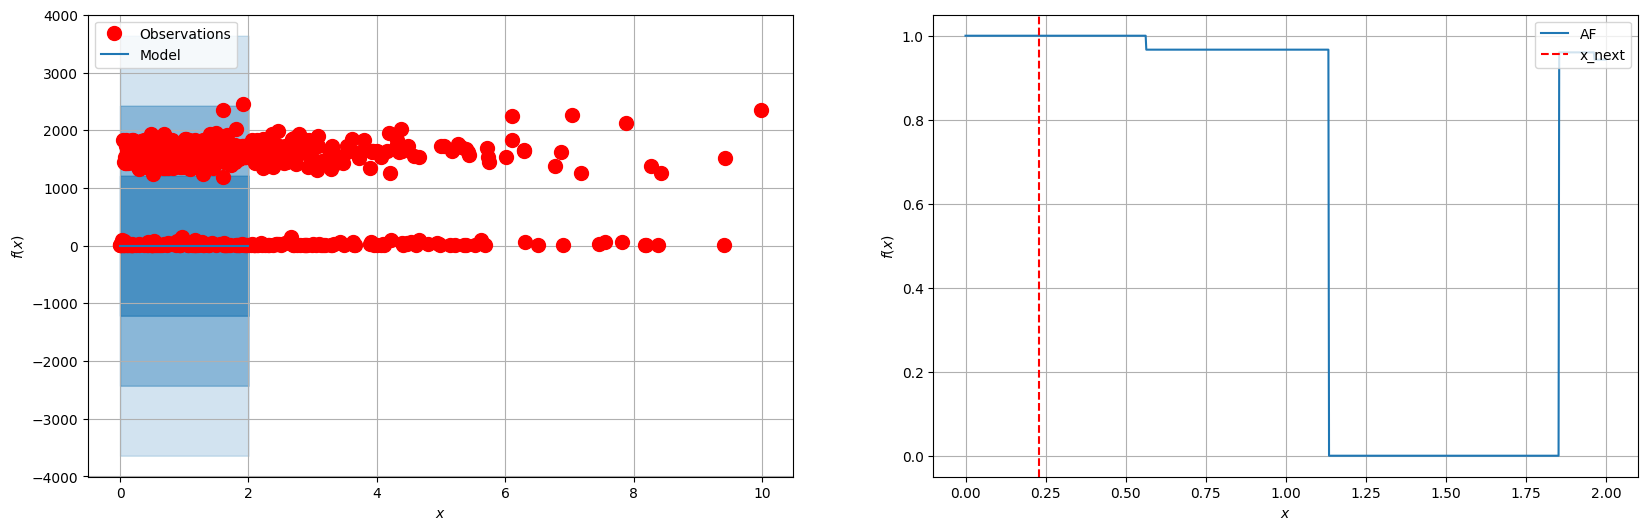

In [37]:
#Y_ne = -Y
model = model_generation(X, Y, space)
model.optimize()
ce_acquisition = CrossEntropy(model,space)
es_history = train(model, X, Y, space, 'CE', 1000)

In [38]:
file_path = 'training_logs/CE_plot_0_projection_0_2024-01-17 03:19:53.384504'
with open(file_path + '/history.npy', 'rb') as f:
    history = np.load(f)

In [39]:
x = np.array([i for i in range(len(history))])

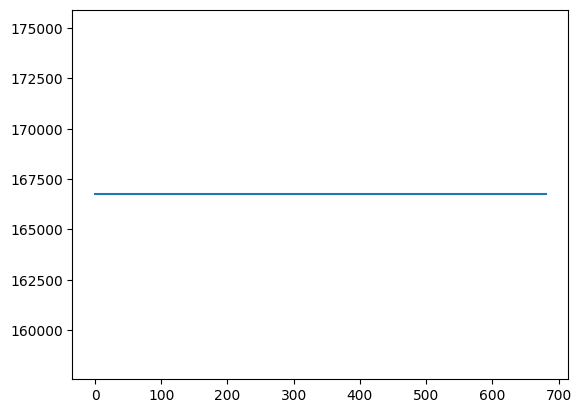

In [40]:
plt.plot(history[1:])

In [85]:
import pickle
with open(file_path+'/model.pkl', 'wb') as outp:
    pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)

In [35]:
import numpy as np
import scipy.stats
from typing import Tuple, Union
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IDifferentiable, IJointlyDifferentiable, IModel, IModelWithNoise
from scipy.stats import entropy

class CrossEntropy(Acquisition):
    def __init__(self, model: Union[IModel, IDifferentiable],space: ParameterSpace, jitter: float = 0.0) -> None:
        """
        For a given input, this acquisition computes the improvement over the current best observed value in
        expectation. For more information see:

        Efficient Global Optimization of Expensive Black-Box Functions
        Jones, Donald R. and Schonlau, Matthias and Welch, William J.
        Journal of Global Optimization

        :param model: model that is used to compute the improvement.
        :param jitter: parameter to encourage extra exploration.
        """

        self.model = model
        self.jitter = jitter
        self.space = space

    def evaluate(self, X: np.ndarray) -> np.ndarray:
        ces = []
        for x in X:
            #print(x.shape,x)
            predicted_mu, predicted_var = self.model.predict(np.array([x]))
            predicted_mu = predicted_mu[0]
            predicted_var = predicted_var[0]

            index = np.sqrt(np.sum((self.model.X-x)**2,axis=-1)).argsort()[:5]
            observed_mu = (self.model.Y[index]*1).mean()
            observed_x2 = (model.Y[index]**2).mean()
                                  
            #observed_mu = (np.sqrt(np.sum((self.model.X-x)**2,axis=-1))/(np.sqrt(np.sum((self.model.X-x)**2,axis=-1))).sum()).dot(self.model.Y)
            #observed_x2 = (np.sqrt(np.sum((self.model.X-x)**2,axis=-1))/(np.sqrt(np.sum((self.model.X-x)**2,axis=-1))).sum()).dot(self.model.Y**2)
            observed_std = np.sqrt(observed_x2-observed_mu**2)
            predicted_std = np.sqrt(predicted_var)
            # print(predicted_mu, predicted_std, observed_mu, observed_std)
            temp = np.linspace(0, 1000, 1000)
            pk = scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std)/scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std).sum()
            qk = scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std)/scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std).sum()
            ce = entropy(pk, base=2) + entropy(pk, qk, base=2)
            ces.append([ce])
        return np.array(ces)

    def debug(self, X: np.ndarray) -> np.ndarray:
        ces = []
        for x in X:
            #print(x.shape,x)
            predicted_mu, predicted_var = self.model.predict(np.array([x]))
            predicted_mu = predicted_mu[0]
            predicted_var = predicted_var[0]

            index = np.sqrt(np.sum((self.model.X-x)**2,axis=-1)).argsort()[:5]
            observed_mu = (self.model.Y[index]*1).mean()
            observed_x2 = (model.Y[index]**2).mean()
                                  
            #inverse_distances = 1/np.sqrt(np.sum((self.model.X-x)**2,axis=-1))
            #observed_mu = (inverse_distances/inverse_distances.sum()).dot(self.model.Y)
            #observed_x2 = (inverse_distances/inverse_distances.sum()).dot(self.model.Y**2)
            
            observed_std = np.sqrt(observed_x2-observed_mu**2)
            predicted_std = np.sqrt(predicted_var)
            print(predicted_mu, predicted_std, observed_mu, observed_std)
            #print(x,predicted_mu, predicted_var)
            temp = np.linspace(0, 1000, 1000)
            pk = scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std)/scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std).sum()
            qk = scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std)/scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std).sum()
            ce = entropy(pk, base=2) + entropy(pk, qk, base=2)
            ces.append([ce])
        return np.array(ces)


    @property
    def has_gradients(self) -> bool:
        """Returns that this acquisition has gradients"""
        return False

    def _get_model_predictions(self, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Get model predictions for the function values at given input locations."""
        return self.model.predict(x)

    def _get_y_minimum(self) -> np.ndarray:
        """Return the minimum value in the samples observed so far."""
        return np.min(self.model.Y, axis=0)


In [28]:
index = np.sqrt(np.sum((model.X-x)**2,axis=-1)).argsort()[:5]


971.4

In [14]:
x = np.array([8.19507842, 4.90173281, 7.81230064, 6.81165557])

In [33]:
np.sqrt((model.Y[index]**2).mean() - (model.Y[index]*1).mean()**2)

779.5148747778967